# Chapter 12 - Monsters and Mixtures

This chapter is about making likelihood / link functions composed of different pieces of the ones we've looked at in previous chapters.

Three common and useful models:
1. Models for handling over-dispersion - extensions to the binomial and Poisson models to cope with unmeasures sources of variations
1. **Zero-inflated** and **zero-augmented** models, which mixes a binary event with an ordinary GLM likelihood like a Poisson or binomial
1. Ordered categorical models, useful for categorical outcomes with a fixed ordering. This model is built by merging a categorical likelihood function with a special kind of link function, usually a **cumulative link**

## Over-dispersed counts

In **Chapter 7**, we saw that models based on the **normal** distribution can be overly sensitive to outliers.

The problem isn't the outliers - instead, it's the fact that the counts arise from a mixture of different processes, which can result in thicker tails than we might naively expect.

When counts are more variable than a pure process would suggest, we say that they exhibit **over-dispersion**. The variance of a variable is sometimes called its **dispersion**.

For instance, in a **binomial** variable the expected variance is $Np / (1 - p)$. If we observe a greater variance than that, then it might be that some unobserved variable is producing additional dispersion.

Our model might be good enough for predictive work, even with the over-dispersion. However, we might be missing out on an important effect. It's worth the time to dig into the cause of the over-dispersion.

In this chapter we'll deal with continuous mixture models in which a linear model is attached not to the observations, but to the distribution of the observations.

In **Chapter 13**, we'll see how to use **multilevel models** that estimte both the residuals of each observation and the distribution of those residuals. It's often easier to use multilevel models than mixture models because they can handle additional kinds of heterogeneity.

### Beta-binomial

A **Beta-binomial** model is a mixture of binomial distributions. Assumption is that each binomial count has some probability of success, and then we estimate the distribution of probabilities of success instead of a single probability of success. Any predictor variables describe the shape of the distribution.

For example, let's look at the `UCBAdmit` data. The model was over-dispersed when we ignored the department since there was a lot of variability coming from there. Let's see how a beta-binomial model can pick up on this, even when we ignore department as a predictor.

The beta-binomial model will assume that each observed count on each row of the data table has its own unique, unobserved probability of admissions. These probabilities of admission have their own common distribution. We describe the distribution of these probabilities using a **beta distribution**. One advantage of using the **beta distribution** is that we can derive a closed-form solution for the likelihood function.

A **beta distribution** has two parameters: and average probability $\bar{p}$ and a shape parameter $\theta$. The shape parameter $\theta$ describes how spread out the distribution is. When $\theta = 2$, all probabilities are equally likely. When $\theta > 2$, the range of probabilities gets limited to a spike around the mean. When $\theta < 2$, the values are so dispersed that they actually moave *awa* from the mean and make extreme values like 0 or 1 more likely.

We're going to make a model where the predictor variables change $\bar{p}$, the mean.

$$
\begin{align*}
    A_i &\sim \text{BetaBinomial}(N_i, \bar{p_i}, \theta) \\
    \text{logit}(\bar{p_i}) &= \alpha_{\text{GID}[i]} \\
    \alpha_j &\sim \text{Normal}(0, 1.5) \\
    \theta &= \phi + 2 \\
    \phi &\sim \text{Exponential}(1)
\end{align*}
$$

$A$ is the admittance, $N$ is the number of applications, and $\text{GID}[i]$ is the gender index - 1 for male, 2 for female.

Here we have a trick in the prior on $\theta$. We want the value to be greater than 2, so we add two to the exponential distribution (lowest value: 0) to make our own distribution have a minimum value of 2.

In [2]:
library(rethinking)
library(ggplot2)
library(gtools)
library(repr)

options(repr.plot.width = 16, repr.plot.height = 8)

Loading required package: cmdstanr

This is cmdstanr version 0.7.0.9000

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/ericr/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Loading required package: posterior

This is posterior version 1.5.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


Loading required package: parallel

rethinking (Version 2.40)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent



Attaching package: ‘gtools’


The following object is masked from ‘package:rethinking’:

    logit




In [2]:
data(UCBadmit)

d <- UCBadmit
d$gid <- ifelse(d$applicant.gender == 'male', 1L, 2L)
dat <- list(A = d$admit, N = d$applications, gid = d$gid)
m12.1 <- ulam(
    alist(
        A ~ dbetabinom(N, pbar, theta),
        logit(pbar) <- a[gid],
        a[gid] ~ dnorm(0, 1.5),
        transpars> theta <<- phi + 2,
        phi ~ dexp(1)
    ),
    data = dat,
    chains = 4
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_binomial_lpmf: Second prior sample size parameter[2] is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d3871082.stan', line 22, column 4 to column 57)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 finished in 0.0 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 0.6 seconds.



In [3]:
# looking at the contrast first
post <- extract.samples(m12.1)
post$da <- post$a[,1] - post$a[,2]
precis(post, depth=2)

mean       sd        5.5%        94.5%     histogram 
a[1]  -0.4421293 0.4063700 -1.08906100 0.2157494 ▁▁▇▇▂▁▁   
a[2]  -0.3262416 0.3895973 -0.93744867 0.2996487 ▁▁▅▇▂▁▁   
phi    1.0485135 0.8184643  0.09524084 2.5758021 ▇▇▅▃▂▁▁▁▁▁
theta  3.0485135 0.8184643  2.09524180 4.5758021 ▇▇▅▃▂▁▁▁▁▁
da    -0.1158877 0.5732637 -1.00963352 0.8303310 ▁▁▁▅▇▇▂▁▁

The parameter $a[1]$ is the log-odds of admission for male applications. It is slightly lower than for female ones, but from the different $da$ we can see that it is highly uncertain.

Recall that in **Chapter 11**, a binomial model of the data that omitted the department resulted in a spurious indication that the female admission rate was lower than the male one. So why doesn't this model have the same problem?

The beta-binomial model allows each row in the data (each combination of department + gender) to have its own unobserved intercept. These unobserved intercepts are sampled from a beta distribution with mean $\bar{p_i}$ and dispersion $\theta$. We can plot this distribution.

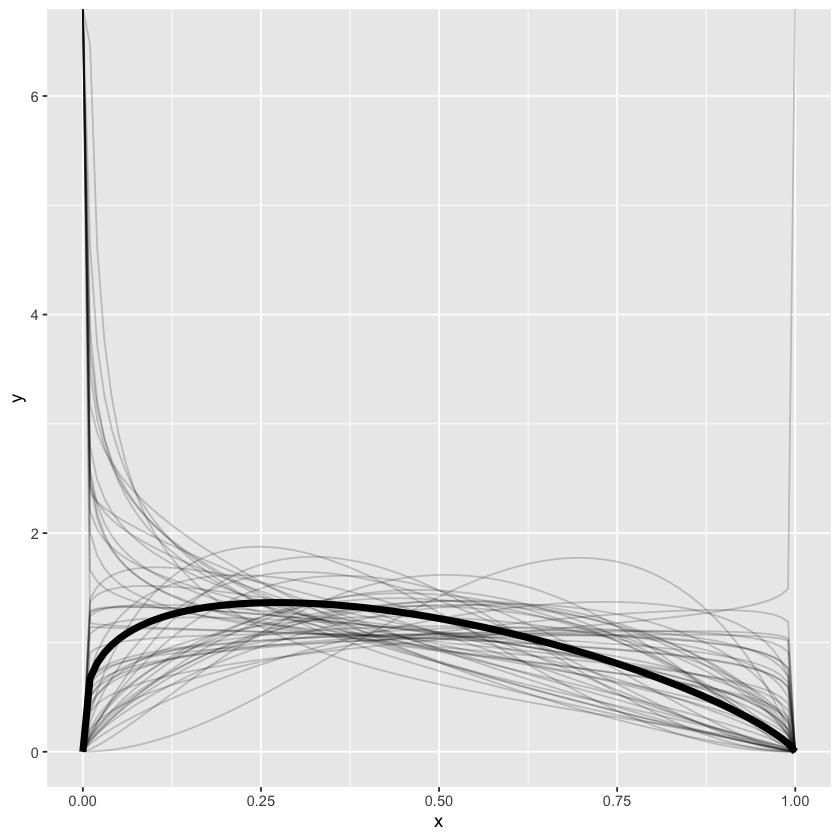

In [4]:
# female curves
gid <- 2
ps <- seq(0, 1, length.out = 100)

mean_curve <- data.frame(
    x = ps,
    y = dbeta2(ps, mean(logistic(post$a[,gid])), mean(post$theta))
)

graph <- ggplot() +
    geom_line(data = mean_curve, mapping = aes(x, y), linewidth = 2)

# now add some distributions sampled from the posterior
for (i in 1:50) {
    p <- logistic(post$a[i, gid])
    theta <- post$theta[i]
    sample_curve_data <- data.frame(
        x = ps,
        y = dbeta2(ps, p, theta)
    )
    graph <- graph +
        geom_line(data = sample_curve_data, mapping = aes(x, y), alpha = 0.2)
}

print(graph)

What this shows is that although the posterior is slanted toward low rates of admission, there is a lot of variation - it is plausible that there will be departments that wil admit almost no or almost all of the applicants! The model is no longer 'tricked' by department variation into a false inference about gender.

To get a sense of how the beta distribution of probabilities of admission influences predicted counts of applications admitted, let's look at the posterior check:

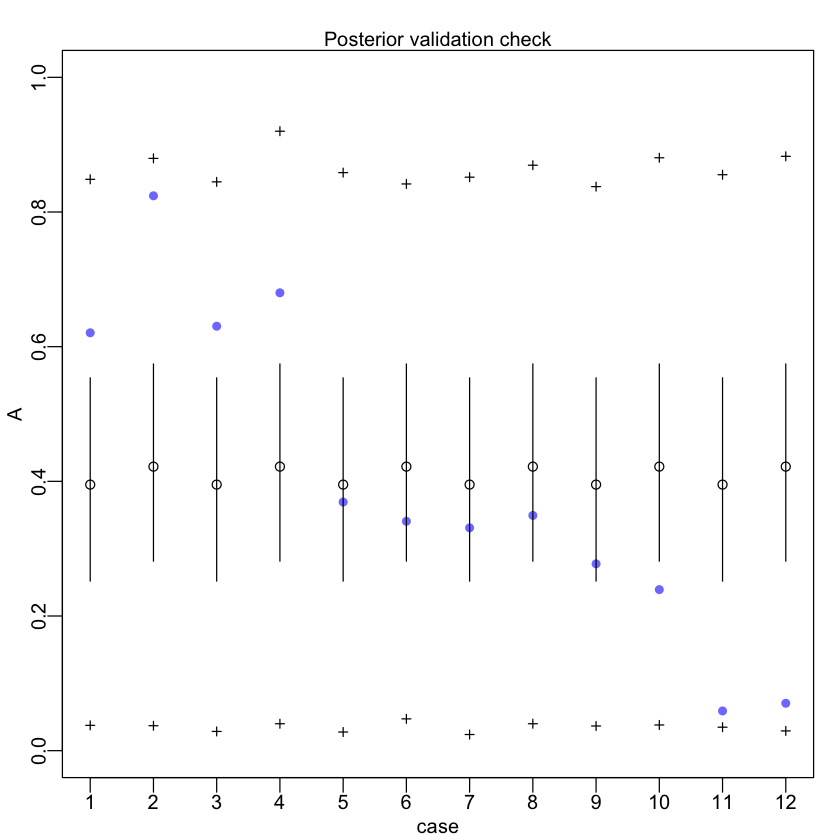

In [5]:
par(bg = 'white')
postcheck(m12.1)

The blue circles are the empirical rates of admission. The hollow circles and lines are the posterior mean $\bar{p}$ and the 89% credible interval, and the + symbols are the 89% intervale for admission numbers.

There is a lot of dispersion here. The model doesn't know that it comes from the department (that data isn't in the model), but it can see that there is a lot of dispersion and account for it.

## Negative-binomial or gamma-Poisson

The negative-binomial or gamma-Poisson model assumes that each Poisson count observation has its own rate. It estimates the shape of a gamma distribution to describe the Poisson rates across the different cases. Predictor variables adjust the shape of the distribution, not the expected value of each observation.

The gamma-Poisson is very much like the beta-binomial, except that here the beta distribution of rates is replaced by the gamma distribution of rates / expected values. We use the gamma because the math works out nicely; there's an analytical formula.

The gamma-Poisson distribution has two parameters, one for the mean (rate) and another for the dispersion (scale) of the rates across cases.

$$
y_i \sim \text{Gamma-Poisson}(\lambda_i, \phi)
$$

The $\lambda$ parameter behaves like the rate of an ordinary Poisson. The $\phi$ parameter must be positive and cotrols the variance. The variance of a gamma-Poisson is $\lambda + \lambda^2 / \phi$ - the larger $\phi$, the more similar the results are to a pure Poisson process.

Let's try it out with the Oceanic Tools example. In that dataset, Hawaii was very influential. However, it will be far less influential in the equivalent gamma-Poisson model, because that model expects more variation; thus, the 'outlier' point has less of an effect on the overall trend.

In [6]:
data(Kline)
d <- Kline
d$P <- standardize(log(d$population))
d$contact_id <- ifelse(d$contact == 'high', 2L, 1L)

data2 <- list(
    T = d$total_tools,
    P = d$population,
    cid = d$contact_id
)

m12.2 <- ulam(
    alist(
        T ~ dgampois(lambda, phi),
        lambda <- exp(a[cid]) * P ^ b[cid] / g,
        a[cid] ~ dnorm(1,1),
        b[cid] ~ dexp(1),
        g ~ dexp(1),
        phi ~ dexp(1)
    ),
    data = data2,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d65228afc.stan', line 21, column 4 to column 39)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d65228afc.stan', line 21, column 4 to column 39)

Chain 1 If this warning occurs sporadically, suc

Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: neg_binomial_2_lpmf: Location parameter[4] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d65228afc.stan', line 21, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.1 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: neg_binomial_2_lpmf: Location parameter[1] is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d65228afc.stan', line 21, column 4 to column 39)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: neg_binomial_2_lpmf: Precision parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d65228afc.stan', line 21, column 4 to column 39)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 0.9 seconds.



If you look at the graphs of the pure Poisson and the gamma-Poisson (p. 375 in the textbook) there is much less of a difference between the high and low contact trend lines. Hawaii was doing most of the work in pulling them apart, and since in gamma-Poisson model there is more expected variance, that influence is diminished.

### Over-dispersion, entropy, and information criteria

Beta-binomial and gamma-Poisson are maximum-entropy models for the same constraints as the regular binomial and Poisson distributions. The difference is that they try to account for any unobserved heterogeneity in the populations.

You should not use PSIS or WAIC with these models unless you really know what you're doing. The reason is with the base models (binomial and Poisson) you can aggregate and disaggregate the rows (group the data) without changing the fundamental causal structure of the model. However, that is not the case with these models, since the new unobserved parameter is applied to each *row*; if we disaggregate / aggregate them, we change the population to which the parameter is being applied.

For instance, the earlier `UCBAdmit` data was grouped with total counts on each row (for each gender and department). The rows were combinations of gender + department. If we changed the data so that each row was a single person's admission (which we would want to do for WAIC since we want to estimate the accuracy of *each new admissions*) then we lose the grouping into departments which was so useful in the first place.

It doesn't seem to be a big problem in practice; in the next chapter we'll look at incorporating over-dispersion with multilevel models which let us assign heterogeneity in probabilities / rates over any level of aggregation.

## Zero-Inflated Outcomes

Sometimes our observations are not the result of a pure process. Instead , they are mixtures of multiple processes. When there are multiple different causes for the same outcome, we might want to use a **mixture model**. A mixture model uses more than one simple probability distribution to model that mixture of causes; they use more than one likelihood for the same outcome.

Count variables are especially prone to mixtures. It is often the case that e.g. a zero count can represent the underlying process either not getting started at all or just actually producing a 0. For instance, if we're counting birds, a 0 count can happen because there are no birds at all or because we just failed to spot them.

### Zero-Inflated Poisson

Let's go back to the example with the monks producing manuscripts at a certain rate. The process tends towards being Poisson. Now, let's say that on some days the monks take a vacation and drink instead of work; on those days zero manuscripts are produced. However, on other days they just happen to produce 0 manuscripts by chance. How can we estimate the number of days they spend drinking (or rather, the probability of each day being a drinking day)?

Each observed 0 can be the result of two processes.

Let $p$ be the probability of them drinking and $\lambda$ be the rate at which they complete manuscripts.

We need a likelihood function which mixes these two processes.

$$
\begin{align*}
    P(0|p,\lambda) &= P(\text{drink}|p) + P(\text{work}|p) \times P(0|\lambda) \\
                    &= p + (1-p)*\text{exp}(-\lambda)
\end{align*}
$$

since $P(y|\lambda) = \lambda^y e^{-\lambda} / y!$, $P(0|\lambda) = \lambda^0 e^{-\lambda} / 0! = e^{-\lambda}$

The likelihood of a non-zero value is

$$
\begin{align*}
    P(y|y > 0, p, \lambda) &= P(\text{drink}|p)\ast 0 + P(\text{work}|p) \ast P(y|\lambda) \\
        &= (1-p)\ast \frac{\lambda^y e^{-\lambda}}{y!}
\end{align*}
$$

Let's define ZIPoisson as the distribution above, with aprameters $p$ (probability of a zero) and $\lambda$ (mean of the Poisson) to describe the shape. Then a zero-inflated Poisson regression would look like

$$
\begin{align*}
    y_i &\sim \text{ZIPoisson}(p_i, \lambda_i) \\
    \text{logit}(p_i) &= \alpha_p + \beta_p x_i \\
    \log(\lambda_i) &= \alpha_{\lambda} + \beta_\lambda x_i
\end{align*}
$$

There are two linear models and two link functions, one for each of the constituents of the ZIPoisson. The predictors can be different between $p_i$ and $\lambda_i$ - you don't even need to use the same predictors in each one!

Now let's simulate the data and ensure that we can actually get the right data back.

In [7]:
prob_drink <- 0.2
rate_work <- 1 # average of 1 manuscript per day

# one year
N <- 365

set.seed(365)
drink <- rbinom(N, 1, prob_drink)

# simulate maniscripts produced and total
manuscripts_worked <- rpois(N, rate_work)

y <- (1 - drink) * manuscripts_worked

In [8]:
m12.3 <- ulam(
    alist(
        y ~ dzipois(p, lambda),
        logit(p) <- ap,
        log(lambda) <- al,
        ap ~ dnorm(-1.5, 1),
        al ~ dnorm(1, 0.5)
    ),
    data=list(y = y),
    chains = 4
)
precis(m12.3)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

mean         sd         5.5%       94.5%      rhat     ess_bulk
ap -1.305791363 0.36607506 -1.9505329 -0.8124823 1.003204 515.8134
al  0.002555389 0.08968448 -0.1447622  0.1425496 1.005898 538.0696

In [9]:
# posterior means on the natural scale
post <- extract.samples(m12.3)
post_p <- mean(inv_logit(post$ap))
post_lambda <- mean(exp(post$al))
print(post_p)
print(post_lambda)

[1] 0.2194038
[1] 1.006581


These are very close to the rates that we expect! In reality the problems will probably have lots of predictor variables that are associated with each of the parameters.

## Ordered categorical outcomes

Very common to have discrete categories, but where the outcomes are ordered in some way. For instance, I might ask you to rate on a scale from 1 - 7 how much you like fish. However, be careful - with scales like this, despite the use of numbers, the difference between a 1 and 2 might be different than between a 5 and 6, for instance.

In principle, this is just a categorical prediction. However, the fact that the categories are ordered demands special consideration. What we want from the predictor variable(s) is that as they increase, the prediction should move through the categories from one to the next.

The convenctional solution is to use a **cumulative link function**. The cumulative probability of a value is the probability of that value *or any smaller value*. In the context of ordered categories, the sumulative probability of 3 is the probability of 3, 2, or 1. (Conventionally, ordered categories start at 1).

There are two steps to the explanation. The first: explain how to parameterize a distribution of outcomes on the scale of log-cumulative odds. The next is to introduce a predictor to the log-cumulative odds values, which allows the you to model associations between predictors and the outcomes while obeying the ordered nature of prediction.

### Example: moral intuition

Data comes from experiments on the trolley problem. 

Experiments on the trolley problem has led to some principles that people seem to follow:

1. **Action Principle**: Harm caused by action is morally worse than equivalent harm caused by omission
1. **Intention principle**: Harm intended as a means to a goal is morally worse than equivalent harm foreseen as the side effect of a goal
1. **Contact principle**: Using physical contact to cause harm to a victim is morally worse than causing equivelent harm to a victim without using physical contact

In [30]:
data(Trolley)
d <- Trolley
head(d)

case  response order id     age male edu           action intention contact
1 cfaqu 4         2    96;434 14  0    Middle School 0      0         1      
2 cfbur 3        31    96;434 14  0    Middle School 0      0         1      
3 cfrub 4        16    96;434 14  0    Middle School 0      0         1      
4 cibox 3        32    96;434 14  0    Middle School 0      1         1      
5 cibur 3         4    96;434 14  0    Middle School 0      1         1      
6 cispe 3         9    96;434 14  0    Middle School 0      1         1      
  story action2
1 aqu   1      
2 bur   1      
3 rub   1      
4 box   1      
5 bur   1      
6 spe   1

Each row is a person's response to a story; the `response` column indicates on a scale from 1 - 7 how morally permissible they found the action taken (or not) in the story.

### Desribing an ordered distribution with intercepts

First, let's see the distribution of outcomes

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


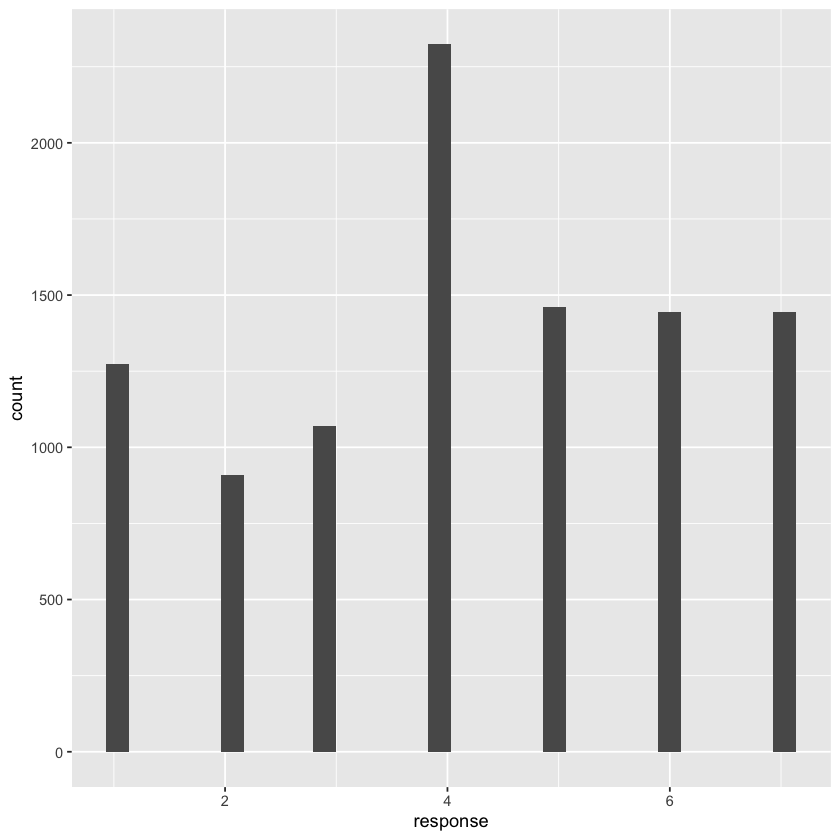

In [31]:
ggplot(d, aes(response)) +
    geom_histogram()

We want to describe this on the log-cumulative-odds scale. Why? This is the cumulative version of the **logit link** we used earlier. The logit is log-odds, and the cumulative logit is cumulative log odds.

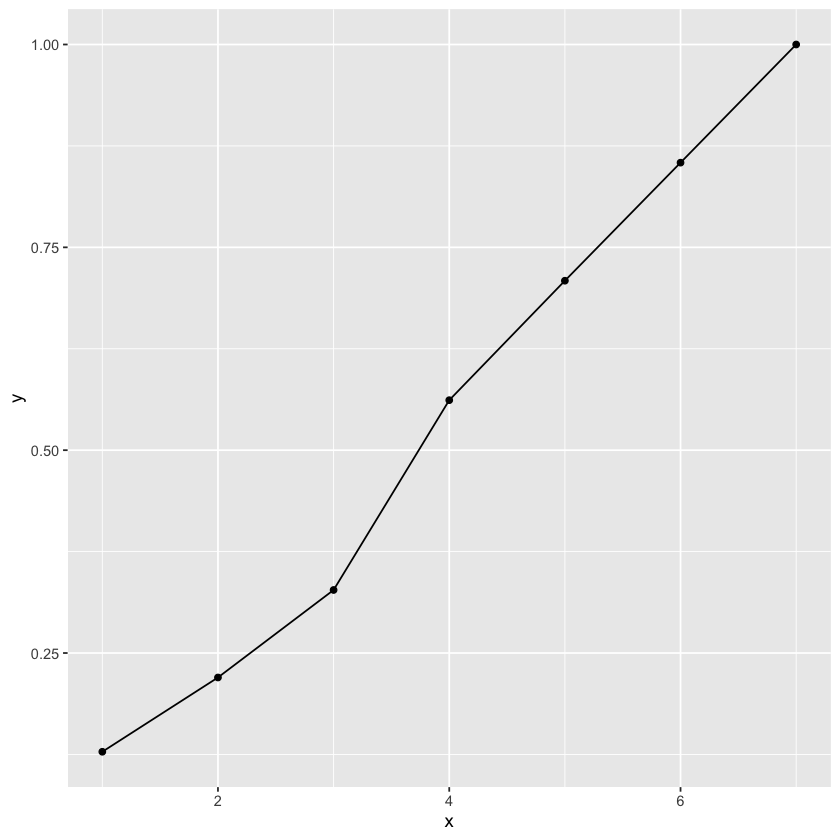

In [32]:
# proportion of each response
pr_k <- table(d$response) / nrow(d)

# cumsum to convert to cumulative proportions
cum_pr_k <- cumsum( pr_k )

ggplot(data.frame(x = 1:7, y = cum_pr_k), aes(x, y)) +
    geom_point() +
    geom_line()

To move it to log-cumulative odds, we need a series of intercepts. Each intercept will be on the log-cumulative-odds scale and stand for the cumulative probability of each event. This is the application of the link function.

$$
\log \frac{P(y_i \leq k)}{1 - P(y_i \leq k)} = \alpha_k
$$

In [33]:
logit <- function(x) log(x / (1 - x))
round(lco <- logit(cum_pr_k), 2)

Warning message in log(x/(1 - x)):
“NaNs produced”


1     2     3     4     5     6     7 
-1.92 -1.27 -0.72  0.25  0.89  1.77   NaN

Note that the log odds of the top parameter are always going to be $\log(1 / 0) \to \infty$; we basically don't even need that parameter.

When we observe a $k$ and need the probability, we can use subtraction to get there:

$$
p_k = P(y_i = k) = P(y_i \leq k) - P(y_i \leq k - 1)
$$

There are lots of conventions for writing mathematical forms of the ordered logit. Here's one way:

$$
\begin{align*}
    R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) & [\text{probability of data}] \\
    \phi_i &= 0 & [\text{linear model}] \\
    \kappa_k &\sim \text{Normal}(0, 1.5) & [\text{common prior for each intercept}] \\
\end{align*}
$$

Here's another, more literal way:

$$
\begin{align*}
    R_i &\sim \text{Categorical}(\vec{p}) & [\text{probability of data}] \\
    p_1 &= q_1 & [\text{probabilities of each value $k$}] \\
    p_k &= q_k - q_{k-1}\ K > k > 1 & \\
    p_K &= q - q_{k-1} \\
    \text{logit}(q_k) &= \kappa_k - \phi_i & [\text{cumulative logit link}] \\
    \phi_i &= \text{terms of the linear model} \\
    \kappa_k &\sim \text{Normal}(0, 1.5) & [\text{common prior for each intercept}] \\
\end{align*}
$$

This is a bit more complicated, but it makes it clear that the ordered categorical is just a categorical that takes a vector of probabilities.

In [34]:
m12.4 <- ulam(
    alist(
        R ~ dordlogit(0, cutpoints),
        cutpoints ~ dnorm(0, 1.5)
    ),
    data = list(R = d$response),
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3869.97, but should be greater than the previous element, -3869.97 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d37dbe39e.stan', line 9, column 24 to column 65)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3869.12, but should be greater than the previous element, -3869.12 (in '/var/folders/86/1fgck35j5s9g7_

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2491.33, but should be greater than the previous element, -2491.33 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d37dbe39e.stan', line 9, column 24 to column 65)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2492.38, but should be greater than the previous element, -2492.38 (in '/var/folders/86/1fgck35j5s9g7_

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2789.15, but should be greater than the previous element, -2789.15 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d37dbe39e.stan', line 9, column 24 to column 65)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2786.47, but should be greater than the previous element, -2786.47 (in '/var/folders/86/1fgck35j5s9g7_

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3644.4, but should be greater than the previous element, -3644.4 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d37dbe39e.stan', line 9, column 24 to column 65)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3643.25, but should be greater than the previous element, -3643.25 (in '/var/folders/86/1fgck35j5s9g7_r3

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]

In [35]:
precis(m12.4, depth=2)

mean       sd         5.5%      94.5%      rhat     ess_bulk
cutpoints[1] -1.9159967 0.02953641 -1.964302 -1.8690807 1.002072 1689.377
cutpoints[2] -1.2659526 0.02404988 -1.304122 -1.2272884 1.000694 2092.690
cutpoints[3] -0.7184566 0.02138377 -0.753510 -0.6849178 1.002140 2535.823
cutpoints[4]  0.2475910 0.02048816  0.215151  0.2800441 1.000354 2791.473
cutpoints[5]  0.8898611 0.02187741  0.853960  0.9241028 1.000876 2624.785
cutpoints[6]  1.7692250 0.02884435  1.722775  1.8140920 1.000210 2270.467

In [36]:
# get the cumulative probabilities back
round(inv_logit(coef(m12.4)), 3)

cutpoints[1] cutpoints[2] cutpoints[3] cutpoints[4] cutpoints[5] cutpoints[6] 
       0.128        0.220        0.328        0.562        0.709        0.854

Those are roughly the same values as before; now we also have their distribution.

### Adding predictor variables

So far we haven't accomplished much.

To include predictor variables, we define the log-cumulative-odds of each response $k$ as a sum of its intercept $\alpha_k$ and a regular linear model. Say we want to include a predictor $x$ to the model. Then we add a linear model $\phi_i = \beta x_i$, which makes the cumulative logit

$$
\begin{align*}
\log \frac{P(y_i \leq k)}{1 - P(y_i \leq k)} &= \alpha_k - \phi_i \\
\phi_i &= \beta x_i
\end{align*}
$$

Why subtract the linear model? If we decrease the log-cumulative-odds of every outcome below $k$, this shift probability mass upwards toward the higher outcome values. That means that positive values of $\beta$ means increasing $x$ also increases the mean $y$. We could certainly add $\phi$, but then $\beta > 0$ would mean that increasing $x$ decreases the mean.

For instance, let's say that we take the posterior means for `m12.4` and subtract 0.5 from each:

In [37]:
round(pk <- dordlogit(1:7, 0, coef(m12.4)), 2)

[1] 0.13 0.09 0.11 0.23 0.15 0.15 0.15

In [38]:
# average outcome
sum(pk * 1:7)

[1] 4.199201

In [39]:
# subtract off 0.5
round(pk <- dordlogit(1:7, 0, coef(m12.4) - 0.5), 2)

[1] 0.08 0.06 0.08 0.21 0.16 0.18 0.22

In [40]:
# new average
sum(pk * 1:7)

[1] 4.729694

By *subtracting*, we increase the mean. This way, inceasing $\beta$ implies an increase in the predictor means an increase in the outcome.

Now we can go back to the trolley problem and code in our predictors. For this model, we'll use the predictors of `action`, `intention`, and `contact`, each one corresponding for a principle outlined earlier.

Note that `contact` always implies `action`.

This gives us 6 different options:

1. No action, contact, or intention
1. Action
1. Contact
1. Intention
1. Action and intention
1. Contact and intention

The last two of these represent an interaction.

We'll use the indicator variable directly this time.

The log-cumulative-odds are now:

$$
\begin{align*}
    \log \frac{P(y_i \leq k)}{1 - P(y_i \leq k)} &= \alpha_k - \phi_i \\
    \phi_i &= \beta_A A_i + \beta_C C_i + \beta_{I,i}I_i \\
    B_{I, i} &= \beta_I + \beta_{IA}A_i + \beta_{IC}C_i \\
\end{align*}
$$

Here we've explicitly coded the interaction into a new variable $B$ to make things clearer; we could just as easily have substituted the value directly into the definition of $\phi$.

Here's the model:

In [41]:
dat <- list(
    R = d$response,
    A = d$action,
    I = d$intention,
    C = d$contact
)

m12.5 <- ulam(
    alist(
        R ~ dordlogit(phi, cutpoints),
        phi <- bA * A + bC * C + BI * I,
        BI <- bI + bIA * A + bIC * C,
        c(bA, bI, bC, bIA, bIC) ~ dnorm(0, 0.5),
        cutpoints ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    cores = 4
)
precis(m12.5)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -992.584, but should be greater than the previous element, -992.584 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d779bd9a7.stan', line 30, column 24 to column 70)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -991.885, but should be greater than the previous element, -991.885 (in '/var/folders/86/1fgck35j5s9g7

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3900.88, but should be greater than the previous element, -3900.88 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d779bd9a7.stan', line 30, column 24 to column 70)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3902.48, but should be greater than the previous element, -3902.48 (in '/var/folders/86/1fgck35j5s9g7

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2530.76, but should be greater than the previous element, -2530.76 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d779bd9a7.stan', line 30, column 24 to column 70)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2530.16, but should be greater than the previous element, -2530.16 (in '/var/folders/86/1fgck35j5s9g7

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2094.31, but should be greater than the previous element, -2094.31 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d779bd9a7.stan', line 30, column 24 to column 70)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2094.78, but should be greater than the previous element, -2094.78 (in '/var/folders/86/1fgck35j5s9g7

Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]

6 vector or matrix parameters hidden. Use depth=2 to show them.



mean       sd         5.5%       94.5%      rhat      ess_bulk 
bIC -1.2365864 0.09383004 -1.3886417 -1.0896178 1.0012167 1311.0849
bIA -0.4318807 0.07841415 -0.5569462 -0.3070851 1.0000339 1362.9769
bC  -0.3414661 0.06515598 -0.4472851 -0.2396374 1.0024492 1216.8330
bI  -0.2931201 0.05689291 -0.3839079 -0.2031280 1.0004210 1041.3692
bA  -0.4728817 0.05304754 -0.5566313 -0.3887871 0.9998076  982.4266

Note that they're all negative - each of these factors decreases the acceptability of the story / action

6 vector or matrix parameters hidden. Use depth=2 to show them.



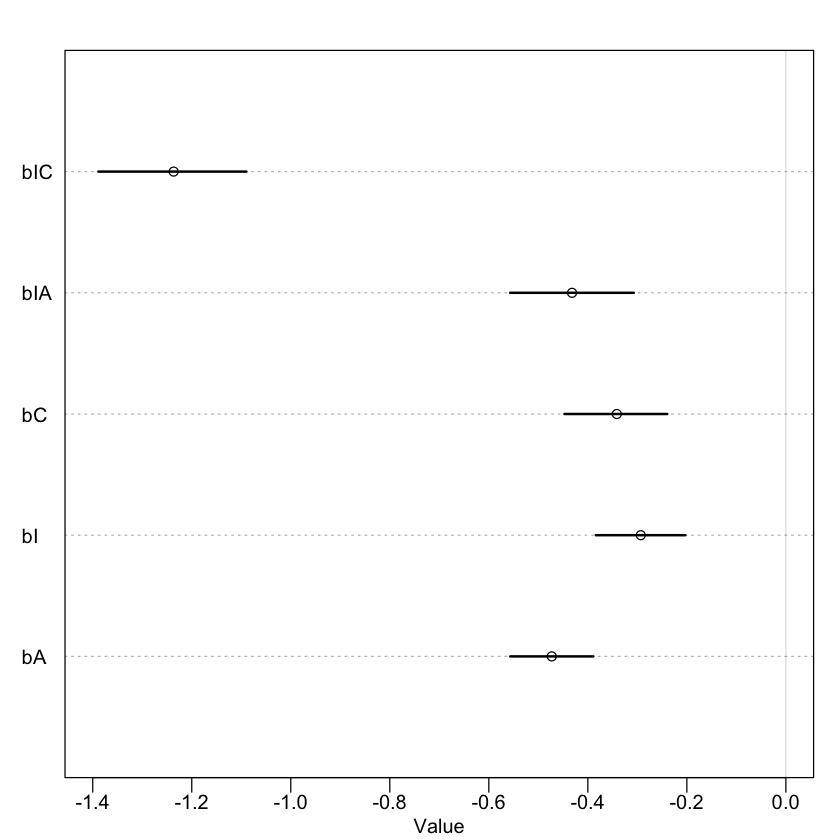

In [42]:
par(bg='white')
plot(precis(m12.5), xlim=c(-1.4, 0))

This would be easier to see if we could plot the posterior predictions. However, that is tricky, since each prediction is really a vector of probabilities - one for each possible outcome value. As the predictor variables change, so do the *entire vector* of outputs.

One common way to do this is to have the horizontal axis for a predictor variable and the vertical axis for cumulative probability. Then we can plot a curve for each response value as it changes across values of the predictor variable. If we plot a curve for each response value, we'll end up with a distribution of responses as it changes across values of the predictor variable.

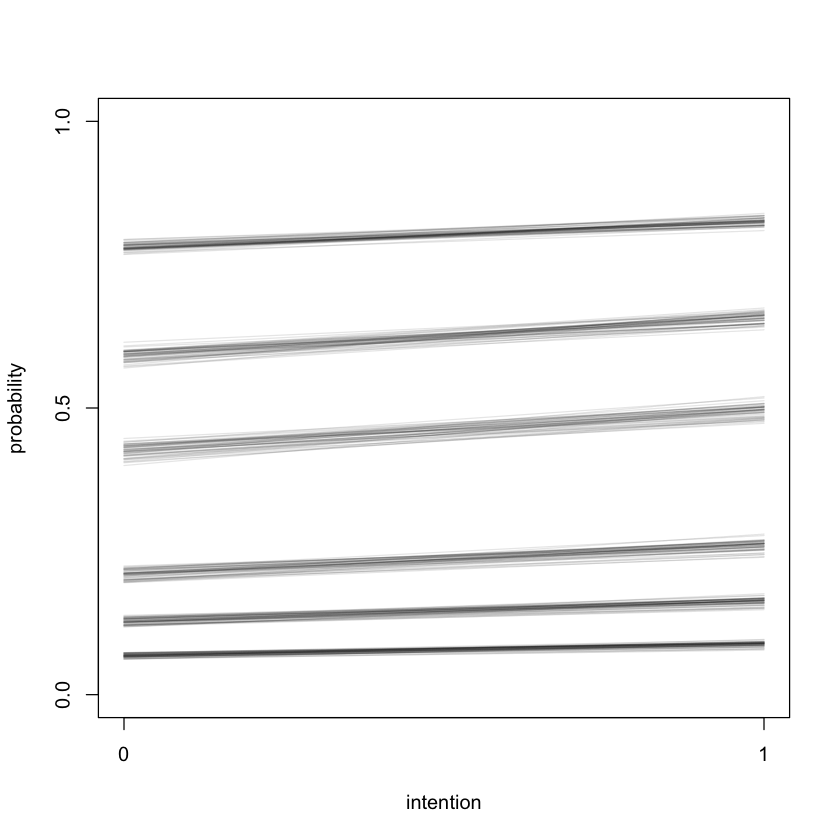

In [43]:
par(bg='white')
plot(NULL, type="n", xlab="intention", ylab="probability", xlim=c(0, 1), ylim=c(0, 1), xaxp=c(0, 1, 1), yaxp=c(0, 1, 2))

# set up the data list that contains the different combinations of predictors.
kA <- 0 # action
kC <- 0 # contact
kI <- 0:1 # intention
pdat <- data.frame(A = kA, C = kC, I = kI)

# pass it to link to get the phi samples
phi <- link(m12.5, data = pdat)$phi

# loop over the first 50 samples and plot their predictions across values of intention
# Trick is to use `pordlogit` to compute the cumulative probability use the sampes in phi and the cutpoints
post <- extract.samples(m12.5)
for (s in 1:50) {
    pk <- pordlogit(1:6, phi[s, ], post$cutpoints[s,])
    for (i in 1:6) {
        lines(kI, pk[, i], col=grau(0.1))
    }
}

By changing the values of kA and kC, we could see the effect of changing I in each of these scenarios. 

We can also create a histogram of the outcomes by using `sim` to simulate posterior outcomes.

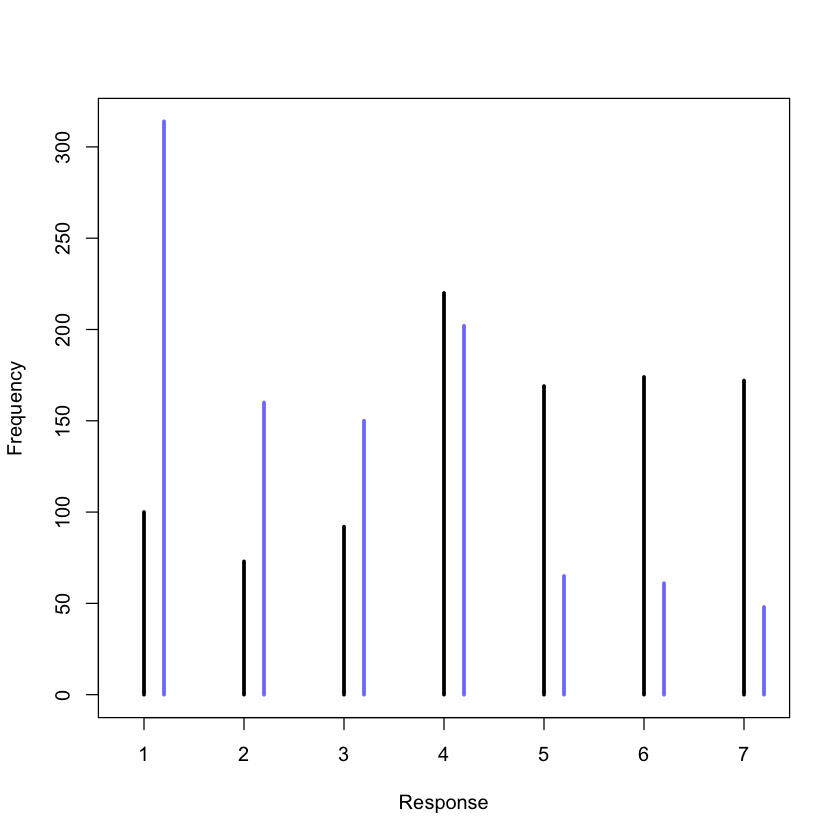

In [44]:
par(bg='white')
kA <- 0
kC <- 1
kI <- 0:1
pdat <- data.frame(A = kA, C = kC, I = kI)
s <- sim(m12.5, data = pdat)
simplehist(s, xlab = "Response")

Black lines are when I = 0, blue is I = 1. Essentially, the story here is that going from no interaction -> interaction increases the chances of a low response and decreases the chances of a high response.

## Ordered categorical predictors

So far we've looked at categorical *outcomes*. What if the predictors are some sort of ordered category? In principle we could pretend that they are linear, but just like we didn't want to do that for the outcomes it's an equally bad idea here.

The Trolley dataset has an example: education level.

In [45]:
levels(d$edu)

[1] "Bachelor's Degree"    "Elementary School"    "Graduate Degree"     
[4] "High School Graduate" "Master's Degree"      "Middle School"       
[7] "Some College"         "Some High School"

There are 8 levels here. Unfortunately they're not in the correct order, so we need to fix that.

In [46]:
# This is actually us replacing the text of the level with the numerical representation
edu_levels <- c(6, 1, 8, 4, 7, 2, 5, 3)
d$edu_new <- edu_levels[d$edu]
d$edu_new

[1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6
  [38] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5
  [75] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [112] 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 [149] 7 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4
 [186] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6
 [223] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 [260] 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [297] 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4
 [334] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 [371] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [408] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [445] 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6
 [482] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [519] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [556] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [593] 6 6 6 6 6 6 6 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 [630] 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3
 [667] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6
 [704] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [741] 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 [778] 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7
 [815] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 3 3 3
 [852] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 [889] 8 8 8 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [926] 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7
 [963] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
[1000] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
[1037] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1074] 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
[1111] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5
[1148] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7
[1185] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1222] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1259] 6 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 7 7 7 7
[1296] 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 3 3 3 3
[1333] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1370] 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
[1407] 7 7 7 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1444] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
[1481] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1518] 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1555] 6 6 6 6 6 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6
[1592] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5
[1629] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[1666] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1703] 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1740] 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
[1777] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1814] 5 5 5 5 5 5 5 5 5 5 5 5 5 5

The idea behind ordered predictor variables is that each step up comes with its own incremental / marginal effect on the outcome. That means that we want to infer what each of those effects is. With 8 levels, we need 7 parameters (1 -> 2, 2 -> 3, &c.).

The first parameter (elementary school) will be absorbed into the intercept.

Our linear model is starting to look as follows:

$$
\phi_i = \delta_1 + \text{other stuff}
$$

Here $\delta_1$ is the effect of completing middle school (middle school -> some high school), and 'other stuff' is all of the other effects that we haven't dealt with yet.

A different individual completes the next level (Some High School), so their model would be

$$
\phi_i = \delta_1 + \delta_2 + \text{other stuff}
$$

Someone with the highest level, a graduate degree, woud have a linear model like

$$
\sum_{j=1}^{7}\delta_i + \text{other stuff}
$$

It's convenient for later interpretation if we call the maximum sum and ordinary coefficient like $\beta_E$ and then let all of the $\delta$ parameters be fractions of this maximum sum. If we include a dummy $\delta_0 = 0$, then our model is

$$
\phi_i = \sum_{j=0}^{E_i-1}\delta_j + \text{other stuff}
$$

Where $E_i$ is the maximum educational attainment of individual $i$. Note that the sum of $\delta_j$ is 1. Also, if someone has the lowest education attainment, then $\beta_E$ doesn't appear in the model because it will only be multiplying the dummy $\delta_0 = 0$.

Defining it in this way also helps us to define priors for $\beta_E$ and the rest. If we expect the levels to be equally spaced on the underlying linear scale, then we can give them all the same prior. We can separately set a prior on $\beta_E$ to determine the total effect of education (or whatever).

Let's see what that model will look like for us:

$$
\begin{align*}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_E \sum_{j=0}^{E_i - 1}\delta_j + \beta_A A_i + \beta_I I_i + \beta_C C_i \\
\end{align*}
$$

Now we need a whole bunch of priors. The priors for the cutpoints are on the logit scale, so we'll use our regularizing priors with standard deviation 1.5. The slopes get narrower priors - each of these is the log-odds difference

$$
\begin{align*}
\kappa &\sim \text{Normal}(0, 1.5) \\
\beta_A, \beta_I, \beta_C, \beta_E &\sim \text{Normal}(0, 1) \\
\delta &\sim \text{Dirichlet}(\alpha)
\end{align*}
$$

This last line is new - the prior for $\delta$ is from the **Dirichlet Distribution**. This is the multivariate version of the **Beta Distribution**. This distribution is for a vector of values, all between 0 and one, which sum to 1. The **beta** is the distribution for two values; the **Dirichlet** extends this to any number. Like the **beta**, it is parameterized by 'pseudo-counts' for each possibility. In the beta they were the number of successes and failures ($\alpha$ and $\beta$); for the **Dirichlet** it is just a vector of counts (successes, presumably).

In [48]:
set.seed(1805)
delta <- rdirichlet(10, alpha = rep(2, 7))
delta

[,1]       [,2]       [,3]       [,4]       [,5]       [,6]      
 [1,] 0.10531402 0.03999053 0.07958541 0.12153233 0.24473313 0.13780806
 [2,] 0.25042007 0.08914921 0.08122755 0.16279318 0.09614976 0.12892247
 [3,] 0.19169161 0.24096413 0.01190757 0.06676158 0.26010974 0.19841979
 [4,] 0.12405712 0.11851318 0.33153891 0.03516935 0.13764852 0.12844491
 [5,] 0.08774940 0.03240889 0.15166692 0.24049639 0.06173455 0.23906111
 [6,] 0.13462030 0.05974400 0.18765413 0.22280044 0.10288096 0.07458804
 [7,] 0.10334697 0.09848294 0.03551862 0.23140054 0.19133775 0.25018561
 [8,] 0.23671078 0.17581052 0.04317941 0.12924604 0.21926430 0.07135114
 [9,] 0.07347475 0.21009599 0.17633836 0.19569642 0.22037361 0.07481659
[10,] 0.33541220 0.06823140 0.05123645 0.26034135 0.16708028 0.02614977
      [,7]      
 [1,] 0.27103653
 [2,] 0.19133775
 [3,] 0.03014558
 [4,] 0.12462801
 [5,] 0.18688275
 [6,] 0.21771214
 [7,] 0.08972758
 [8,] 0.12443780
 [9,] 0.04920429
[10,] 0.09154854

We end up with 10 vectors of 7 probabilities, each summing to 1

In [57]:
plot_df <- data.frame(x = integer(), p = numeric(), group = integer())
for (i in 1:nrow(delta)) {
    plot_df <- rbind(plot_df, data.frame(
        x = 1:7,
        p = delta[i, ],
        group = i
    ))
}
head(plot_df)

x p          group
1 1 0.10531402 1    
2 2 0.03999053 1    
3 3 0.07958541 1    
4 4 0.12153233 1    
5 5 0.24473313 1    
6 6 0.13780806 1

Warning message:
“Using linewidth for a discrete variable is not advised.”


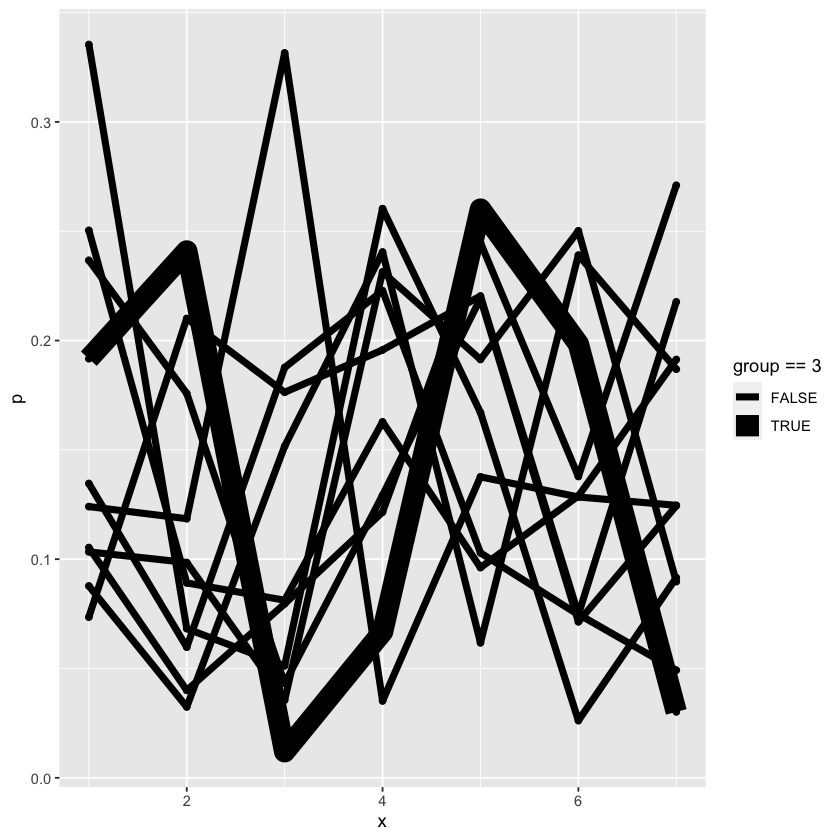

In [58]:
ggplot(plot_df, aes(x, p, group = group)) +
    geom_point() +
    geom_line(aes(linewidth = group == 3)) 

We also need to deal with the fact that $\delta_0 = 0$.

In [60]:
dat <- list(
    R = d$response,
    action = d$action,
    intention = d$intention,
    contact = d$contact,
    E = as.integer(d$edu_new), # this is an index
    alpha = rep(2, 7) # delta prior
)

m12.6 <- ulam(
    alist(
        R ~ ordered_logistic(phi, kappa),
        phi <- bE * sum(delta_j[1:E]) + bA * action + bI * intention + bC * contact,
        kappa ~ normal(0, 1.5),
        c(bA, bI, bC, bE) ~ normal(0, 1),
        vector[8]: delta_j <<- append_row(0, delta),
        simplex[7]: delta ~ dirichlet(alpha)
    ),
    data = dat,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3040.29, but should be greater than the previous element, -3040.29 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d1f2ffda6.stan', line 30, column 24 to column 66)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3040.1, but should be greater than the previous element, -3040.1 (in '/var/folders/86/1fgck35j5s9g7_r

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2501.15, but should be greater than the previous element, -2501.15 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d1f2ffda6.stan', line 30, column 24 to column 66)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2500.31, but should be greater than the previous element, -2500.31 (in '/var/folders/86/1fgck35j5s9g7

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4089.72, but should be greater than the previous element, -4089.72 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d1f2ffda6.stan', line 30, column 24 to column 66)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4088.36, but should be greater than the previous element, -4088.36 (in '/var/folders/86/1fgck35j5s9g7

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4163.08, but should be greater than the previous element, -4163.08 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d1f2ffda6.stan', line 30, column 24 to column 66)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4161.85, but should be greater than the previous element, -4161.85 (in '/var/folders/86/1fgck35j5s9g7

Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]

Few notes:
- we're passing in the prior as data; that's fine to do
- Summing over the first $E$ values of $\delta_d$ 
- We build the `delta_j` vector using the `append_row` method
    - This is from **Stan**, not a native R one
- We call the resultant vector a **simplex**. A simplex is another name for a vector whose values sum to some given value (usually 1). Again, this is a Stan object. Putting the `simplex[7]` in front tells Stan that the variable is a simplex of length 7
- This model takes forever to run (!)

In [62]:
precis(m12.6, depth = 2, omit = "kappa")

mean        sd         5.5%         94.5%       rhat      ess_bulk 
kappa[1] -3.07675731 0.15199411 -3.331083050 -2.86354015 1.0099402  831.6626
kappa[2] -2.39441591 0.14928560 -2.648600150 -2.18863925 1.0094658  820.5333
kappa[3] -1.81180439 0.14832242 -2.063176300 -1.60642865 1.0092105  824.1459
kappa[4] -0.79017528 0.14770321 -1.037327800 -0.58142634 1.0089861  844.8868
kappa[5] -0.12218845 0.14759632 -0.369906910  0.08451394 1.0091870  861.9233
kappa[6]  0.78474039 0.14848037  0.532156745  0.99407491 1.0094681  860.1058
bE       -0.31517534 0.16879583 -0.595084645 -0.07756135 1.0093685  883.4559
bC       -0.95537364 0.05130479 -1.038319350 -0.87494732 1.0015069 2234.0763
bI       -0.71638951 0.03767764 -0.774022035 -0.65618056 0.9998169 3381.0185
bA       -0.70329414 0.04235110 -0.770940315 -0.63635313 1.0030986 2414.1654
delta[1]  0.22711858 0.13527568  0.052594735  0.47145300 1.0073370 1212.4423
delta[2]  0.14209005 0.08953907  0.031159830  0.31182948 1.0019117 2250.7237
delta[3]  0.19545434 0.11223559  0.047357984  0.40200492 1.0014951 2134.1301
delta[4]  0.17096330 0.09547568  0.040300925  0.34332163 1.0009113 2519.9967
delta[5]  0.04190406 0.04784824  0.005546966  0.11297132 1.0039897 1690.5523
delta[6]  0.09905737 0.06354878  0.022223182  0.21400941 1.0015995 2256.4041
delta[7]  0.12341232 0.07420887  0.025958869  0.25620603 1.0009942 2373.4611

The overall effect of `bE` is negative - more educated individuals disapprove of everything. It's not as powerful an effect as e.g. adding action (-0.3 v. -0.7).

To see what's going on with the `delta` parameters, we'll have to look at them as a multivariate distribution.

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”


Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

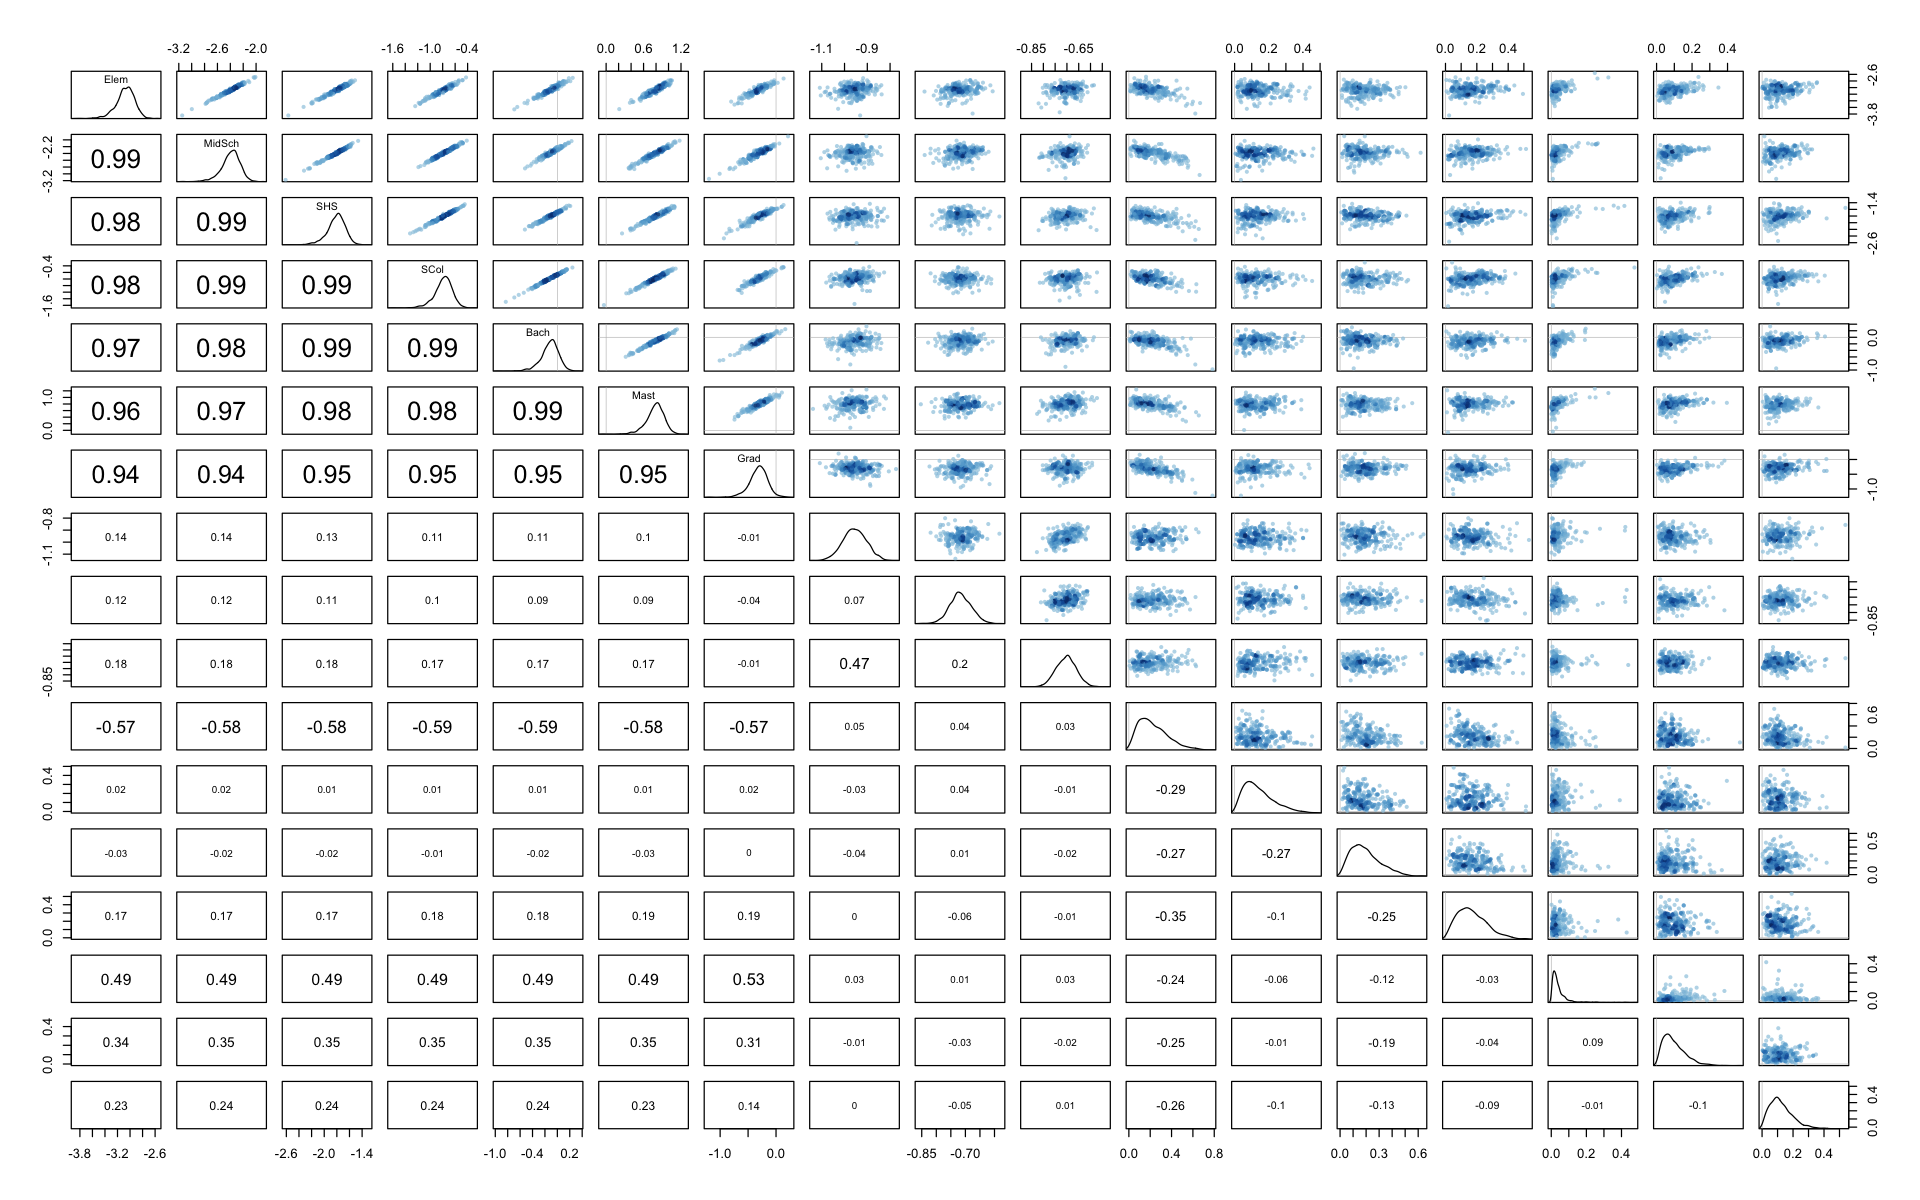

In [68]:
par(bg = 'white')
options(repr.plot.width = 16, repr.plot.height = 10)
delta_labels <- c("Elem", "MidSch", "SHS", "SCol", "Bach", "Mast", "Grad")
pairs(m12.6, pars = "delta", labels = delta_labels)

Not sure what's going on here - the `pars` parameter doesn't actually seem to do anything.

It's interesting to compare the above model, where the scale isn't linear, to one where we assume that education is linear

In [69]:
dat$edu_norm <- normalize(d$edu_new)
m12.7 <- ulam(
    alist(
        R ~ ordered_logistic(mu, cutpoints),
        mu <- bE * edu_norm + bA * action + bI * intention + bC * contact,
        c(bA, bI, bC, bE) ~ normal(0, 1),
        cutpoints ~ normal(0, 1.5)
    ),
    data = dat,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4013.83, but should be greater than the previous element, -4013.83 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d62a96bfd.stan', line 27, column 24 to column 69)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4013.25, but should be greater than the previous element, -4013.25 (in '/var/folders/86/1fgck35j5s9g7

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2072.22, but should be greater than the previous element, -2072.22 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d62a96bfd.stan', line 27, column 24 to column 69)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2074.49, but should be greater than the previous element, -2074.49 (in '/var/folders/86/1fgck35j5s9g7

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2669.41, but should be greater than the previous element, -2669.41 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d62a96bfd.stan', line 27, column 24 to column 69)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2667.45, but should be greater than the previous element, -2667.45 (in '/var/folders/86/1fgck35j5s9g7

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3702.83, but should be greater than the previous element, -3702.83 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpKUZAel/model-70d62a96bfd.stan', line 27, column 24 to column 69)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3702.33, but should be greater than the previous element, -3702.33 (in '/var/folders/86/1fgck35j5s9g7

Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]

In [70]:
precis(m12.7)

6 vector or matrix parameters hidden. Use depth=2 to show them.



mean        sd         5.5%       94.5%      rhat      ess_bulk
bE -0.09921081 0.09069224 -0.2453261  0.0438181 1.0006583 1685.959
bC -0.95640186 0.05013702 -1.0352065 -0.8771060 1.0040052 2191.218
bI -0.71759919 0.03717072 -0.7777304 -0.6595751 1.0000563 2172.068
bA -0.70392592 0.04268818 -0.7700486 -0.6356098 0.9999081 2401.170

This model thinks that education is not as strongly associated with rating. This could be because the effect actually isn't linear; different levels may have different incremental associations.

This model has been fine, but there's something that should worry us: age. Almost surely age is associted with education; you probably don't have a Master's degree if you're 12 years old. It is plausible that there is a backdoor from age to through age to rating. We'll investigate this later.

## Practice

#### 12E1 What is the difference between an ordered and unordered categorical variable? Define then give an example of each.

An unordered categorical variable does not reflect any underlying increase or decrease in an attribute of interest, whereas an ordered one does. For instance, when looking at a forest, the different species would represent an unordered categorical variable ('elm', 'oak', 'dandelion') whereas their height position in the canopy would be an ordered categorical variable ('canopy', 'shrub layer', 'ground cover').

#### 12E2 What kind of link function does an ordered logistic regression employ? How does it differ from an ordinary logit link?

An ordered logistic regression uses a **cumulative link function**. This is similar to the ordinary logit function, but where the logit function is the log-odds of an event orccurring, the cumulative link function is the log-cumulative-odds - that is, the log of the odds of that event or something lower on the scale occurring.

#### 12E3 When count data are zero-inflated, using a model that ignores zero-inflation will tend to introduce what kinds of inferential cost?

Ignoring zero-inflation will result in an estimate of the true rate that is lower than the true value; the zero-inflation will drag the estimated value towards zero.

#### 12E4 Over-dispersion is common in count data. Give an example of a natural process that might produce over-dispersed counts. Can you also give an example of a process that might produce *under*-dispersed counts?

A process that might involve over-dispersed data is presence / absence data of fossil organisms. We might find no fossils there because they generally weren't in that area, or because they were and just failed to fossilize.

A process that might involve under-dispersed counts is the occurrence of failing students in a class. Generally if someone 'just' fails (maybe by only a few percentage points), the professor will give them the benefit of the doubt and boost them a few points to avoid an outright failure. In that case fewer students would be failing than we would expect from the distribution of the rest of the grades.

#### 12M1 At a certain university, employees are annually rated from 1 to 4 on their productivity, with 1 being least productive and 4 being most. In a certain department at this university, the number of employees receiving each rating from (from 1 - 4): 12, 36, 7, 41. Compute the log cumulative odds of each rating.

In [2]:
odds <- function(p) p / (1 - p)
log_odds <- function(p) log(odds(p))
cumulative_log_odds <- function(counts, i) log_odds(sum(counts[1:i]) / sum(counts))

ratings <- c(12, 36, 7, 41)
for (i in 1:length(ratings)) {
    print(paste(i, cumulative_log_odds(ratings, i)))
}

[1] "1 -1.94591014905531"
[1] "2 0"
[1] "3 0.293761118528163"
[1] "4 Inf"


#### 12M2 Make a version of Figure 12.5 for the employee data rating given above

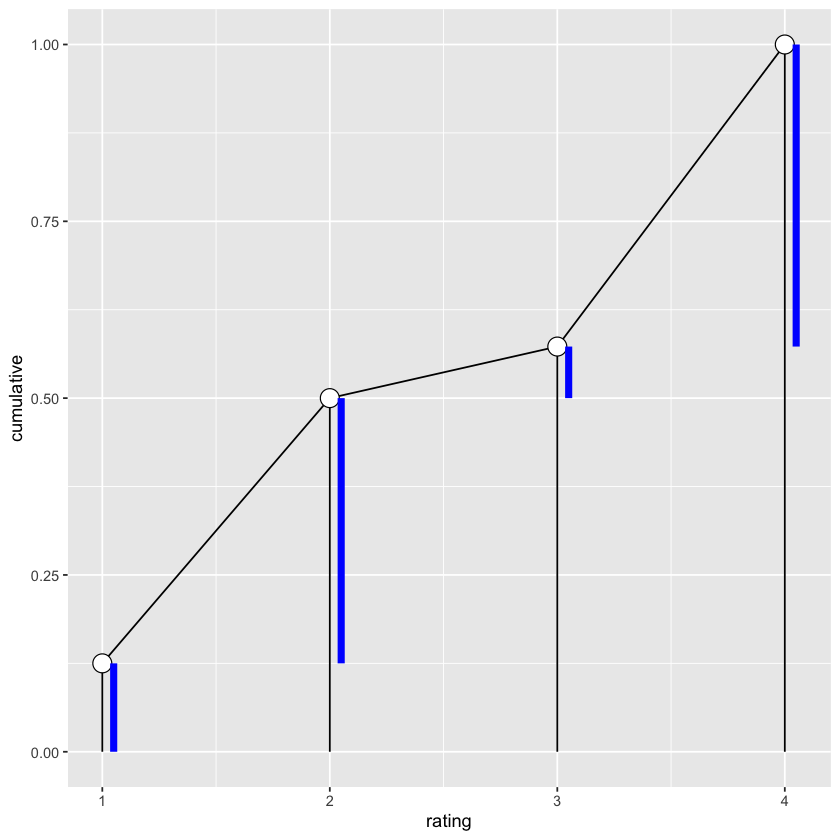

In [27]:
plot_df <- data.frame(
    rating = 1:4,
    count = ratings,
    proportion = ratings / sum(ratings),
    cumulative = cumsum(ratings / sum(ratings)),
    prev = cumsum(ratings / sum(ratings)) - ratings / sum(ratings)
)

jitter_offset = 0.05
ggplot(plot_df, aes(rating)) +
    geom_line(aes(y = cumulative)) +
    geom_segment(mapping = aes(y = 0, xend = rating, yend = cumulative)) +
    geom_point(aes(y = cumulative), shape = 21, size = 5, fill = 'white') +
    geom_segment(mapping = aes(x = rating + jitter_offset, y = prev, xend = rating + jitter_offset, yend = cumulative), colour = 'blue', linewidth = 2)

#### 12M3 Can you modify the derivation of the zero-inflated Poisson distribution `ZIPoisson` from this chapter to construct a zero-inflated binomial distribution?

Say you have some sort of situation distributed binomially with probability $p$ and count $n$. You also have some sort of condition such that, with probability $p_0$, you will see 0 of whatever you're counting.

For the binomial, the probability distribution is

$$
P_b(x) = \binom{n}{x}p^x(1-p)^{n - x}
$$

and the probability that you get zero events from the binomial is

$$
P_b(0) = p^0 \binom{n}{0}(1 - p)^{n - 0} = (1-p)^n
$$

If we see zero events, that can either happen because the blocking event occurred (probability $p_0$) or because it didn't and we got a natural zero from the binomial:

$$
P(0) = p_0 + (1 - p_0)(1-p)^n
$$

And the probability that we see $x > 0$ events is the probability that the blocking event did not happen and also that the binomial produced $x$ events:

$$
P(x|x > 0) = (1-p_0) * \binom{n}{x} p^x (1 - p)^{n - x}
$$

So then the full probability is

$$
P(x) = \begin{cases}
p_0 + (1 - p_0)(1-p)^n & x = 0 \\
(1-p_0) \ast \binom{n}{x} p^x (1 - p)^{n - x} & x > 0 \\
\end{cases}
$$

#### 12H1 In 2014, a paper was published titled "Female hurricanes are deadlier than male hurricanes". The paper claimed that hurricanes with female names have caused greater loss of life; the explanation given was that people subconsciously rate female hurricanes as less dangerous and so are less likely to evacuate. Statisticians severely criticized the paper after publication. Here, we'll consider the full data from the paper and consider the hypothesis that hurricanes with female names are deadlier. Load the data with
```R
library(rethinking)
data(Hurricanes)
```

Acquaint yourself with the columns by using `?Hurricanes`. In this problem, you'll focus on predicting `deaths` using `femininity` of each hurricane's name. Fit and interpret the simplest possible model, a Poisson model of `deaths` using `femininity` as a predictor. You can use `quap` or `ulam`. Compare the model to an intercept-only Poisson model of `deaths`. How strong is the association between femininity of a name and deaths? Which storms does the model fit (retrodict) well? Which storms does it fit poorly?

In [2]:
data(Hurricanes)
d <- Hurricanes
head(d)
summary(d)

name     year deaths category min_pressure damage_norm female femininity
1 Easy     1950  2     3        960           1590       1      6.77778   
2 King     1950  4     3        955           5350       0      1.38889   
3 Able     1952  3     1        985            150       0      3.83333   
4 Barbara  1953  1     1        987             58       1      9.83333   
5 Florence 1953  0     1        985             15       1      8.33333   
6 Carol    1954 60     3        960          19321       1      8.11111

       name         year          deaths          category      min_pressure   
 Bob     : 3   Min.   :1950   Min.   :  0.00   Min.   :1.000   Min.   : 909.0  
 Bonnie  : 2   1st Qu.:1965   1st Qu.:  2.00   1st Qu.:1.000   1st Qu.: 950.0  
 Charley : 2   Median :1985   Median :  5.00   Median :2.000   Median : 964.0  
 Cindy   : 2   Mean   :1982   Mean   : 20.65   Mean   :2.087   Mean   : 964.9  
 Danny   : 2   3rd Qu.:1999   3rd Qu.: 20.25   3rd Qu.:3.000   3rd Qu.: 982.2  
 Florence: 2   Max.   :2012   Max.   :256.00   Max.   :5.000   Max.   :1003.0  
 (Other) :79                                                                   
  damage_norm        female         femininity    
 Min.   :    1   Min.   :0.0000   Min.   : 1.056  
 1st Qu.:  245   1st Qu.:0.0000   1st Qu.: 2.667  
 Median : 1650   Median :1.0000   Median : 8.500  
 Mean   : 7270   Mean   :0.6739   Mean   : 6.781  
 3rd Qu.: 8162   3rd Qu.:1.0000   3rd Qu.: 9.389  
 Max.   :75000   Max.   :1.0000   Max.   :10.444  
   

In [3]:
?Hurricanes

Hurricanes             package:rethinking              R Documentation

_H_u_r_r_i_c_a_n_e _f_a_t_a_l_i_t_i_e_s _a_n_d _g_e_n_d_e_r _o_f _n_a_m_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Data used in Jung et al 2014 analysis of effect of gender of name
     on hurricane fatalities. Note that hurricanes Katrina (2005) and
     Audrey (1957) were removed from the data.

_U_s_a_g_e:

     data(Hurricanes)
     
_F_o_r_m_a_t:

       1. name : Given name of hurricane

       2. year : Year of hurricane

       3. deaths : number of deaths

       4. category : Severity code for storm

       5. min_pressure : Minimum pressure, a measure of storm strength;
          low is stronger

       6. damage_norm : Normalized estimate of damage in dollars

       7. female : Indicator variable for female name

       8. femininity : 1-11 scale from totally masculine (1) to totally
          feminine (11) for name. Average of 9 scores from 9 raters.

_

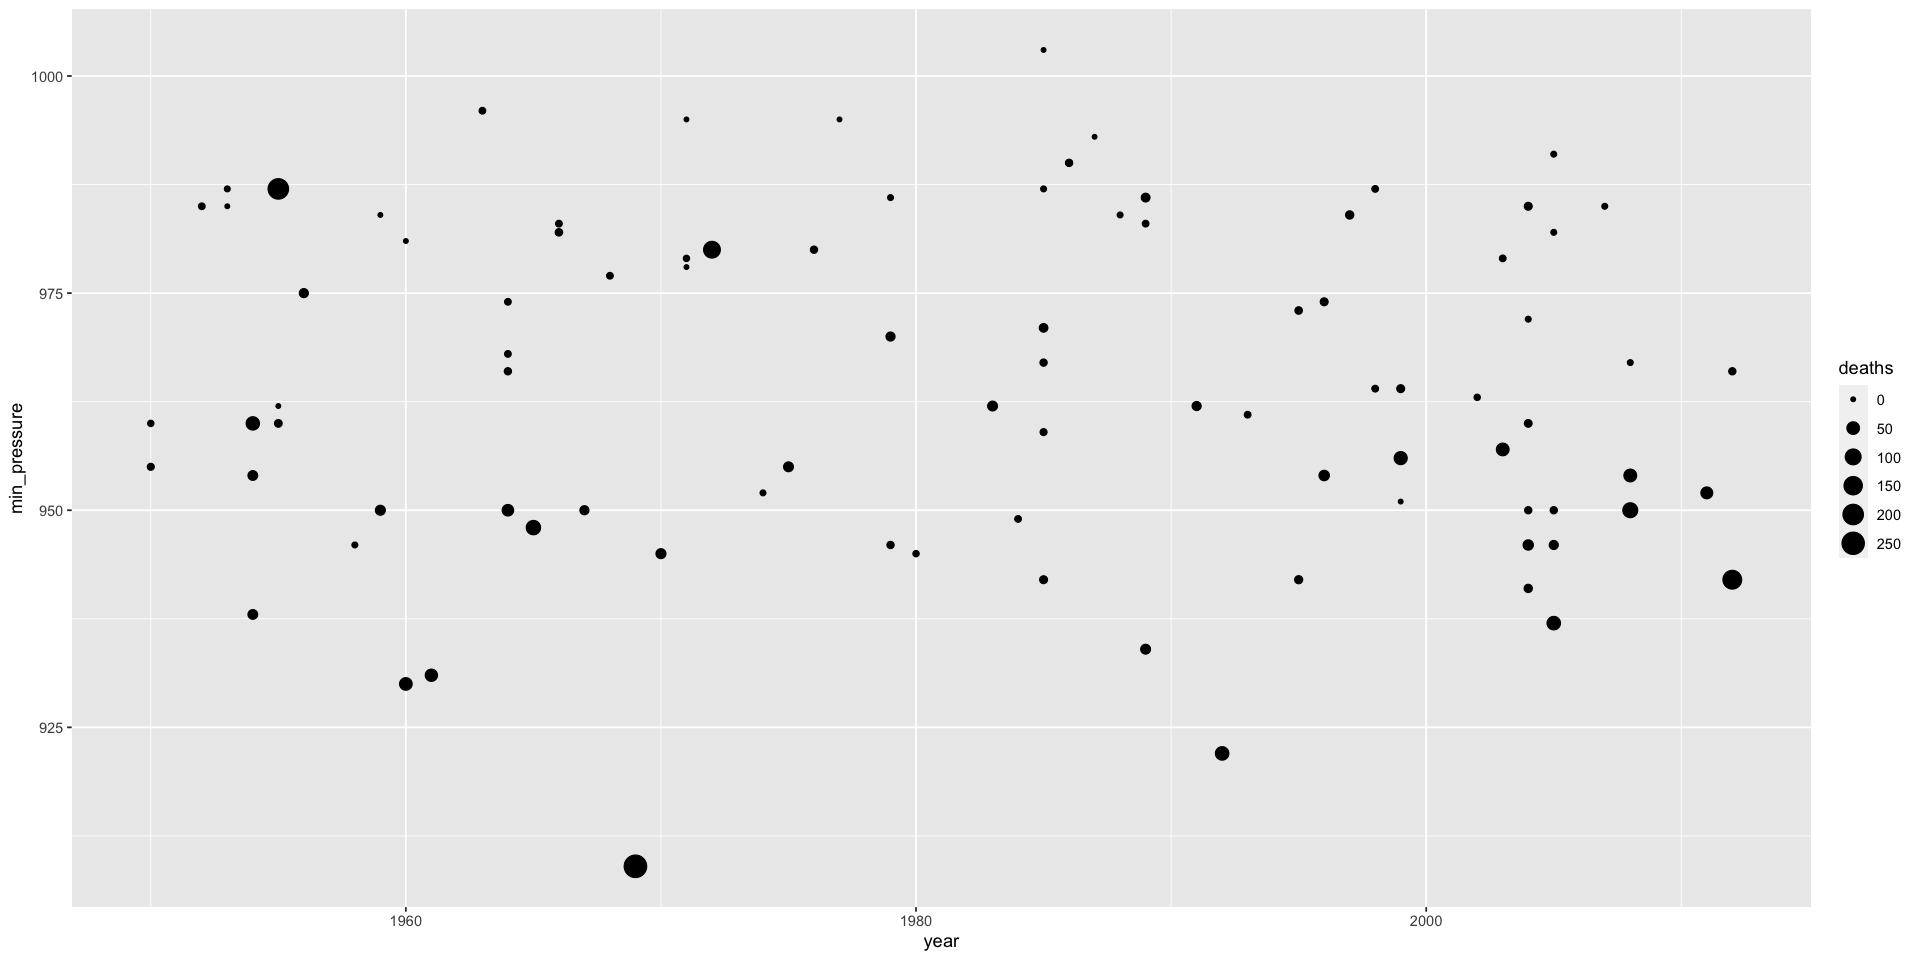

In [4]:
ggplot(d, aes(year, min_pressure)) +
    geom_point(aes(size = deaths))

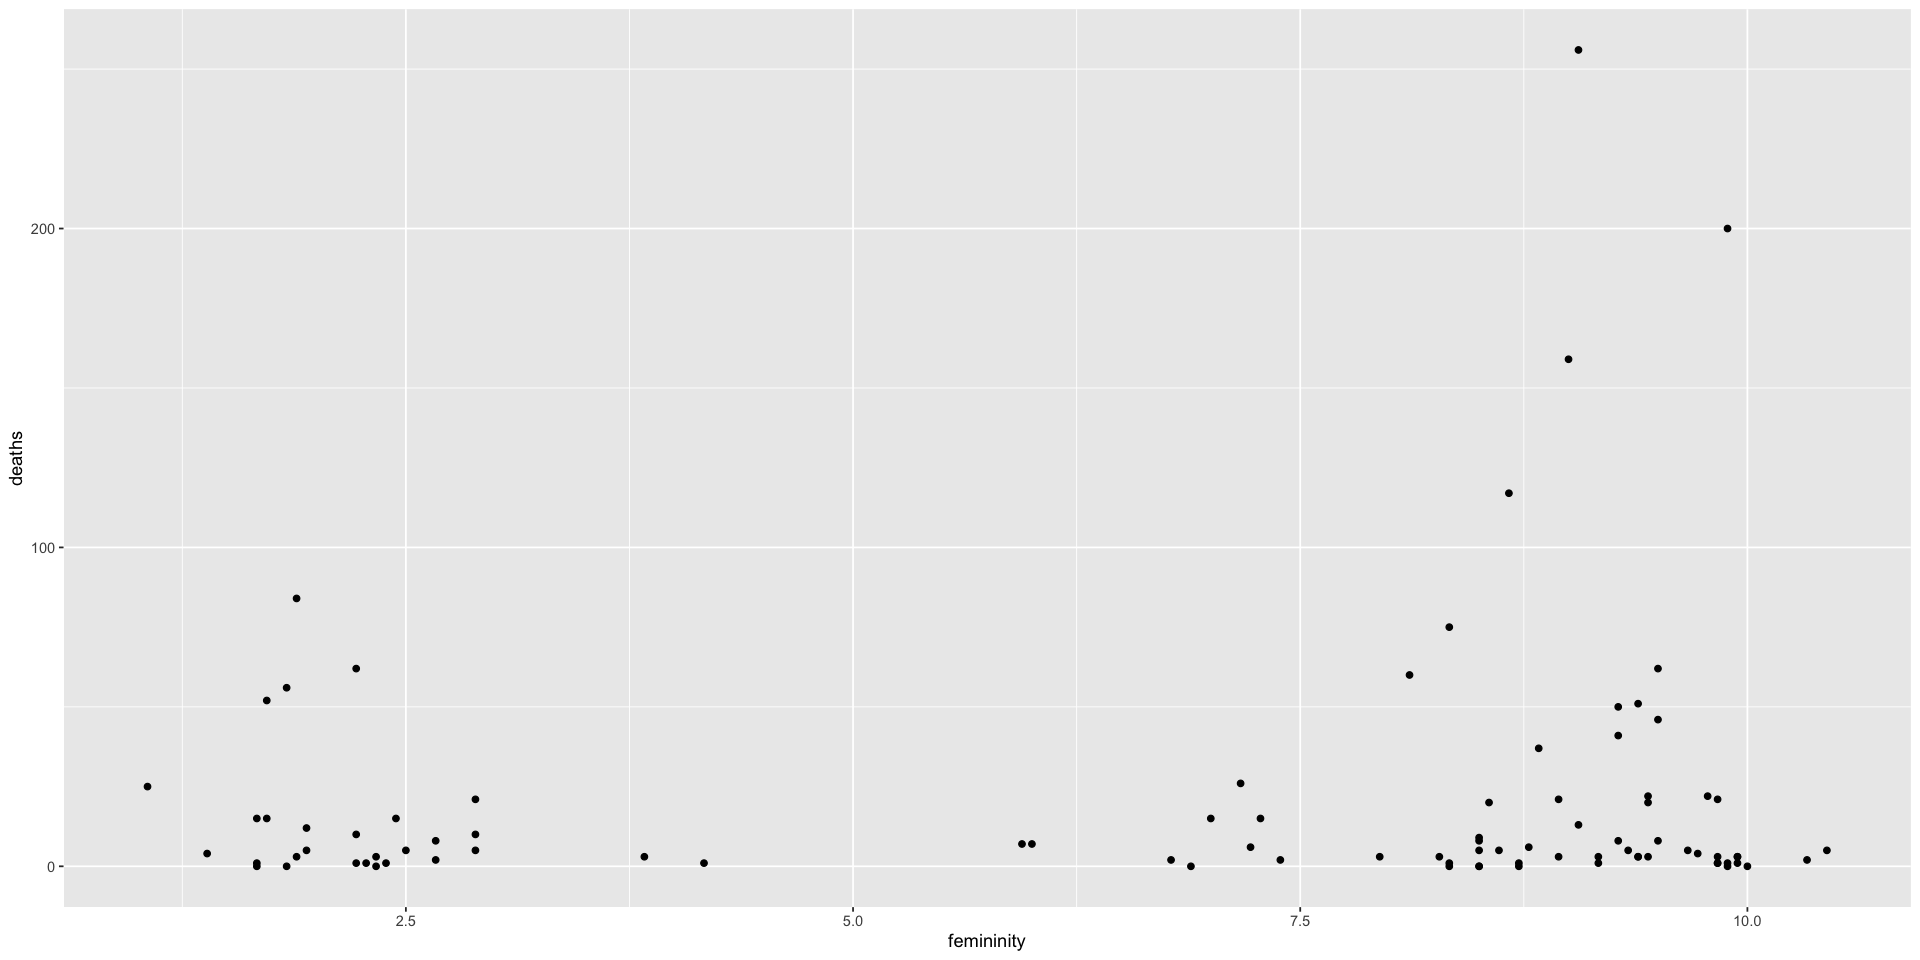

In [5]:
p <- ggplot(d, aes(femininity, deaths)) +
    geom_point()
print(p)

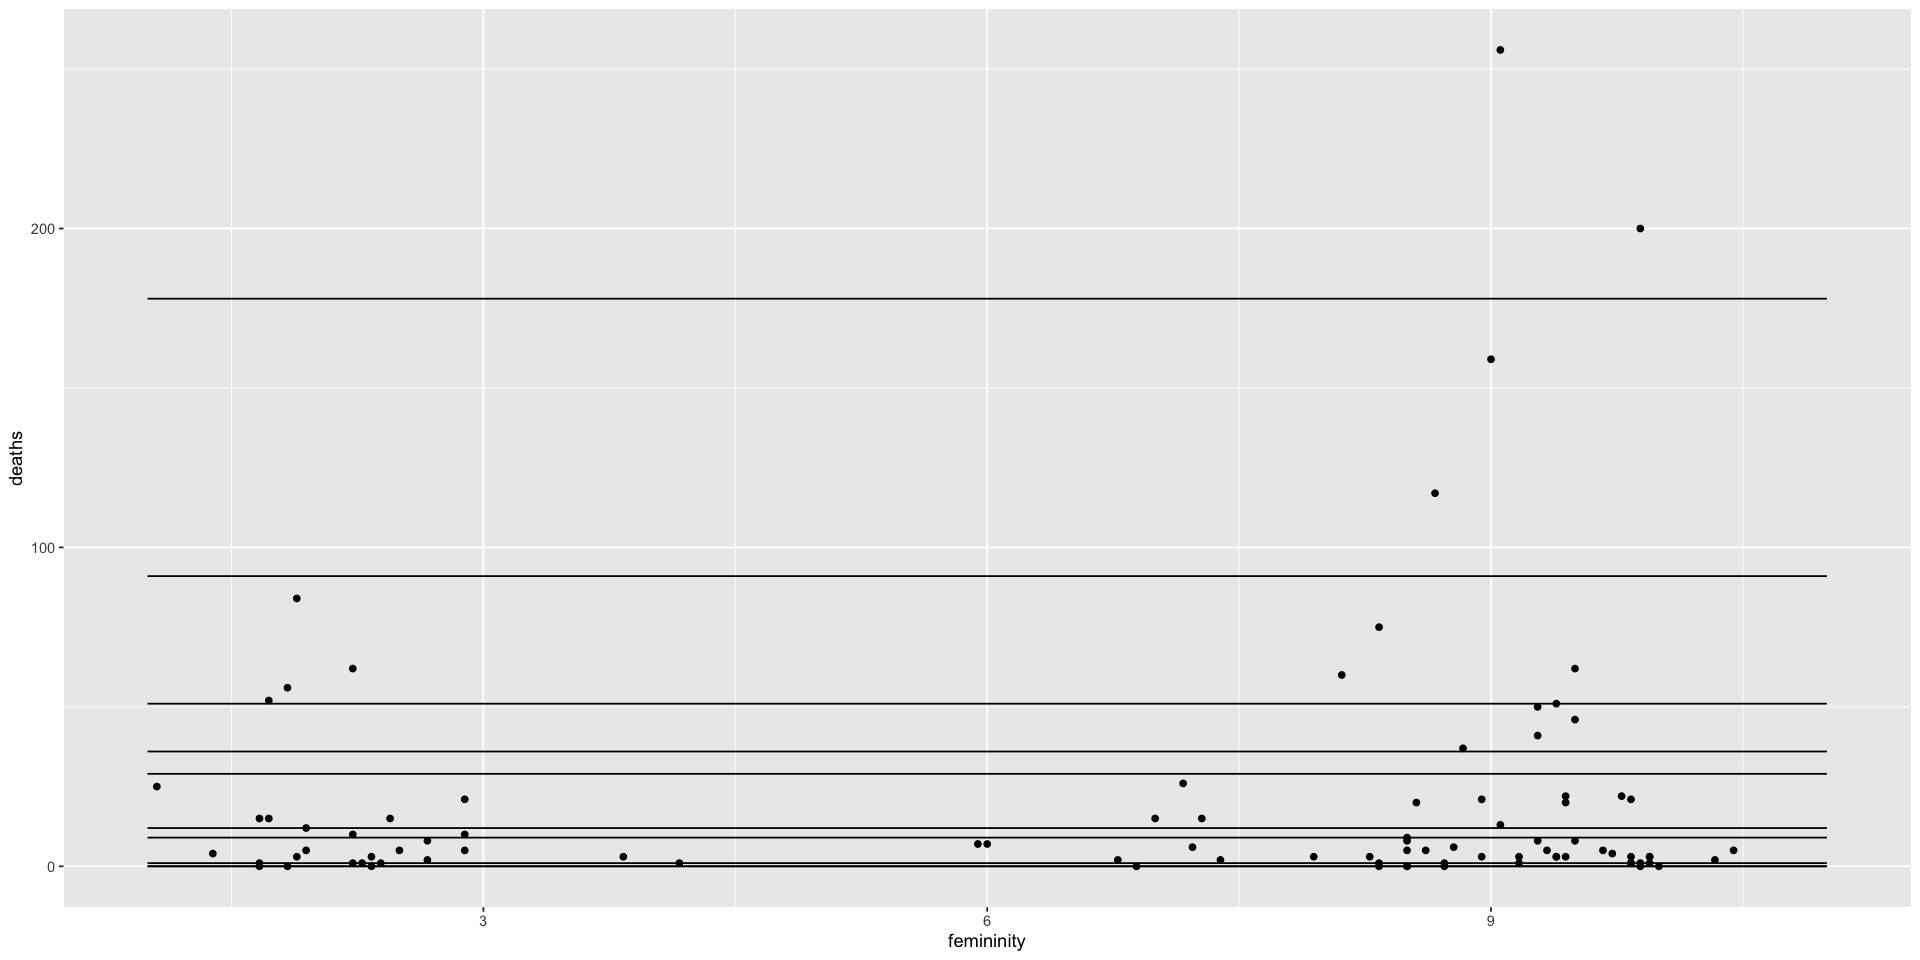

In [6]:
# priors
# initial model is deaths ~ Poisson(lambda), log(lambda) ~ alpha

# figuring out lambda - find the mean number of deaths
mean_deaths <- mean(d$deaths)
log_mean_deaths <- log(mean_deaths)
sd_deaths <- sd(d$deaths)

ALPHA_PRIOR_MEAN <- log_mean_deaths
ALPHA_PRIOR_SD <- 2

NUM_SAMPLES <- 1e1
alpha <- rnorm(NUM_SAMPLES, ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD)
lambda <- exp(alpha)
for (i in 1:NUM_SAMPLES) {
    predicted_deaths <- rpois(1, lambda[i])
    femininities <- seq(1, 11, length.out = 25)
    p <- p + geom_line(data = data.frame(femininity = femininities, deaths = predicted_deaths))
}
print(p)

This looks slightly too wide but generally in the right ballpark. Now for the simple linear model!

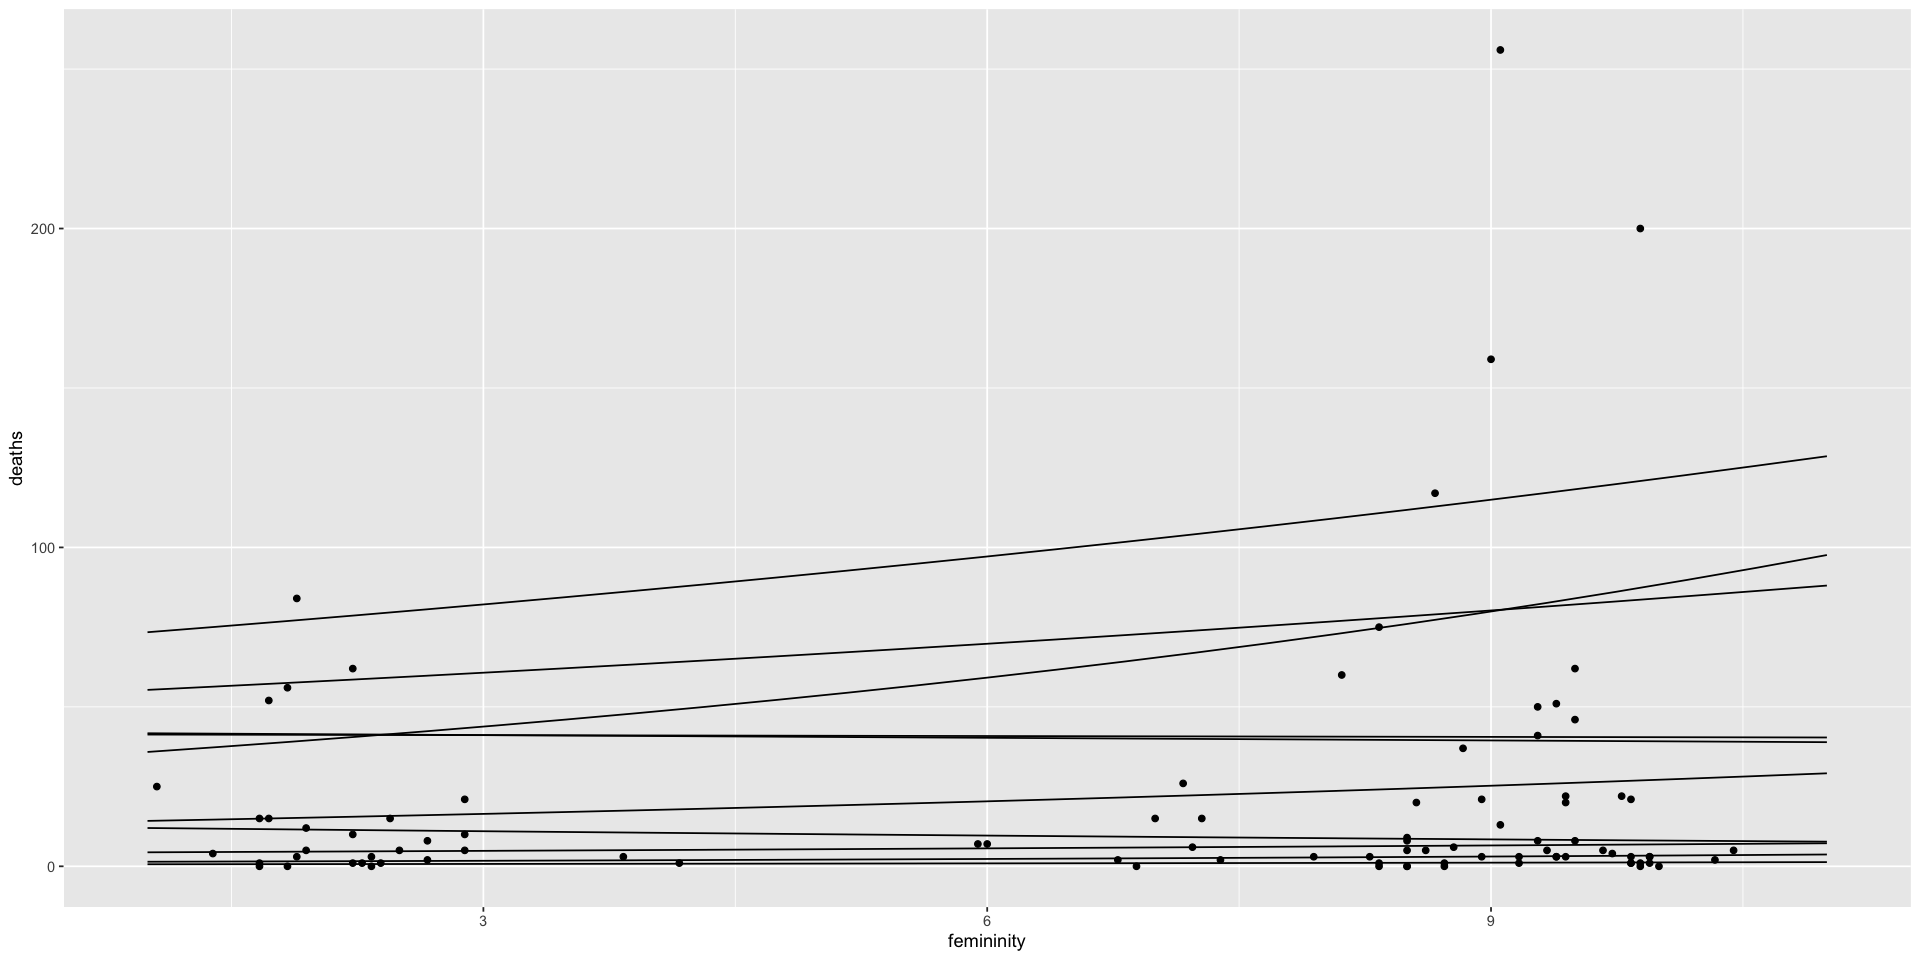

In [7]:
p <- ggplot(d, aes(femininity, deaths)) +
    geom_point()

BETA_F_PRIOR_MEAN <- 0
BETA_F_PRIOR_SD <- 0.05

NUM_SAMPLES <- 1e1
alpha <- rnorm(NUM_SAMPLES, ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD)
beta_f <- rnorm(NUM_SAMPLES, BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD)
femininities <- seq(1, 11, length.out = 25)
for (i in 1:NUM_SAMPLES) {
    # just go with the mean for now
    log_predicted_deaths <- alpha[i] + beta_f[i] * femininities
    predicted_deaths <- exp(log_predicted_deaths)
    p <- p + geom_line(data = data.frame(femininity = femininities, deaths = predicted_deaths))
}
print(p)


In [8]:
# intercept-only Poisson
hurricane_data <- list(
    deaths = d$deaths,
    femininity = d$femininity,
    ALPHA_PRIOR_MEAN = ALPHA_PRIOR_MEAN,
    ALPHA_PRIOR_SD = ALPHA_PRIOR_SD
)
m12h1.intercept <- ulam(
    alist(
        deaths ~ dpois(lambda),
        log(lambda) <- alpha,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD)
    ),
    data = hurricane_data,
    log_lik = TRUE
)

pre <- precis(m12h1.intercept)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.


          mean         sd     5.5%    94.5%     rhat ess_bulk
alpha 3.029668 0.02216972 2.994572 3.062744 1.009995 150.8799


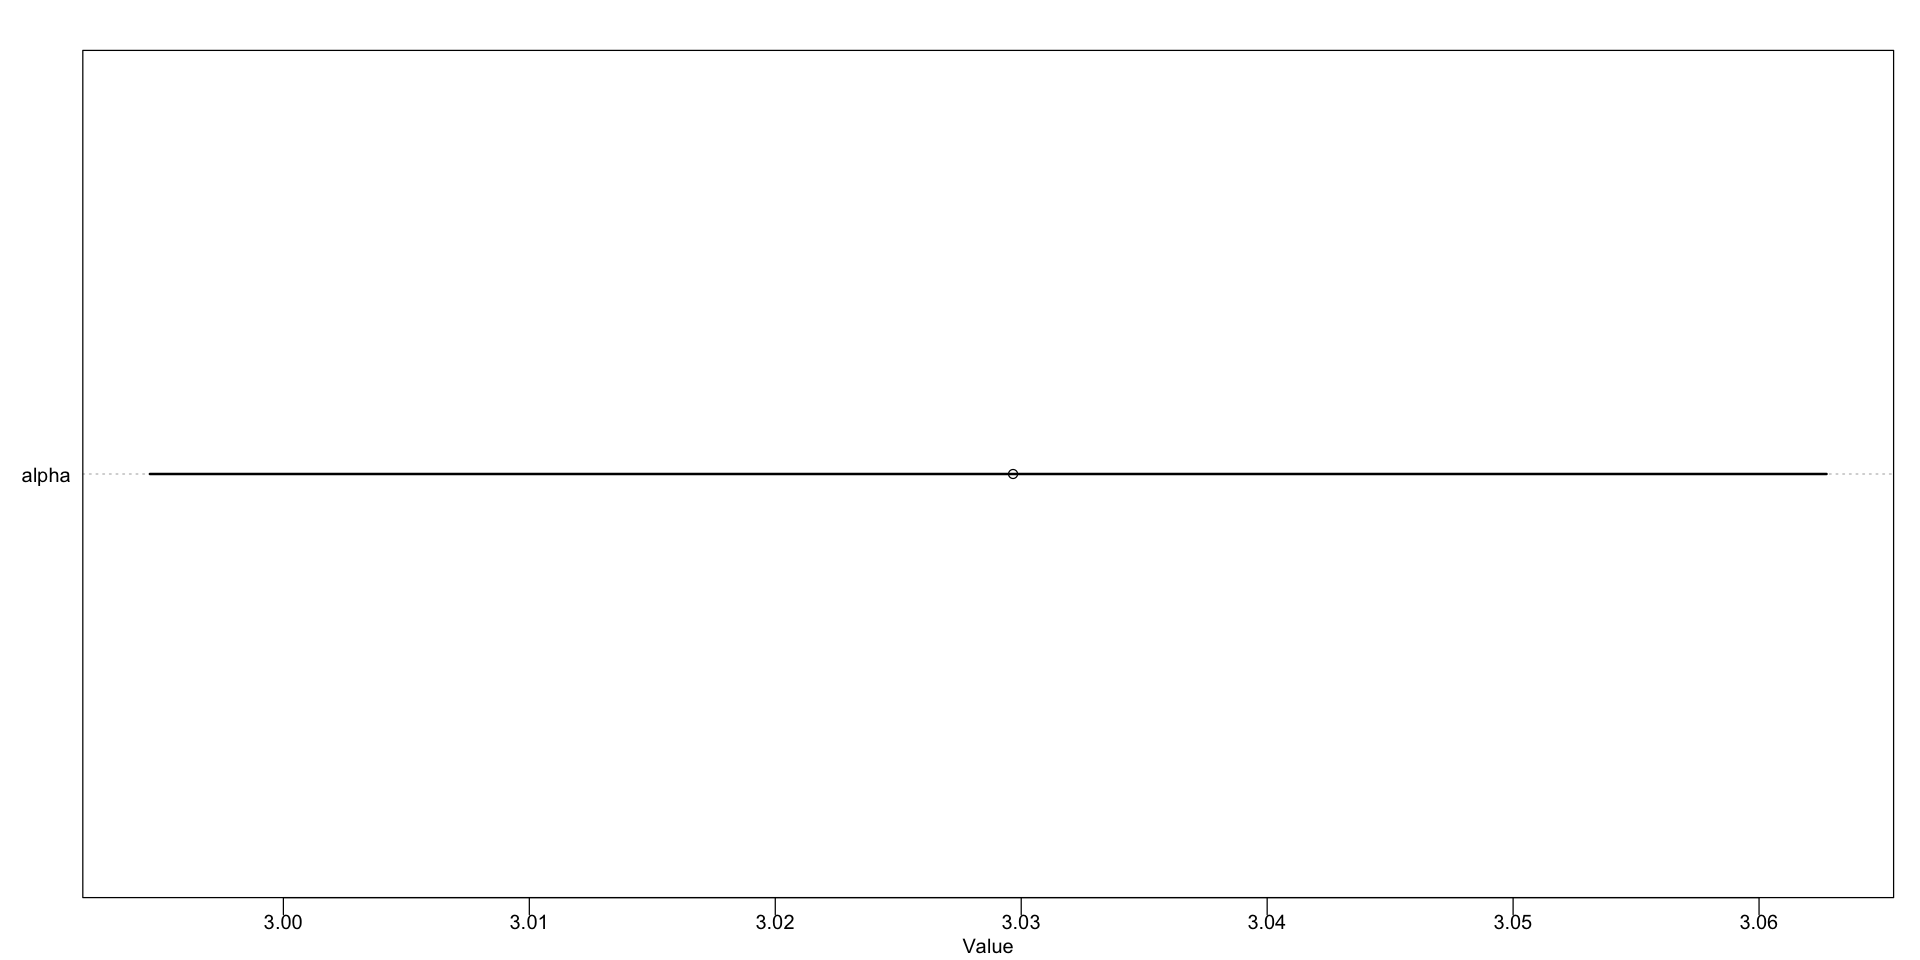

In [9]:
par(bg = 'white')
print(pre)
plot(pre)

In [10]:
# intercept and slope Poisson
hurricane_data <- list(
    deaths = d$deaths,
    femininity = d$femininity,
    ALPHA_PRIOR_MEAN = ALPHA_PRIOR_MEAN,
    ALPHA_PRIOR_SD = ALPHA_PRIOR_SD,
    BETA_F_PRIOR_MEAN = BETA_F_PRIOR_MEAN,
    BETA_F_PRIOR_SD = BETA_F_PRIOR_SD
)
m12h1.intercept_slope <- ulam(
    alist(
        deaths ~ dpois(lambda),
        log(lambda) <- alpha + bf * femininity,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        bf ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD)
    ),
    data = hurricane_data,
    log_lik = TRUE
)
pre.slope <- precis(m12h1.intercept_slope)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.


            mean         sd       5.5%      94.5%     rhat ess_bulk
alpha 2.50723104 0.06217910 2.40662470 2.60359315 1.014877 93.25997
bf    0.07272826 0.00761685 0.06109565 0.08517655 1.012791 90.85604


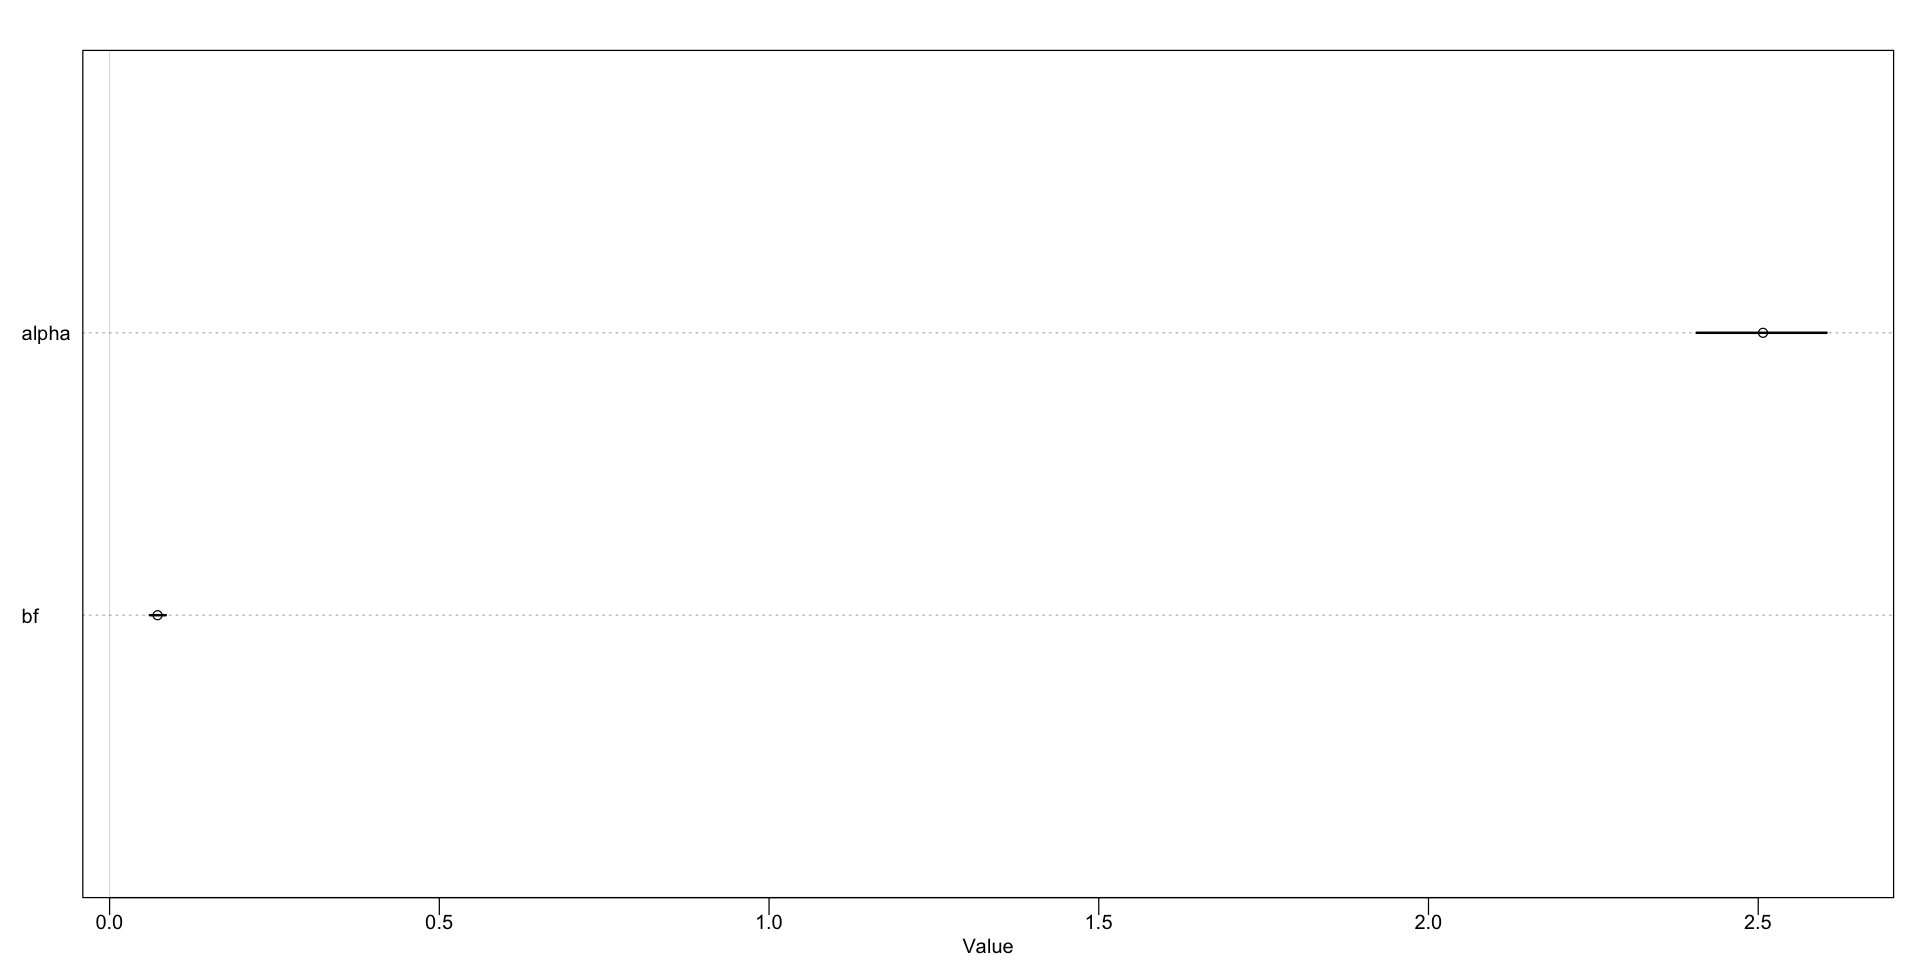

In [11]:
par(bg = 'white')
print(pre.slope)
plot(pre.slope)

So according to this, there is a positive relation between the femininity of the names and the deaths ($\beta_f > 0$). Now let's compare the models: 

In [12]:
compare(m12h1.intercept, m12h1.intercept_slope)

WAIC     SE      dWAIC    dSE      pWAIC     weight     
m12h1.intercept_slope 4432.122 1008.63  0.00000       NA 141.11763 0.997673315
m12h1.intercept       4444.244 1071.62 12.12196 135.2889  74.68958 0.002326685

So the model with the intercept does significantly better than the one without.

Now let's see which hurricanes this does a good job predicting (or not):

In [13]:
femininity_sims <- list(femininity = seq(1, 11, length.out = 100))
simulated_deaths <- link(m12h1.intercept_slope, data = femininity_sims)
simulated_deaths

[,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]    
 [1,] 14.00478 14.10134 14.19858 14.29648 14.39506 14.49431 14.59426 14.69489
 [2,] 13.31275 13.40450 13.49688 13.58989 13.68355 13.77785 13.87280 13.96840
 [3,] 12.30156 12.40806 12.51548 12.62383 12.73311 12.84334 12.95453 13.06668
 [4,] 12.05946 12.16095 12.26330 12.36650 12.47058 12.57553 12.68137 12.78809
 [5,] 12.22978 12.33046 12.43198 12.53433 12.63753 12.74158 12.84648 12.95224
 [6,] 12.46642 12.56760 12.66961 12.77244 12.87610 12.98061 13.08597 13.19218
 [7,] 12.63714 12.74030 12.84430 12.94916 13.05487 13.16144 13.26888 13.37720
 [8,] 12.54362 12.64603 12.74928 12.85338 12.95832 13.06412 13.17078 13.27832
 [9,] 13.28748 13.38469 13.48261 13.58124 13.68060 13.78068 13.88150 13.98305
[10,] 13.44959 13.54896 13.64907 13.74992 13.85151 13.95385 14.05695 14.16081
[11,] 13.91555 14.00524 14.09551 14.18637 14.27781 14.36984 14.46246 14.55568
[12,] 14.13135 14.22685 14.32299 14.41978 14.51722 14.61532 14.71409 14.81352
[13,] 12.38555 12.48997 12.59526 12.70144 12.80852 12.91650 13.02539 13.13520
[14,] 12.05425 12.15507 12.25673 12.35925 12.46262 12.56685 12.67196 12.77795
[15,] 12.89801 13.00122 13.10525 13.21012 13.31582 13.42238 13.52978 13.63804
[16,] 12.75343 12.85185 12.95104 13.05099 13.15171 13.25321 13.35549 13.45856
[17,] 12.64867 12.74326 12.83856 12.93457 13.03130 13.12876 13.22694 13.32586
[18,] 12.79853 12.89187 12.98589 13.08060 13.17600 13.27209 13.36889 13.46639
[19,] 13.30541 13.40025 13.49578 13.59198 13.68887 13.78645 13.88472 13.98370
[20,] 12.88987 12.98561 13.08206 13.17923 13.27712 13.37574 13.47508 13.57517
[21,] 12.62513 12.72626 12.82819 12.93094 13.03451 13.13891 13.24415 13.35023
[22,] 12.56292 12.66145 12.76075 12.86082 12.96169 13.06334 13.16579 13.26905
[23,] 12.51502 12.61385 12.71345 12.81385 12.91503 13.01702 13.11981 13.22341
[24,] 12.40330 12.50085 12.59916 12.69824 12.79811 12.89876 13.00020 13.10244
[25,] 12.45964 12.55711 12.65535 12.75435 12.85412 12.95468 13.05602 13.15816
[26,] 12.51069 12.60847 12.70702 12.80633 12.90642 13.00729 13.10895 13.21140
[27,] 11.90637 12.00388 12.10220 12.20132 12.30125 12.40200 12.50358 12.60598
[28,] 13.39794 13.49223 13.58719 13.68281 13.77911 13.87609 13.97375 14.07209
[29,] 13.48614 13.58675 13.68811 13.79023 13.89311 13.99675 14.10117 14.20637
[30,] 13.46219 13.56327 13.66511 13.76771 13.87108 13.97523 14.08016 14.18588
[31,] ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
[32,] 13.68522 13.77110 13.85753 13.94449 14.03200 14.12007 14.20868 14.29785
[33,] 13.73340 13.82036 13.90787 13.99594 14.08456 14.17375 14.26350 14.35382
[34,] 14.02388 14.11375 14.20420 14.29523 14.38684 14.47904 14.57183 14.66521
[35,] 14.11660 14.20866 14.30132 14.39458 14.48846 14.58294 14.67804 14.77376
[36,] 13.48968 13.58498 13.68095 13.77761 13.87494 13.97296 14.07168 14.17109
[37,] 13.95851 14.05267 14.14747 14.24290 14.33898 14.43571 14.53309 14.63113
[38,] 13.91141 14.00454 14.09830 14.19269 14.28771 14.38336 14.47966 14.57660
[39,] 13.51143 13.60803 13.70531 13.80330 13.90198 14.00137 14.10147 14.20229
[40,] 13.51824 13.61481 13.71207 13.81002 13.90867 14.00803 14.10810 14.20888
[41,] 13.19992 13.29416 13.38908 13.48467 13.58094 13.67791 13.77556 13.87391
[42,] 13.16424 13.25807 13.35257 13.44774 13.54360 13.64013 13.73735 13.83527
[43,] 13.01347 13.11625 13.21985 13.32426 13.42950 13.53557 13.64248 13.75023
[44,] 13.68498 13.78314 13.88200 13.98158 14.08187 14.18288 14.28461 14.38707
[45,] 12.92110 13.02252 13.12474 13.22775 13.33158 13.43622 13.54168 13.64797
[46,] 12.84310 12.94363 13.04494 13.14704 13.24995 13.35366 13.45818 13.56352
[47,] 14.49333 14.57655 14.66024 14.74441 14.82907 14.91421 14.99984 15.08596
[48,] 14.36094 14.45589 14.55147 14.64769 14.74453 14.84202 14.94016 15.03894
[49,] 13.39131 13.47827 13.56578 13.65387 13.74253 13.83177 13.92158 14.01198
[50,] 13.38094 13.48532 13.59052 13.69654 13.80339 13.91107 14.01960 14.12896
[51,] 12.60422 12.69737 12.7

In [14]:
mean_simulated_deaths <- apply(simulated_deaths, 2, mean)
bounds_simulated_deaths <- apply(simulated_deaths, 2, function(col) PI(col, prob = 0.95))
simulated_df <- data.frame(
    femininity = femininity_sims$femininity,
    mean = mean_simulated_deaths,
    lower = bounds_simulated_deaths[1, ],
    upper = bounds_simulated_deaths[2, ]
)

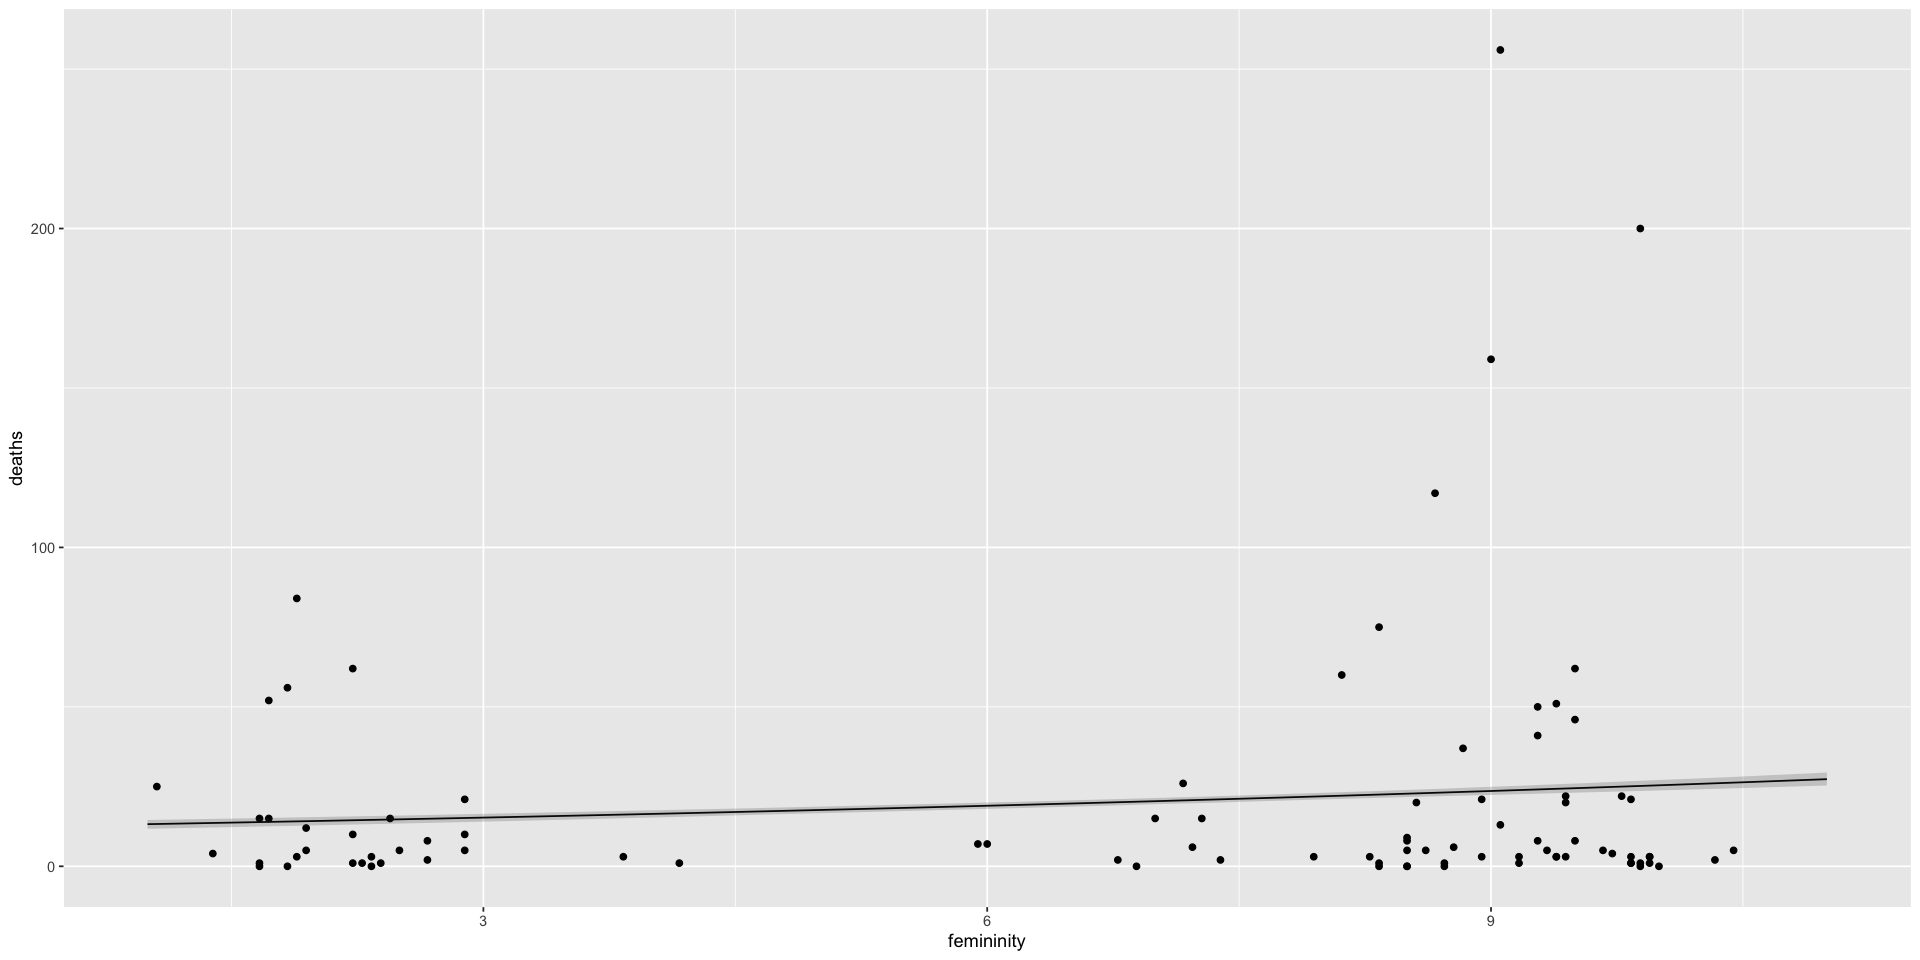

In [15]:
base_plot <- ggplot(d, aes(femininity)) +
    geom_point(aes(y = deaths))
base_plot +
    geom_line(data = simulated_df, mapping = aes(femininity, mean)) +
    geom_ribbon(data = simulated_df, mapping = aes(femininity, ymin = lower, ymax = upper), alpha = 0.2)

So actually this does a pretty terrible job at predicting anything. The model is convinced that everything is going to live in a very narrow band, when in reality there is a tonne more variation. My guess is that some of the hurricanes with large death counts are driving the slight positive trend that we see.

#### 12H2 Counts are nearly always over-dispersed relative to Poisson. So fit a gamma-Poisson (aka negative-binomial) model to predict `deaths` using `femininity`. Show that the over-dispersed model no longer shows as precise a positive association between femininity and deaths, with an 89% interval that overlaps zero. Can you explain why the association diminished in strength?

In [49]:
m12h2 <- ulam(
    alist(
        deaths ~ dgampois(lambda, phi),
        log(lambda) <- alpha + bf * femininity,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        bf ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD),
        phi ~ dexp(1)
    ),
    data = hurricane_data,
    log_lik = TRUE
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e737d4417.stan', line 23, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e737d4417.stan', line 23, column 4 to column 44)

Chain 1 If this warning occurs sporadically, s

Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.


mean       sd         5.5%       94.5%      rhat      ess_bulk
alpha 2.78866568 0.30172792  2.3405157 3.28875375 0.9991627 105.5894
bf    0.03540821 0.03559844 -0.0214341 0.09311813 0.9993022 104.5446
phi   0.44672699 0.06159693  0.3615986 0.55373324 0.9997913 311.8078

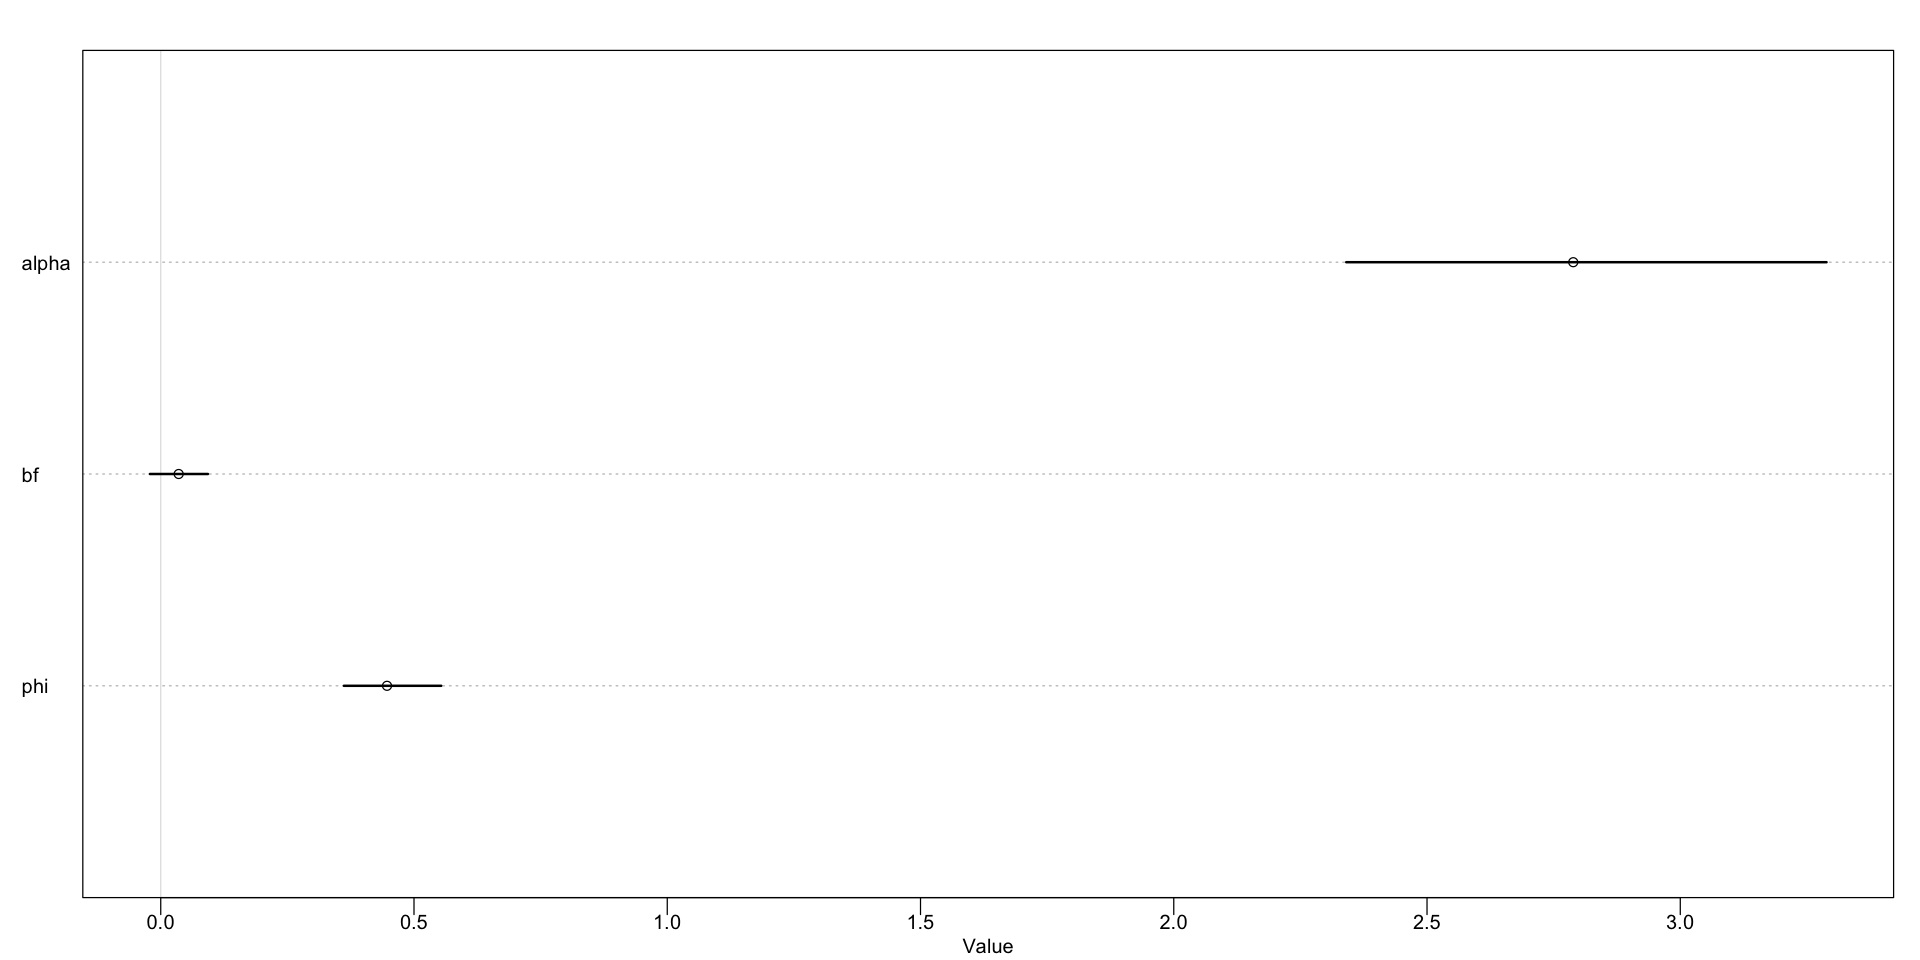

In [17]:
precis(m12h2)
par(bg = 'white')
plot(precis(m12h2))

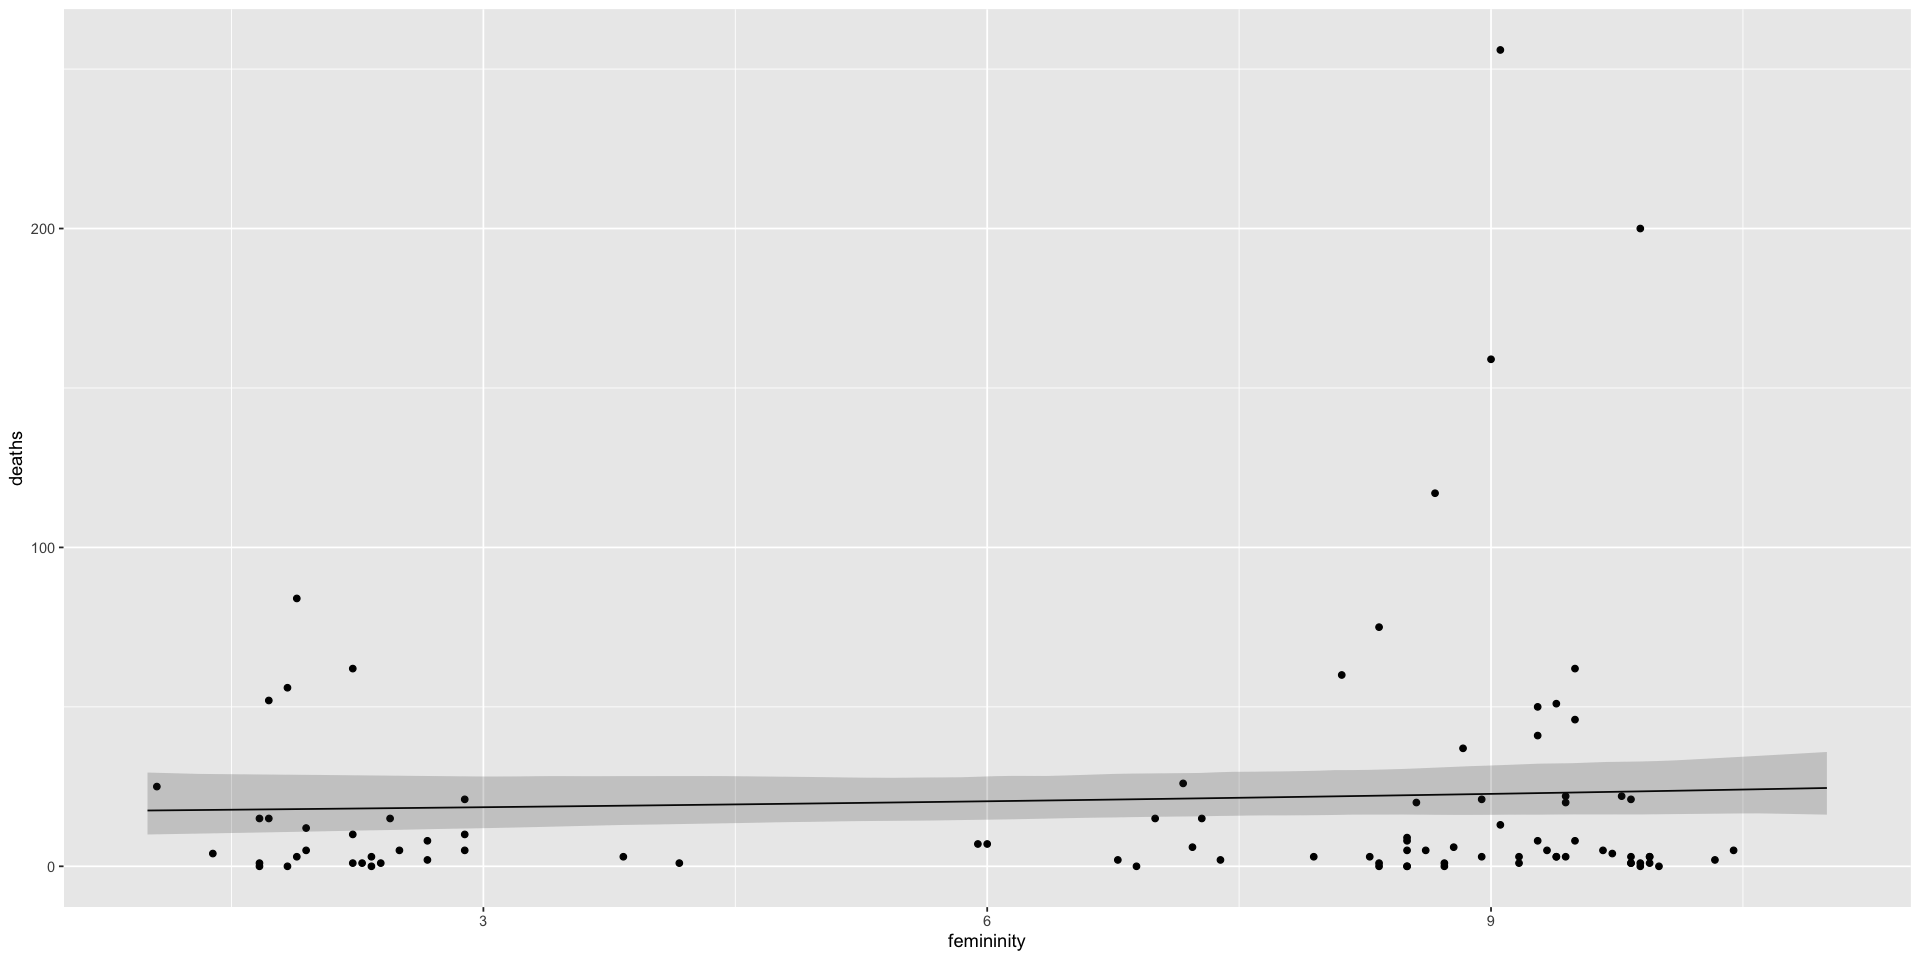

In [18]:

femininity_sims <- list(femininity = seq(1, 11, length.out = 100))
simulated_deaths <- link(m12h2, data = femininity_sims)
mean_simulated_deaths <- apply(simulated_deaths, 2, mean)
bounds_simulated_deaths <- apply(simulated_deaths, 2, function(col) PI(col, prob = 0.95))
simulated_df <- data.frame(
    femininity = femininity_sims$femininity,
    mean = mean_simulated_deaths,
    lower = bounds_simulated_deaths[1, ],
    upper = bounds_simulated_deaths[2, ]
)
base_plot +
    geom_line(data = simulated_df, mapping = aes(femininity, mean)) +
    geom_ribbon(data = simulated_df, mapping = aes(femininity, ymin = lower, ymax = upper), alpha = 0.2)

The over-dispersed model produces a coefficient for femininity that overlaps zero; it is less certain of the effect of the femininity of the name on the deadliness of the hurricane. Looking at the above plot, we can also see that the prediction line is more flat and has wider bars; the model as a whole is less certain about the outcomes.

My suspicion is that some of the effect of femininity that was reported by the previous model was being unduly influenced by the very high-death feminine hurricanes; since the gamma-Poisson model expects more variabiliy, those outliers are less influential.

#### 12H3 In the data, there are two measures of a hurricane's potential to cause death: `damage_norm` and `min_pressure`. Consult `?Hurricanes` for their meaning. It makes some sense to imagine that femininity of a name matters more when the hurricane is itself deadly. This implies an interaction between `femininity` and either both or one of `damage_norm` and `min_pressure`. Fit a series of models evaluating these interactions. Interpret and compare the models. In interpreting the estimates, it may help to generate counterfactual preductions contrasting hurricanes with masculine and feminine names. Are the effect sizes plausible?

In [30]:
# first, let's normalize the data
d$f <- standardize(d$femininity)
d$damage <- standardize(d$damage_norm)
d$min_p <- standardize(d$min_pressure)

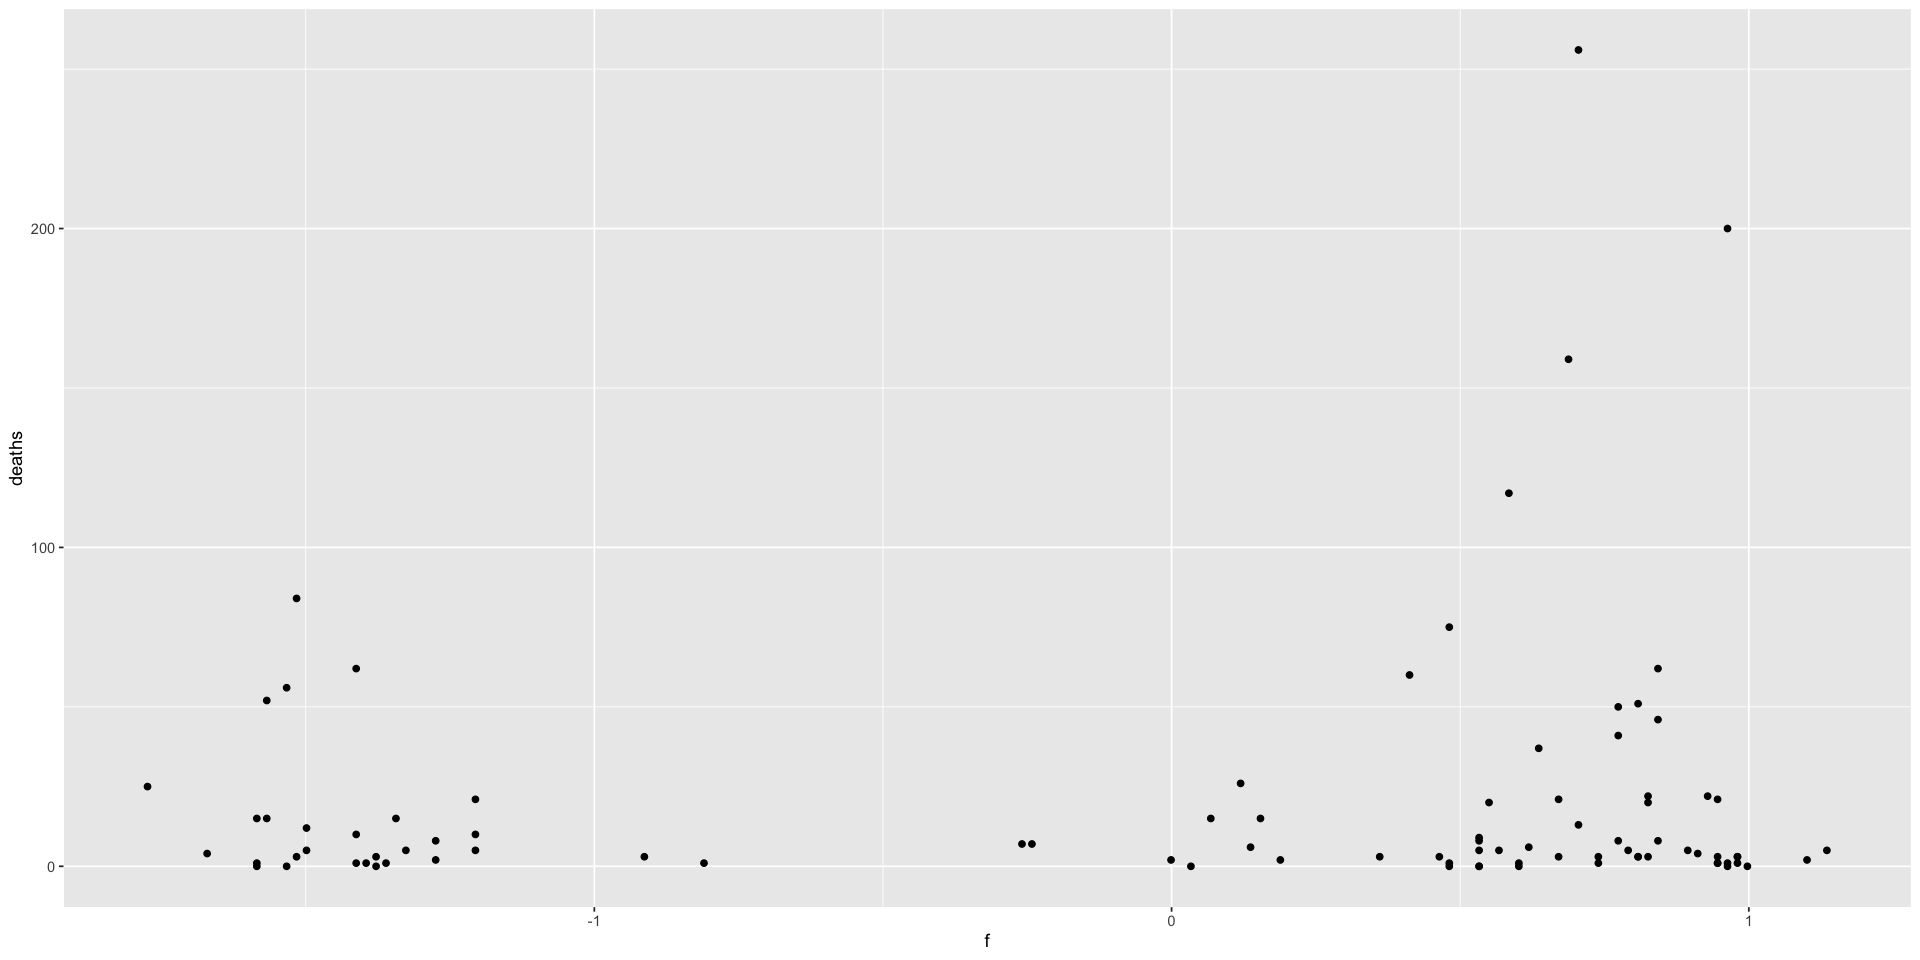

In [31]:
ggplot(d, aes(f, deaths)) +
    geom_point()

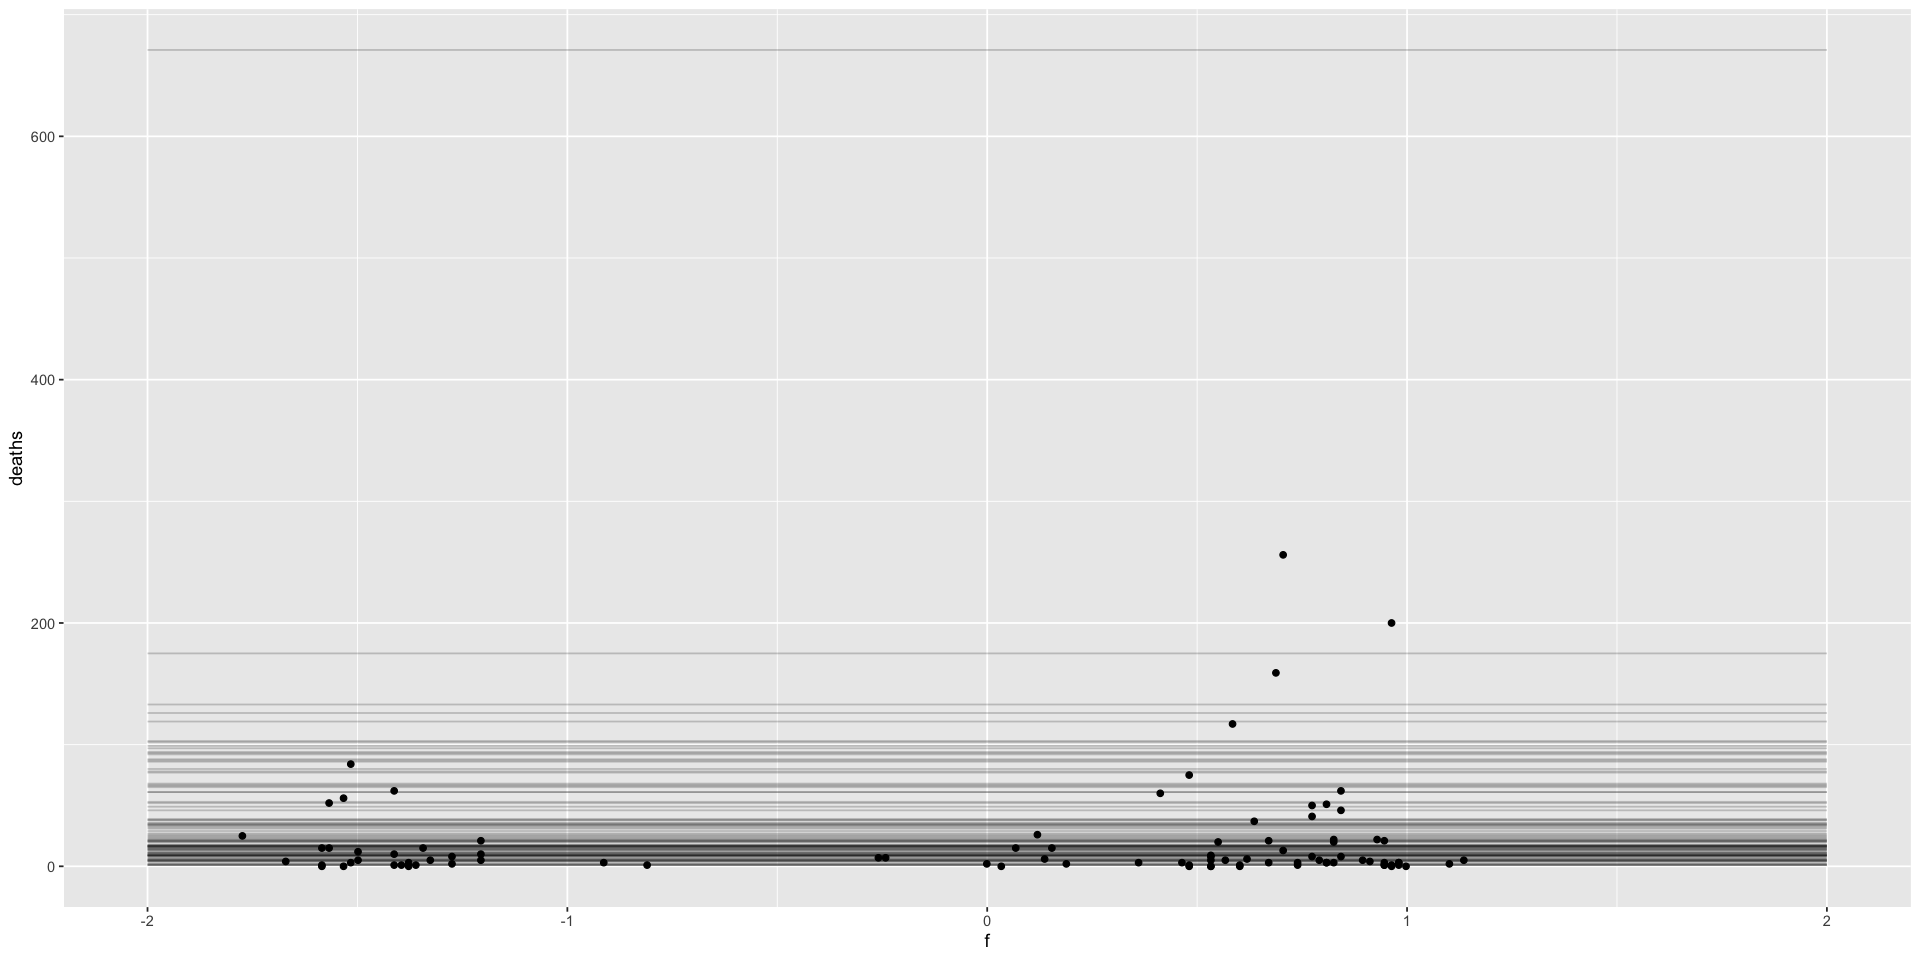

In [37]:
# need to re-figure out the priors

# figuring out lambda - find the mean number of deaths
mean_deaths <- mean(d$deaths)
log_mean_deaths <- log(mean_deaths)
sd_deaths <- sd(d$deaths)

ALPHA_PRIOR_MEAN <- log_mean_deaths
ALPHA_PRIOR_SD <- 1.2

NUM_SAMPLES <- 1e2
alpha <- rnorm(NUM_SAMPLES, ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD)
lambda <- exp(alpha)
p <- ggplot(d) +
    geom_point(mapping = aes(f, deaths))
femininities <- seq(-2, 2, length.out = 25)
for (i in 1:NUM_SAMPLES) {
    predicted_deaths <- rpois(1, lambda[i])
    p <- p + geom_line(data = data.frame(femininity = femininities, deaths = predicted_deaths), mapping = aes(femininity, deaths), alpha = 0.2)
}
print(p)

This looks - decent. Now let's do it for the coefficient!

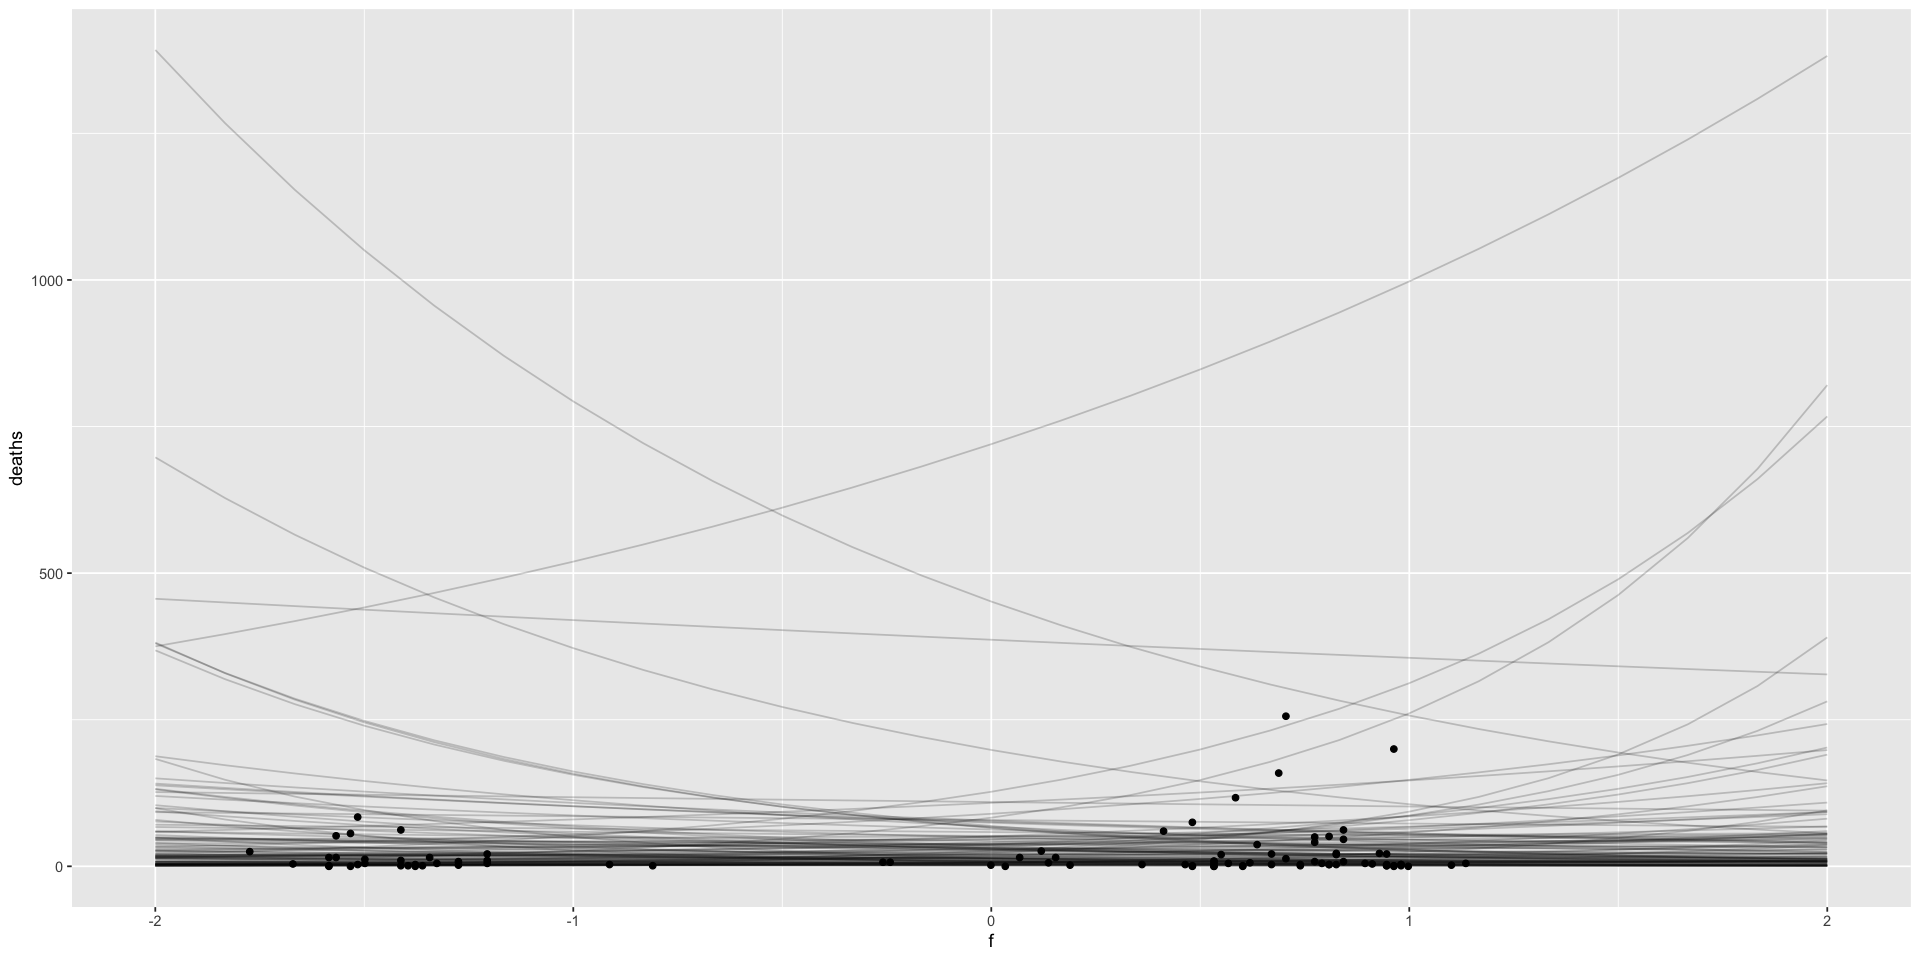

In [41]:
p <- ggplot(d, aes(f, deaths)) +
    geom_point()

BETA_F_PRIOR_MEAN <- 0
BETA_F_PRIOR_SD <- 0.5

NUM_SAMPLES <- 1e2
alpha <- rnorm(NUM_SAMPLES, ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD)
beta_f <- rnorm(NUM_SAMPLES, BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD)
femininities <- seq(-2, 2, length.out = 25)
for (i in 1:NUM_SAMPLES) {
    # just go with the mean for now
    log_predicted_deaths <- alpha[i] + beta_f[i] * femininities
    predicted_deaths <- exp(log_predicted_deaths)
    p <- p + geom_line(data = data.frame(f = femininities, deaths = predicted_deaths), alpha = 0.2)
}
print(p)

This looks reasonable to me! Now we need to grab the priors for the interaction with the pressure. For each, we'll normalize and then use a standard normal as the prior.

In [58]:
interaction_data <- list(
    deaths = d$deaths,
    f = d$f,
    min_p = d$min_p,
    damage = d$damage,
    ALPHA_PRIOR_MEAN = ALPHA_PRIOR_MEAN,
    ALPHA_PRIOR_SD = ALPHA_PRIOR_SD,
    BETA_F_PRIOR_MEAN = BETA_F_PRIOR_MEAN,
    BETA_F_PRIOR_SD = BETA_F_PRIOR_SD
)

m12h3.interaction.damage <- ulam(
    alist(
        deaths ~ dgampois(lambda, phi),
        log(lambda) <- alpha + bf * f + bd * damage + bfd * f * damage,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        c(bf, bd, bfd) ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD),
        phi ~ dexp(1)
    ),
    data = interaction_data,
    log_lik = TRUE
)

m12h3.interaction.pressure <- ulam(
    alist(
        deaths ~ dgampois(lambda, phi),
        log(lambda) <- alpha + bf * f + bp * min_p + bfp * f * min_p,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        c(bf, bp, bfp) ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD),
        phi ~ dexp(1)
    ),
    data = interaction_data,
    log_lik = TRUE
)

m12h3.interaction.both <- ulam(
    alist(
        deaths ~ dgampois(lambda, phi),
        log(lambda) <- alpha + bf * f + bp * min_p + bd * damage + bfp * f * min_p + bfd * f * damage + bfdp * f * damage * min_p,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        c(bf, bp, bd, bfp, bfd, bfdp) ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD),
        phi ~ dexp(1)
    ),
    data = interaction_data,
    log_lik = TRUE
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[6] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e698d0947.stan', line 29, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[6] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e698d0947.stan', line 29, column 4 to column 44)

Chain 1 If this warning occurs sporadically, s

Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e4ddfe002.stan', line 29, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[6] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e431197fd.stan', line 35, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[6] is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e431197fd.stan', line 35, column 4 to column 44)

Chain 1 If this warning occurs sporadically, s

Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.


In [59]:
precis(m12h3.interaction.damage)
precis(m12h3.interaction.pressure)
precis(m12h3.interaction.both)

mean       sd         5.5%        94.5%     rhat      ess_bulk
alpha 2.61433378 0.13837266  2.38989150 2.8390660 0.9996039 581.0906
bfd   0.25830503 0.18682629 -0.02884759 0.5438960 0.9996826 458.9965
bd    1.08969349 0.19421609  0.77856073 1.4249276 1.0006224 521.7022
bf    0.08778099 0.12790136 -0.13406371 0.2814921 0.9983161 570.0617
phi   0.67874777 0.09880588  0.52795211 0.8570944 1.0026591 587.4929

mean       sd         5.5%        94.5%      rhat      ess_bulk
alpha  2.7911227 0.14717601  2.56972995  3.0428996 1.0162246 441.7437
bfp    0.2818387 0.14899581  0.04163392  0.5178375 1.0067644 338.1521
bp    -0.6386338 0.13936584 -0.85106235 -0.4119867 1.0067224 366.8670
bf     0.2710867 0.14174754  0.04257546  0.4922371 1.0017188 479.7444
phi    0.5539437 0.07724629  0.43689565  0.6781608 0.9981852 510.7184

mean       sd        5.5%        94.5%      rhat      ess_bulk
alpha  2.5082621 0.1266655  2.30908340  2.7055851 1.0003951 404.8259
bfdp   0.2247412 0.1585285 -0.01511904  0.5005359 0.9992367 355.0469
bfd    0.6506117 0.2228505  0.28548739  0.9827494 1.0051615 277.6539
bfp    0.3165563 0.1561880  0.06606444  0.5678708 0.9991921 343.5489
bd     0.7502954 0.1921671  0.44715346  1.0737409 0.9984966 322.7159
bp    -0.5740349 0.1553959 -0.80851742 -0.3199118 0.9996471 336.2870
bf     0.1707738 0.1229147 -0.02790241  0.3579449 1.0007921 571.0509
phi    0.7593086 0.1183038  0.58668506  0.9539645 1.0111270 374.7947

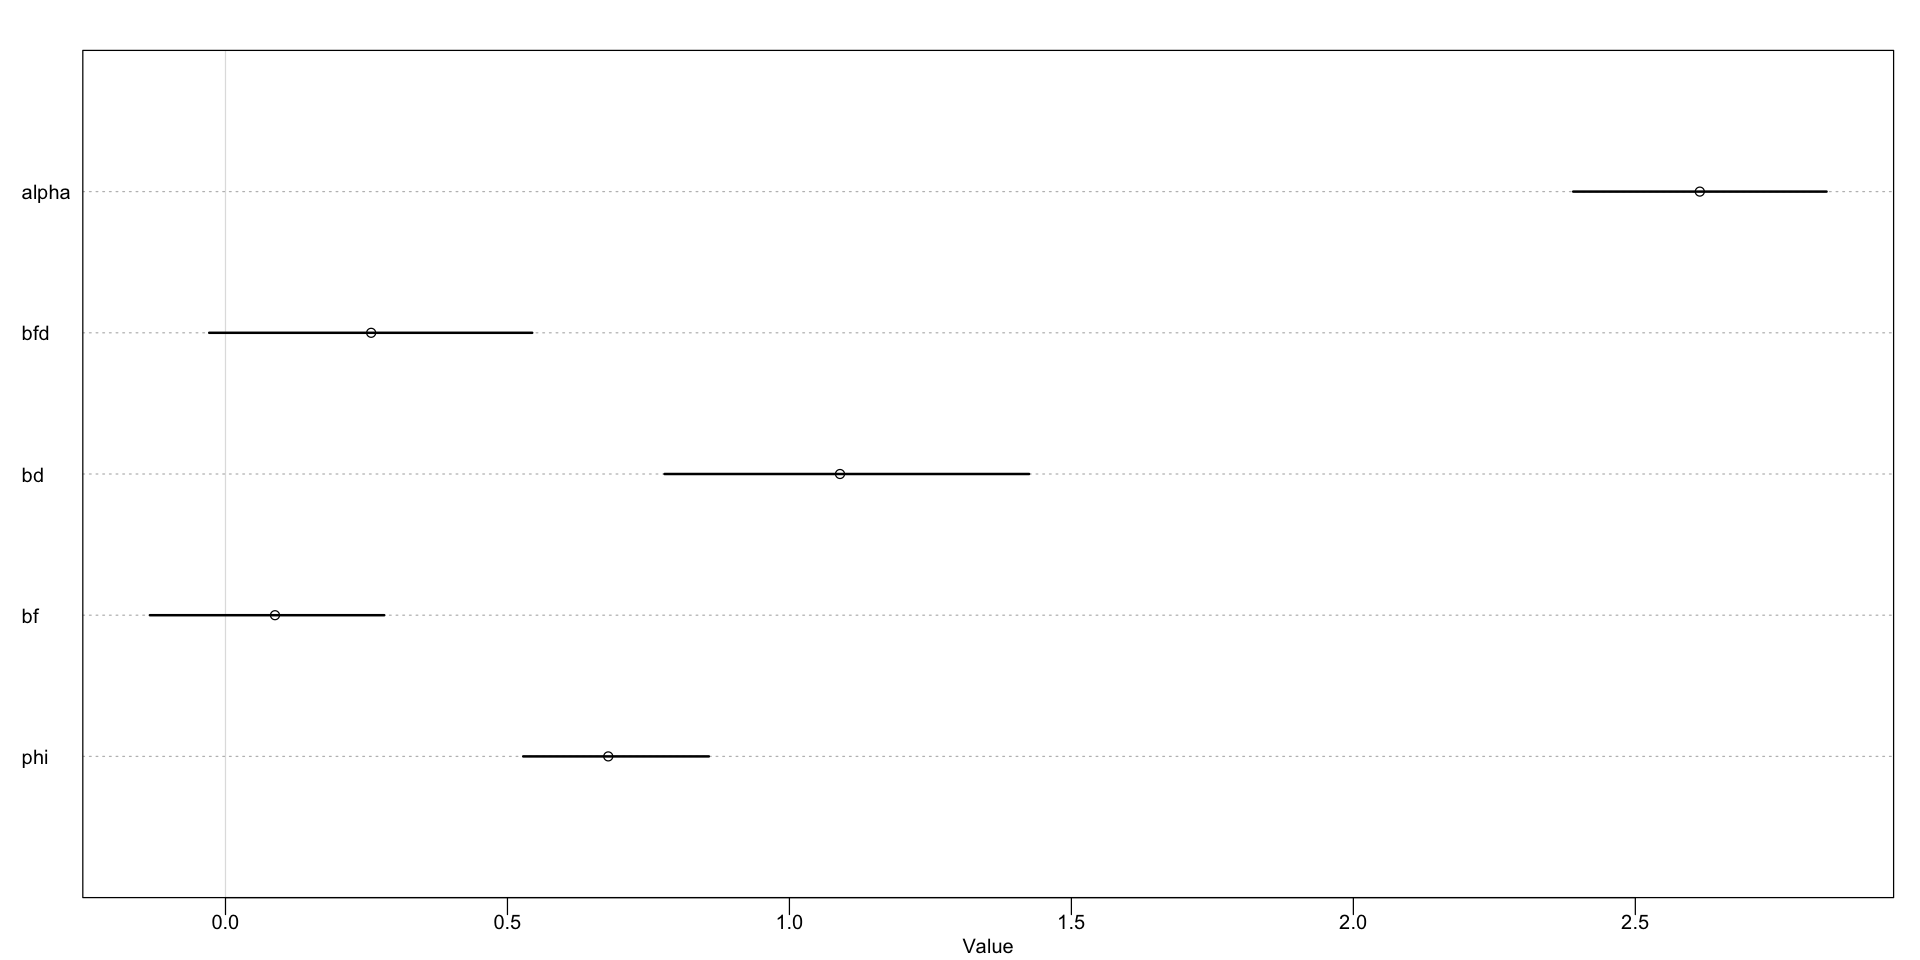

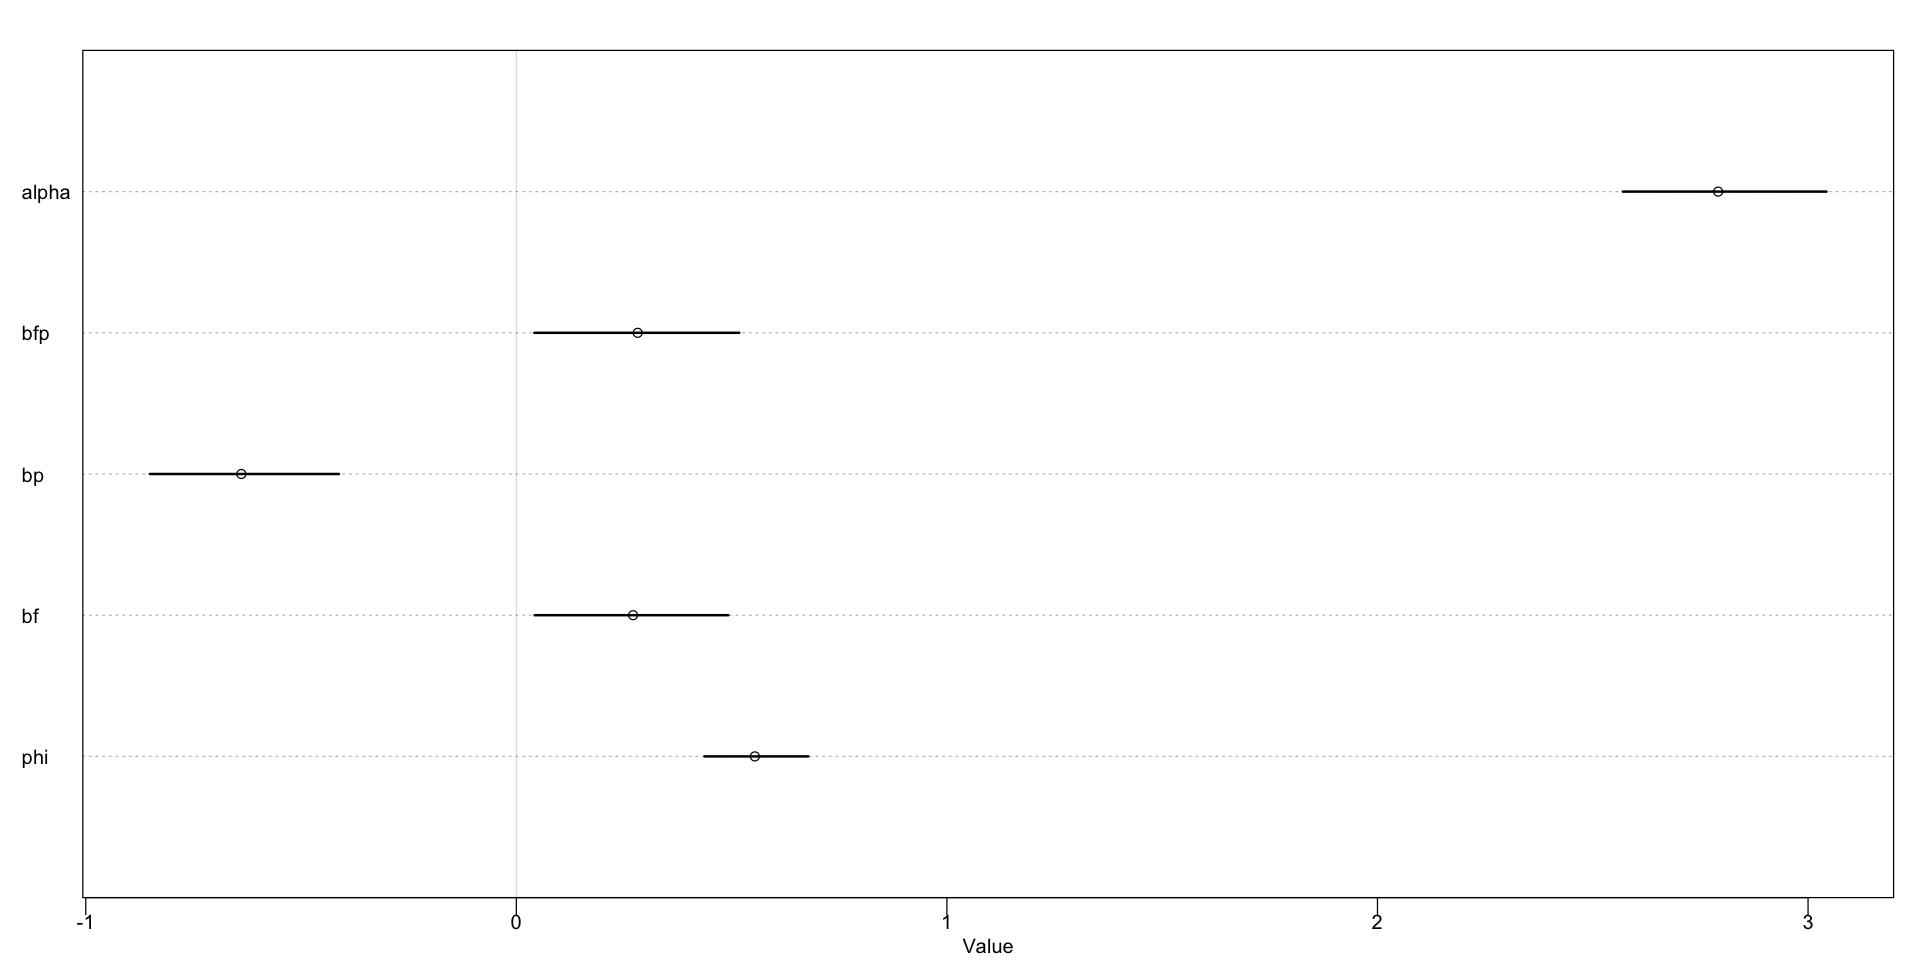

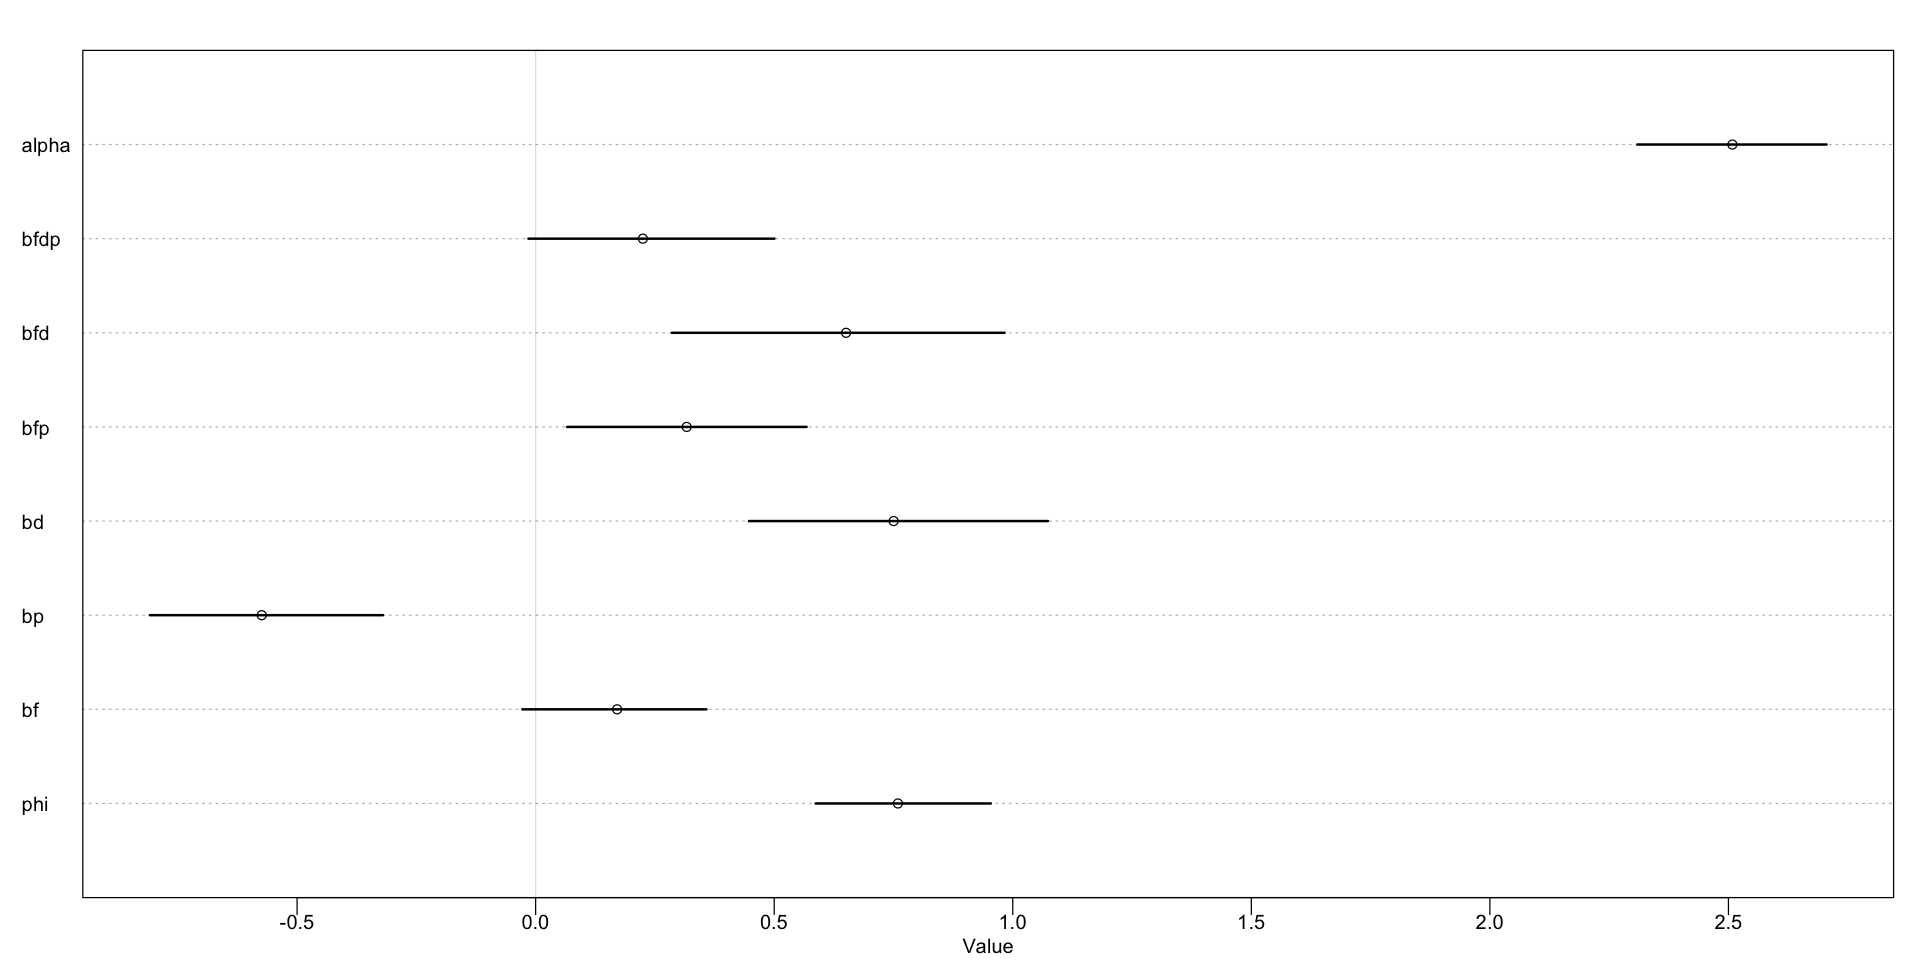

In [60]:
par(bg = 'white')
plot(precis(m12h3.interaction.damage))
plot(precis(m12h3.interaction.pressure))
plot(precis(m12h3.interaction.both))

So when we control for only damage (and the interaction with femininity), it looks like just the damage coefficient is relevant. 

If we control for pressure, everything is relevant.

If we control for both then once again femininity becomes less important and it's the other factors (damage and pressure) that are influential.

In [63]:
compare(m12h3.interaction.both, m12h3.interaction.damage, m12h3.interaction.pressure, func = PSIS)

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



PSIS     SE       dPSIS     dSE       pPSIS    
m12h3.interaction.both     665.2222 35.51491  0.000000        NA 10.740911
m12h3.interaction.damage   670.4155 32.77044  5.193271  8.623984  6.097415
m12h3.interaction.pressure 694.6520 38.26552 29.429744 13.285127  8.393696
                           weight      
m12h3.interaction.both     9.306444e-01
m12h3.interaction.damage   6.935525e-02
m12h3.interaction.pressure 3.786135e-07

From this is looks like the model including both interactions is the best, but not by much.

Now let's see what the model (both interactions) predicts when we change the femininity.

In [77]:
NUM_SAMPLES <- 100
damage_seq <- seq(-2, 2, length.out = NUM_SAMPLES)
pressure_seq <- seq(-2, 2, length.out = NUM_SAMPLES)

male_storm_data <- list(
    damage = rep(0, NUM_SAMPLES),
    min_p = pressure_seq,
    f = rep(-1, NUM_SAMPLES)
)
male_storm_prediction <- link(m12h3.interaction.both, data = male_storm_data)
mean_male_death <- apply(male_storm_prediction, 2, mean)
bounds_male_death <- apply(male_storm_prediction, 2, PI)

female_storm_data <- list(
    damage = rep(0, NUM_SAMPLES),
    min_p = pressure_seq,
    f = rep(1, NUM_SAMPLES)
)
female_storm_prediction <- link(m12h3.interaction.both, data = female_storm_data)
mean_female_death <- apply(female_storm_prediction, 2, mean)
bounds_female_death <- apply(female_storm_prediction, 2, PI)

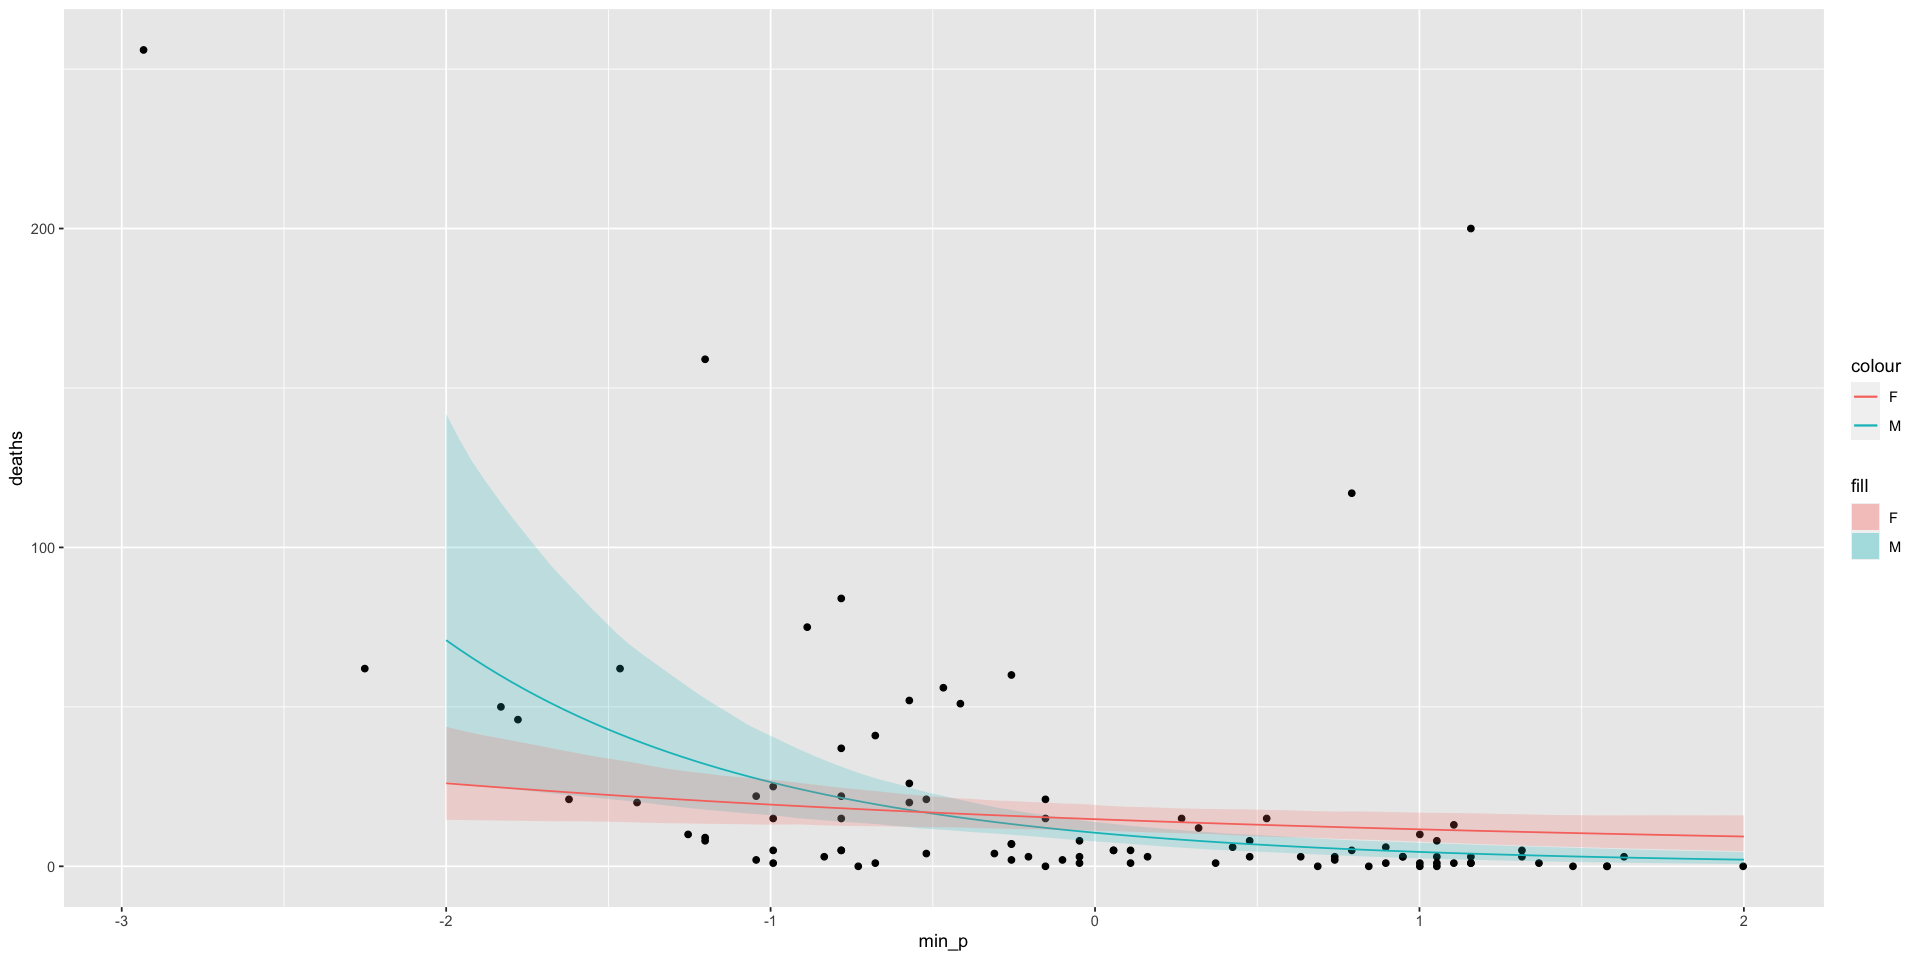

In [85]:
ggplot(d, aes(min_p)) +
    geom_point(mapping = aes(y = deaths)) +
    # male storms
    geom_line(data = data.frame(min_p = pressure_seq, deaths = mean_male_death), mapping = aes(min_p, deaths, colour = "M")) +
    geom_ribbon(data = data.frame(min_p = pressure_seq, death_min = bounds_male_death[1, ], death_max = bounds_male_death[2, ]), mapping = aes(x = min_p, ymin = death_min, ymax = death_max, fill = "M"), alpha = 0.2) +
    # female storms
    geom_line(data = data.frame(min_p = pressure_seq, deaths = mean_female_death), mapping = aes(min_p, deaths, colour = "F")) +
    geom_ribbon(data = data.frame(min_p = pressure_seq, death_min = bounds_female_death[1, ], death_max = bounds_female_death[2, ]), mapping = aes(x = min_p, ymin = death_min, ymax = death_max, fill = "F"), alpha = 0.2)

(NB I only did the predictions over pressure mostly due to laziness).

So this prediction tells us a slightly different story: at low pressures we expect male storms to be deadlier but at high pressures (= not as severe) we expect the female ones to be deadler (albeit not by much). Interesting!

#### 12H4 In the original hurricanes paper, storm damage (`damage_norm`) was used directly. This assumption implies that mortality encreases exponentially with a linear increase in storm strength, because a Poisson regression uses a log link. So, it's worth exploring an alternative hypothesis: that the logarithm of storm strength is what matters. Explore this by using the logarithm of `damage_norm` as a predictor. Using the best model structure from the previous problem, compare a model that uses `log(damage_norm)` to a model that uses `damage_norm` directly. Compare their PSIS / WAIC values as well as their implied predictions. What do you conclude?

In [86]:
head(d)

name     year deaths category min_pressure damage_norm female femininity
1 Easy     1950  2     3        960           1590       1      6.77778   
2 King     1950  4     3        955           5350       0      1.38889   
3 Able     1952  3     1        985            150       0      3.83333   
4 Barbara  1953  1     1        987             58       1      9.83333   
5 Florence 1953  0     1        985             15       1      8.33333   
6 Carol    1954 60     3        960          19321       1      8.11111   
  F             f             damage     min_p     
1 -0.0009347453 -0.0009347453 -0.4391329 -0.2576952
2 -1.6707580424 -1.6707580424 -0.1484282 -0.5199513
3 -0.9133139565 -0.9133139565 -0.5504666  1.0535855
4  0.9458703621  0.9458703621 -0.5575796  1.1584879
5  0.4810742824  0.4810742824 -0.5609041  1.0535855
6  0.4122162926  0.4122162926  0.9317409 -0.2576952

In [96]:
d$l_damage_norm <- log(d$damage_norm)
d$n_l_damage_norm <- standardize(d$l_damage_norm)
summary(d$n_l_damage_norm)
d$n_l_damage_norm

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.01162 -0.70257  0.09833  0.00000  0.76946  1.70051 

[1]  0.082783429  0.592129460 -0.908257230 -1.307129497 -1.874837733
 [6]  1.131168033  0.380302125  1.226725338  0.185336570  1.017278894
[11]  0.654027253  0.069370768 -0.370546079 -0.466165349 -0.394540071
[16]  1.556901409 -1.519158547  1.048041787 -0.617287505  0.670621531
[21]  1.058762397  0.315809213 -0.205554434  1.145667123 -0.243992563
[26] -1.082682544  0.568735056 -0.205554434  1.205065891  0.697102959
[31] -0.617287505 -0.402852829 -0.787493883  1.154596752 -0.042403358
[36]  0.653349641 -0.347849710 -1.252888921 -1.228188822  0.305064699
[41]  0.957339449  0.205522217  0.871161492 -0.486158679 -0.968328185
[46] -0.881165212  0.488533778  0.352082247  0.540424516  0.001469043
[51] -2.259478787 -1.307129497 -3.011624614 -2.429685164 -0.631518718
[56]  1.146086694 -0.728824534  0.428153706  1.651470126 -1.095599888
[61]  0.098332635  0.736723301 -0.261608319  0.774451930 -0.787493883
[66]  0.098332635 -0.881165212  0.456186855 -1.104437701  0.767792672
[71]  0.038261680 -0.014866893 -0.693822554  0.562045184 -2.336013835
[76]  1.156237323  0.952379400 -0.855716173  1.114977606  0.863421504
[81] -0.552578044  0.297218105 -1.118053399  0.882706683  1.255156232
[86] -1.361120574 -0.068074797  0.506232068  1.153362102  0.711517442
[91]  1.222202171  1.700514554
attr(,"scaled:center")
[1] 7.174283
attr(,"scaled:scale")
[1] 2.382197

In [99]:
interaction_data[['log_damage']] <- d$n_l_damage_norm

m12h3.interaction.both.log_norm_damage <- ulam(
    alist(
        deaths ~ dgampois(lambda, phi),
        log(lambda) <- alpha + bf * f + bp * min_p + bd * log_damage + bfp * f * min_p + bfd * f * log_damage + bfdp * f * log_damage * min_p,
        alpha ~ dnorm(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SD),
        c(bf, bp, bd, bfp, bfd, bfdp) ~ dnorm(BETA_F_PRIOR_MEAN, BETA_F_PRIOR_SD),
        phi ~ dexp(1)
    ),
    data = interaction_data,
    log_lik = TRUE
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[5] is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e42e799dc.stan', line 36, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[5] is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e42e799dc.stan', line 36, column 4 to column 44)

Chain 1 If this warning occurs sporadically, such 

Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.


mean        sd        5.5%       94.5%      rhat      ess_bulk
alpha  2.29386676 0.1202504  2.1096958 2.49318610 1.0044328 380.7294
bfdp  -0.02359698 0.1317901 -0.2271794 0.20111247 1.0026978 302.7689
bfd    0.20444878 0.1977236 -0.1097949 0.52791755 1.0204603 289.2747
bfp    0.05473029 0.1868201 -0.2398280 0.35589775 1.0078622 283.5645
bd     1.20157472 0.1665740  0.9499617 1.48735000 1.0056547 310.1423
bp    -0.14723247 0.1557312 -0.3852782 0.08627849 1.0090310 326.4621
bf     0.01710455 0.1455624 -0.2067255 0.26036785 0.9985165 273.7513
phi    1.00267347 0.1523869  0.7726367 1.25177535 0.9982541 428.8417

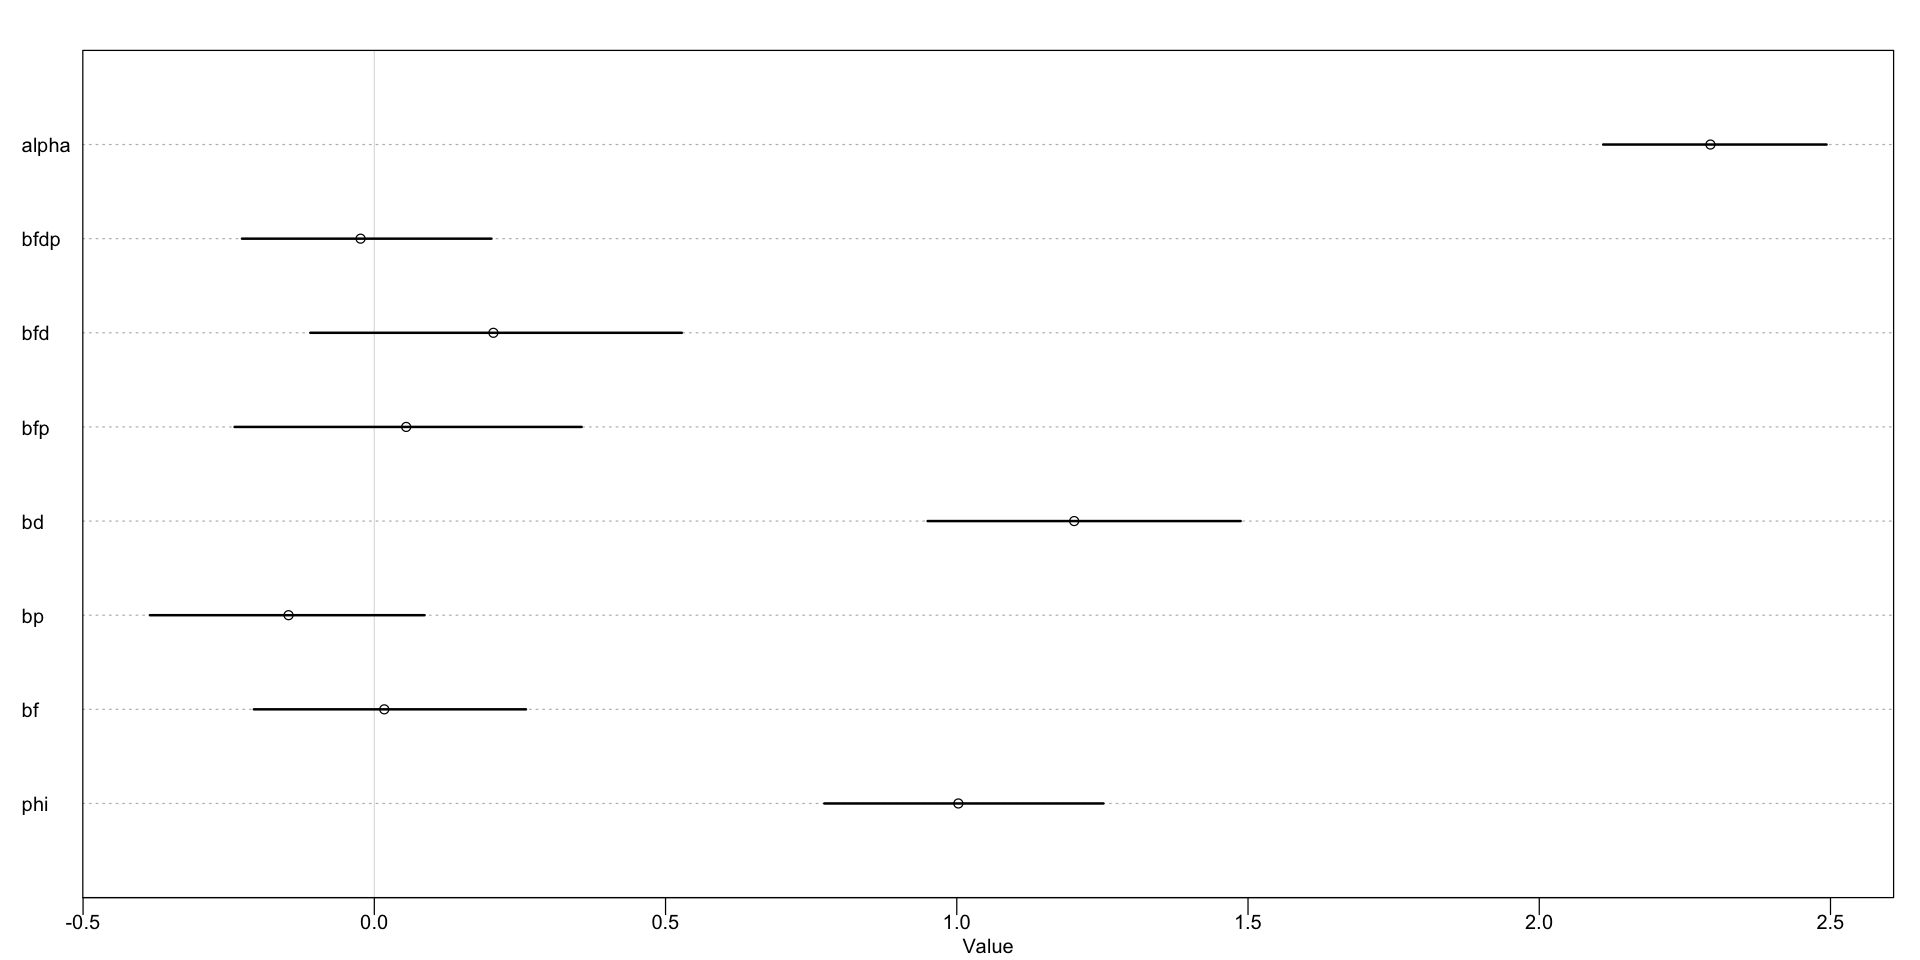

In [100]:
precis(m12h3.interaction.both.log_norm_damage)
par(bg = 'white')
plot(precis(m12h3.interaction.both.log_norm_damage))

Very interesting! So now that we're using the log of the damage, we're pretty sure that only the damage is relevant.

In [101]:
compare(m12h3.interaction.both, m12h3.interaction.both.log_norm_damage)

WAIC     SE       dWAIC    dSE     
m12h3.interaction.both.log_norm_damage 637.8814 32.08560  0.00000       NA
m12h3.interaction.both                 664.5345 35.15605 26.65316 11.20777
                                       pWAIC     weight      
m12h3.interaction.both.log_norm_damage  8.680689 9.999984e-01
m12h3.interaction.both                 10.397064 1.630566e-06

The model that uses the log damage also has a smaller WAIC value (although less than one standard error) - it is doing a slightly better job explaining the data.

#### 12H5 One hypothesis from developmental psychology, usually attributed to Carol Gillian, proposes that women and men have different average tendencies in moral reasoning. Like most hypotheses in social psychology, it is descriptive, not causal. The notion is that women are more concerned with care (avoiding harm) while men are more concerned with justice and rights. Evaluate this hypothesis using the `Trolley` data, supposing that `contact` provides a proxy for physical harm. Are women more or less bothered by contact than are men, in these data? Figure out the model(s) that is needed to address the question.

We'll use the same model, but now give different values for the coefficients depending on male / female.

In [102]:
data(Trolley)
d <- Trolley
head(d)

case  response order id     age male edu           action intention contact
1 cfaqu 4         2    96;434 14  0    Middle School 0      0         1      
2 cfbur 3        31    96;434 14  0    Middle School 0      0         1      
3 cfrub 4        16    96;434 14  0    Middle School 0      0         1      
4 cibox 3        32    96;434 14  0    Middle School 0      1         1      
5 cibur 3         4    96;434 14  0    Middle School 0      1         1      
6 cispe 3         9    96;434 14  0    Middle School 0      1         1      
  story action2
1 aqu   1      
2 bur   1      
3 rub   1      
4 box   1      
5 bur   1      
6 spe   1

In [110]:

dat <- list(
    R = d$response,
    A = d$action,
    I = d$intention,
    C = d$contact,
    Gid = ifelse(d$male == 0, 1L, 2L) # index - 1 for male, 2 for female
)
lapply(dat, head)
dat$Gid

$R
[1] 4 3 4 3 3 3

$A
[1] 0 0 0 0 0 0

$I
[1] 0 0 0 1 1 1

$C
[1] 1 1 1 1 1 1

$Gid
[1] 1 1 1 1 1 1

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
  [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [112] 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 [223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [260] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [297] 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 [334] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [371] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [408] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [445] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 [482] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 [519] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [556] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [593] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [630] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [667] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 [704] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [741] 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [778] 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [815] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 [852] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [889] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [926] 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [963] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
[1000] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1037] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1074] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1111] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1148] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1185] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1222] 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1259] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1296] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1333] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1370] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1407] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1
[1444] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1481] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1518] 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1555] 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
[1592] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1629] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1666] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1703] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1740] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1777] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1814] 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3927.93, but should be greater than the previous element, -3927.93 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e4aed90b9.stan', line 31, column 24 to column 70)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3926.89, but should be greater than the previous element, -3926.89 (in '/var/folders/86/1fgck35j5s9g

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2762.6, but should be greater than the previous element, -2762.6 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e4aed90b9.stan', line 31, column 24 to column 70)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2763.3, but should be greater than the previous element, -2763.3 (in '/var/folders/86/1fgck35j5s9g7_r3

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3299.07, but should be greater than the previous element, -3299.07 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e4aed90b9.stan', line 31, column 24 to column 70)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3300.43, but should be greater than the previous element, -3300.43 (in '/var/folders/86/1fgck35j5s9g

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3518.53, but should be greater than the previous element, -3518.53 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmp3cgi7f/model-221e4aed90b9.stan', line 31, column 24 to column 70)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3516.24, but should be greater than the previous element, -3516.24 (in '/var/folders/86/1fgck35j5s9g

Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 500 / 1000 [ 50%]

mean       sd         5.5%       94.5%        rhat      ess_bulk 
bI           -0.3065778 0.05640764 -0.3942669 -0.215918680 1.0028049  764.0882
bA[1]        -0.7562650 0.06577073 -0.8584842 -0.653486665 1.0016383  912.3648
bA[2]        -0.2452401 0.06056232 -0.3408817 -0.150372465 1.0039680  837.0125
bC[1]        -0.6198487 0.08900053 -0.7604721 -0.478074845 0.9995898 1317.2669
bC[2]        -0.1346086 0.08353697 -0.2656810  0.000352656 1.0045355 1005.7429
bIC[1]       -1.1015761 0.12430514 -1.2939243 -0.900461960 1.0022651 1298.7577
bIC[2]       -1.2984257 0.11776713 -1.4898769 -1.120074350 1.0028564 1088.3760
bIA[1]       -0.3712081 0.09764806 -0.5269281 -0.216332850 1.0019713  947.3549
bIA[2]       -0.4548537 0.09250325 -0.6047378 -0.310297345 1.0067107  822.2111
cutpoints[1] -2.6512861 0.05093094 -2.7313171 -2.568570100 1.0017053  820.9481
cutpoints[2] -1.9575335 0.04681867 -2.0307237 -1.882871750 1.0021271  718.0575
cutpoints[3] -1.3598617 0.04510828 -1.4317011 -1.286116250 1.0022255  642.4998
cutpoints[4] -0.3146359 0.04357853 -0.3835308 -0.245026355 1.0027128  664.7696
cutpoints[5]  0.3642290 0.04375144  0.2949406  0.434527900 1.0028631  836.8323
cutpoints[6]  1.2774009 0.04603521  1.2065089  1.352401100 1.0014592  950.6563

14 vector or matrix parameters hidden. Use depth=2 to show them.



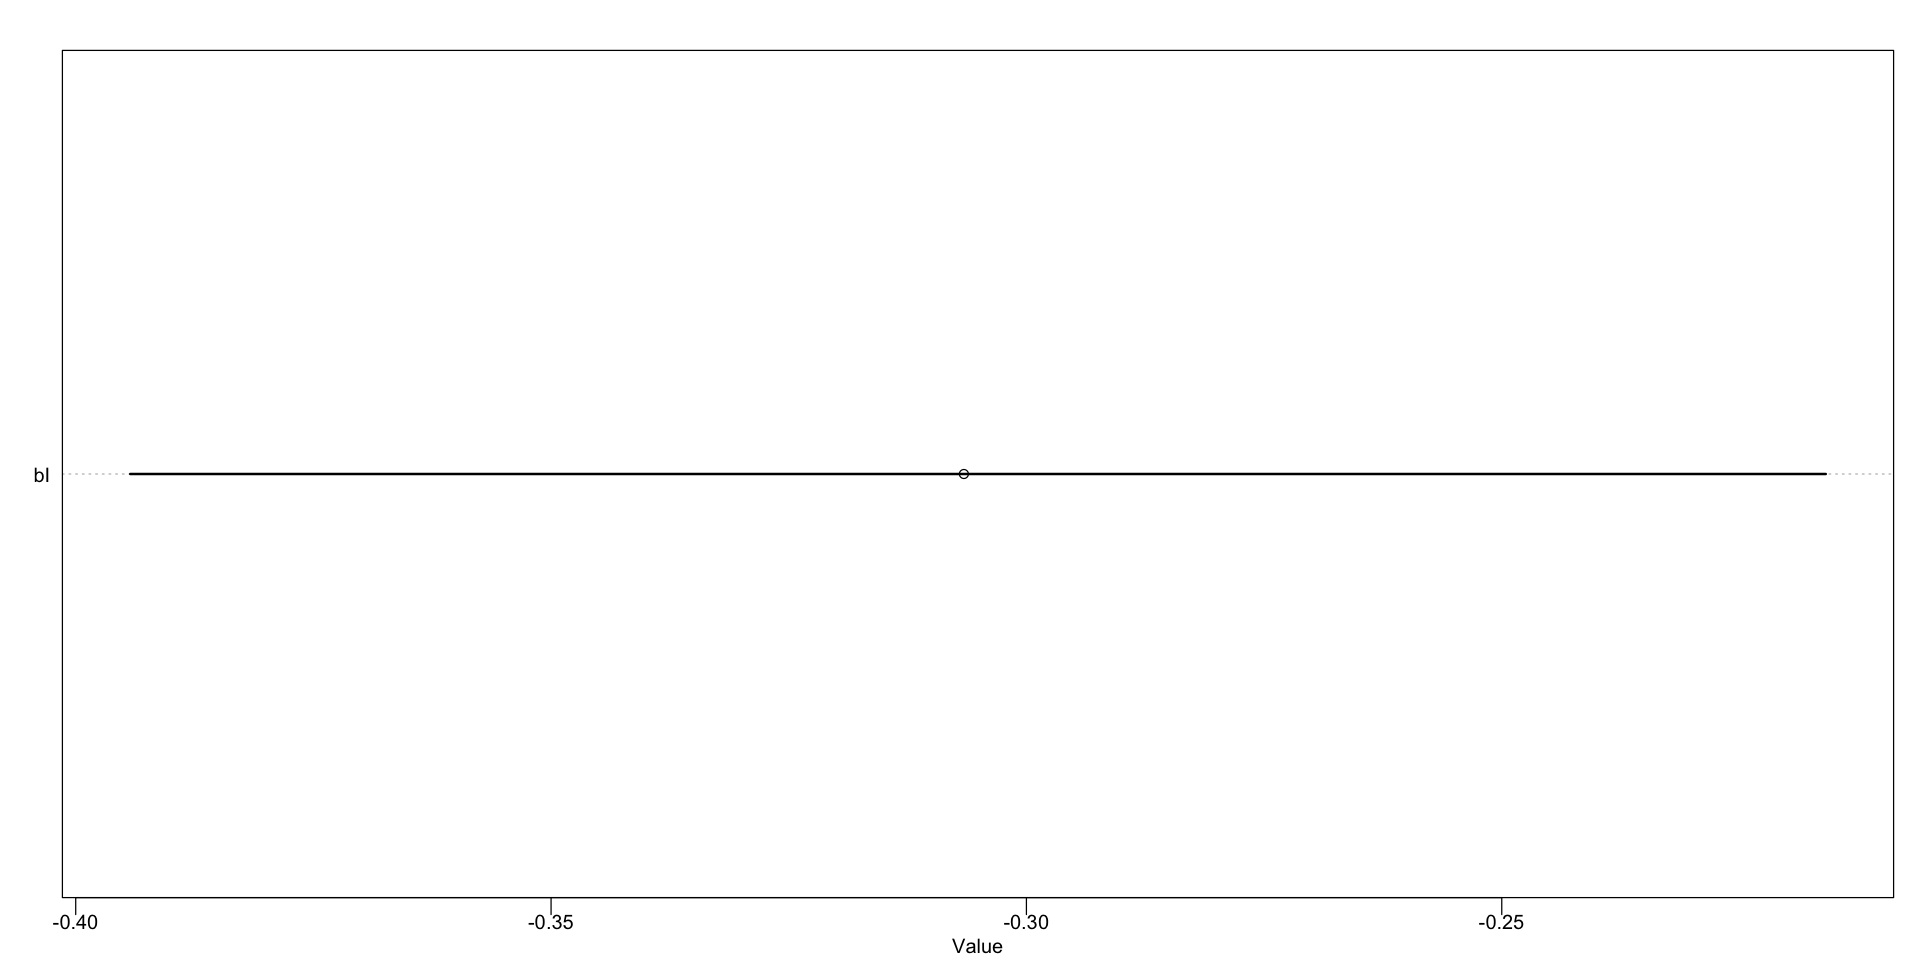

In [117]:
m12h5 <- ulam(
    alist(
        R ~ dordlogit(phi, cutpoints),
        phi <- bA[Gid] * A + bC[Gid] * C + BI * I,
        BI <- bI + bIA[Gid] * A + bIC[Gid] * C,
        bI ~ dnorm(0, 0.5),
        bA[Gid] ~ dnorm(0, 0.5),
        bC[Gid] ~ dnorm(0, 0.5),
        bIC[Gid] ~ dnorm(0, 0.5),
        bIA[Gid] ~ dnorm(0, 0.5),
        cutpoints ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    cores = 4
)

                   mean         sd       5.5%        94.5%      rhat  ess_bulk
bI           -0.3065778 0.05640764 -0.3942669 -0.215918680 1.0028049  764.0882
bA[1]        -0.7562650 0.06577073 -0.8584842 -0.653486665 1.0016383  912.3648
bA[2]        -0.2452401 0.06056232 -0.3408817 -0.150372465 1.0039680  837.0125
bC[1]        -0.6198487 0.08900053 -0.7604721 -0.478074845 0.9995898 1317.2669
bC[2]        -0.1346086 0.08353697 -0.2656810  0.000352656 1.0045355 1005.7429
bIC[1]       -1.1015761 0.12430514 -1.2939243 -0.900461960 1.0022651 1298.7577
bIC[2]       -1.2984257 0.11776713 -1.4898769 -1.120074350 1.0028564 1088.3760
bIA[1]       -0.3712081 0.09764806 -0.5269281 -0.216332850 1.0019713  947.3549
bIA[2]       -0.4548537 0.09250325 -0.6047378 -0.310297345 1.0067107  822.2111
cutpoints[1] -2.6512861 0.05093094 -2.7313171 -2.568570100 1.0017053  820.9481
cutpoints[2] -1.9575335 0.04681867 -2.0307237 -1.882871750 1.0021271  718.0575
cutpoints[3] -1.3598617 0.04510828 -1.4317011 -1.286

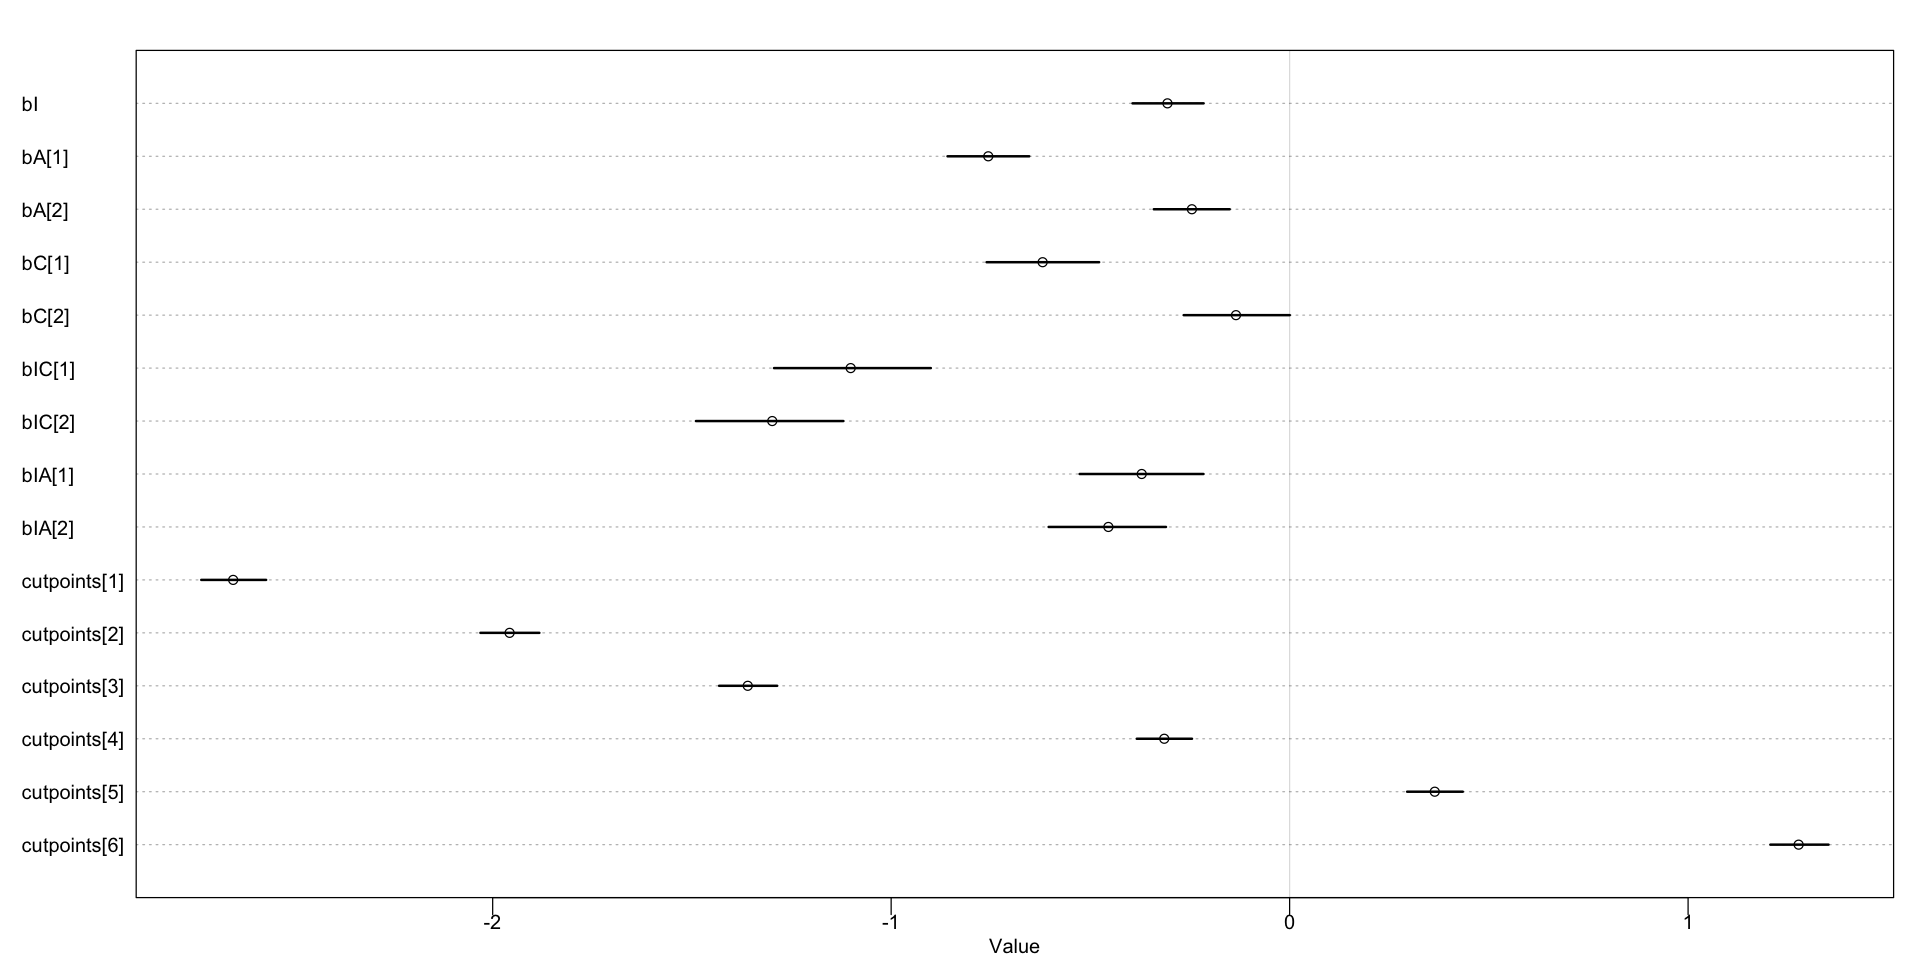

In [118]:
prec <- precis(m12h5, depth = 2)

print(prec)
par(bg = 'white')
plot(prec)

This data / model (roughly) supports the hypothesis that females are more concerned about harm (proxy: the 'contact' variable) than men. Looking at `bC`, the male parameter is less than the female one.

#### 12H6 The data in `data(Fish)` are records of visits to a national park. The question of interest is how many fish an average visitor takes per hour when fishing. The problem is that not everyone tried to fish, so the `fish_caught` numbers are zero-inflated. As with the monks example in the chapter, there is a process that determines who is fishing (working) and another process that determines fish per hour (manuscripts per day), conditional on fishing (working). We want to model both. Otherwise we'll end up with an underestimate of rate of fish extraction from the park. You will model these data using zero-inflated Poisson GLMs. Predict `fish_caught` as a function of any of the other cariables you think are relevant. One thing you must do, however, is to use a proper Poisson offset / exposure in the Poisson portion of the zero-inflated model. Then use the `hours` variable to construct the offset. This will adjust the model for the differing amount of time individuals spent in the park.

In [3]:
data(Fish)
d <- Fish
head(d)

fish_caught livebait camper persons child hours 
1 0           0        0      1       0     21.124
2 0           1        1      1       0      5.732
3 0           1        0      1       0      1.323
4 0           1        1      2       1      0.548
5 1           1        0      1       0      1.695
6 0           1        1      4       2      0.493

In [18]:
summary(d)

  fish_caught         livebait         camper         persons     
 Min.   :  0.000   Min.   :0.000   Min.   :0.000   Min.   :1.000  
 1st Qu.:  0.000   1st Qu.:1.000   1st Qu.:0.000   1st Qu.:2.000  
 Median :  0.000   Median :1.000   Median :1.000   Median :2.000  
 Mean   :  3.296   Mean   :0.864   Mean   :0.588   Mean   :2.528  
 3rd Qu.:  2.000   3rd Qu.:1.000   3rd Qu.:1.000   3rd Qu.:4.000  
 Max.   :149.000   Max.   :1.000   Max.   :1.000   Max.   :4.000  
     child           hours        
 Min.   :0.000   Min.   : 0.0040  
 1st Qu.:0.000   1st Qu.: 0.2865  
 Median :0.000   Median : 1.8315  
 Mean   :0.684   Mean   : 5.5260  
 3rd Qu.:1.000   3rd Qu.: 7.3427  
 Max.   :3.000   Max.   :71.0360  

In [4]:
?Fish

Fish                package:rethinking                 R Documentation

_F_i_s_h_i_n_g _d_a_t_a

_D_e_s_c_r_i_p_t_i_o_n:

     Fishing data from visitors to a national park.

_U_s_a_g_e:

     data(Fish)
     
_F_o_r_m_a_t:

       1. fish_caught : Number of fish caught during visit

       2. livebait : Whether or not group used livebait to fish

       3. camper : Whether or not group had a camper

       4. persons : Number of adults in group

       5. child : Number of children in group

       6. hours : Number of hours group spent in park


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


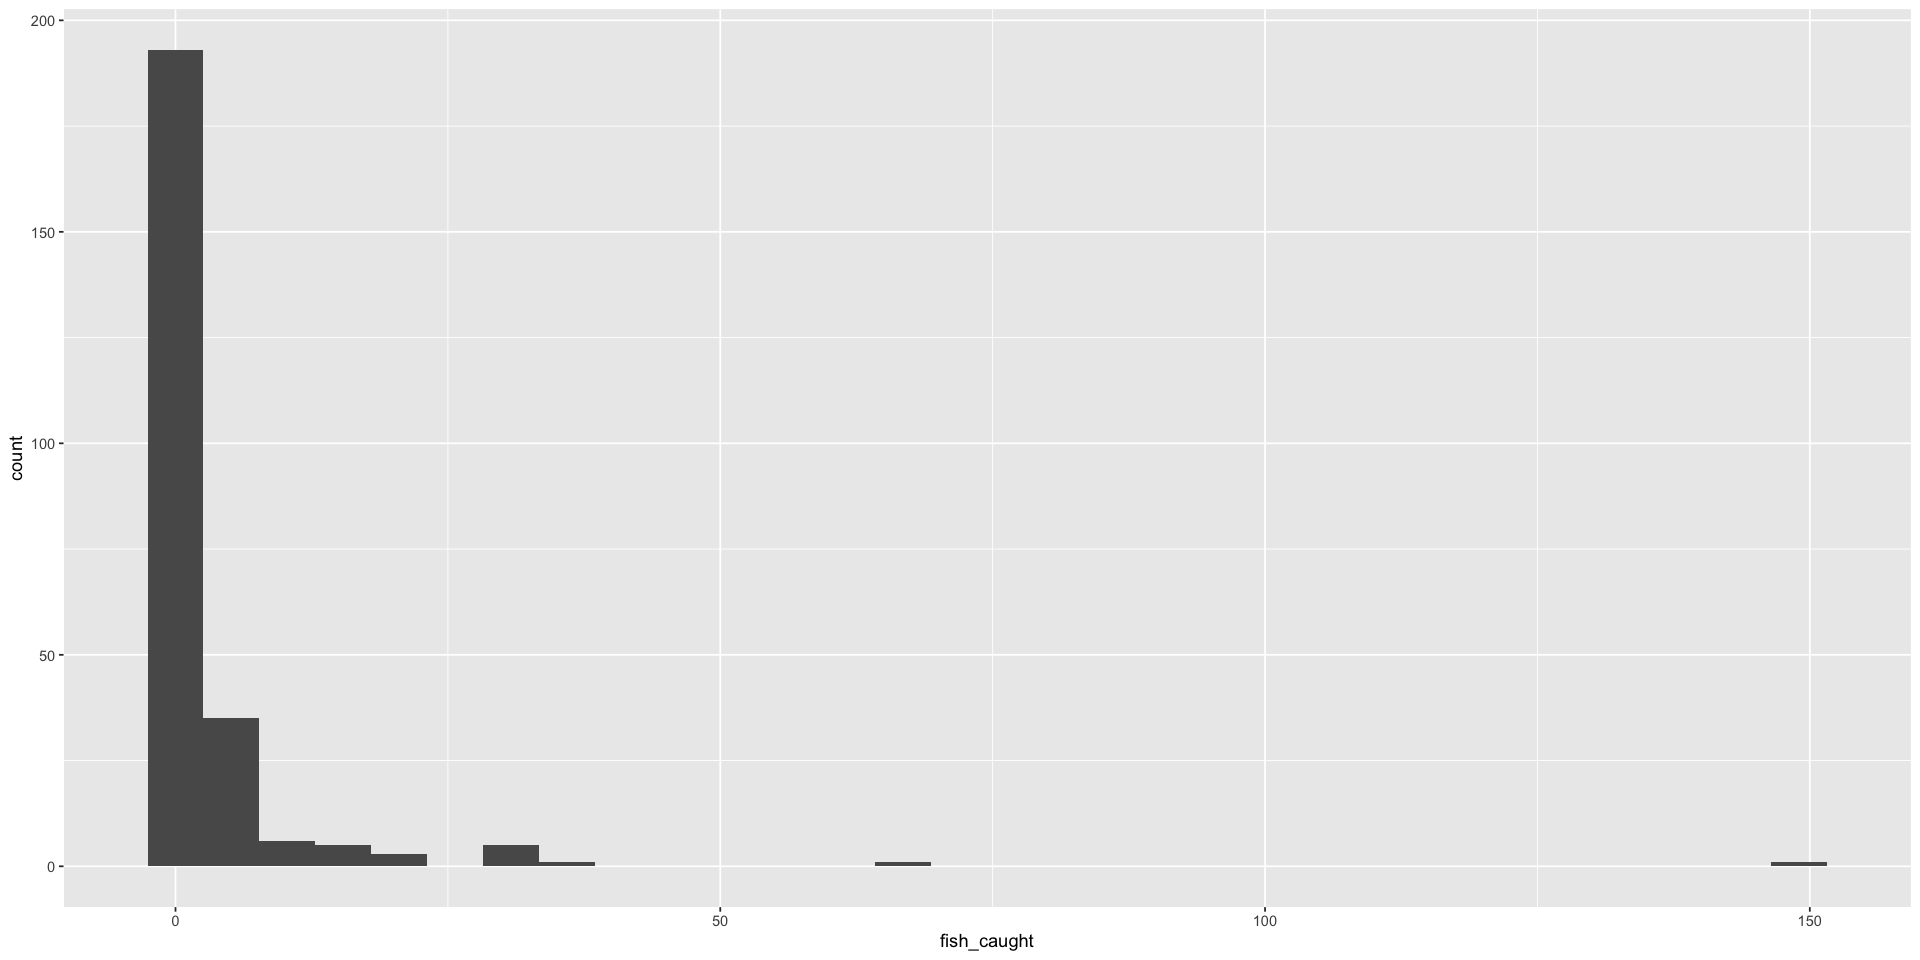

In [5]:
ggplot(d, aes(fish_caught)) +
    geom_histogram()

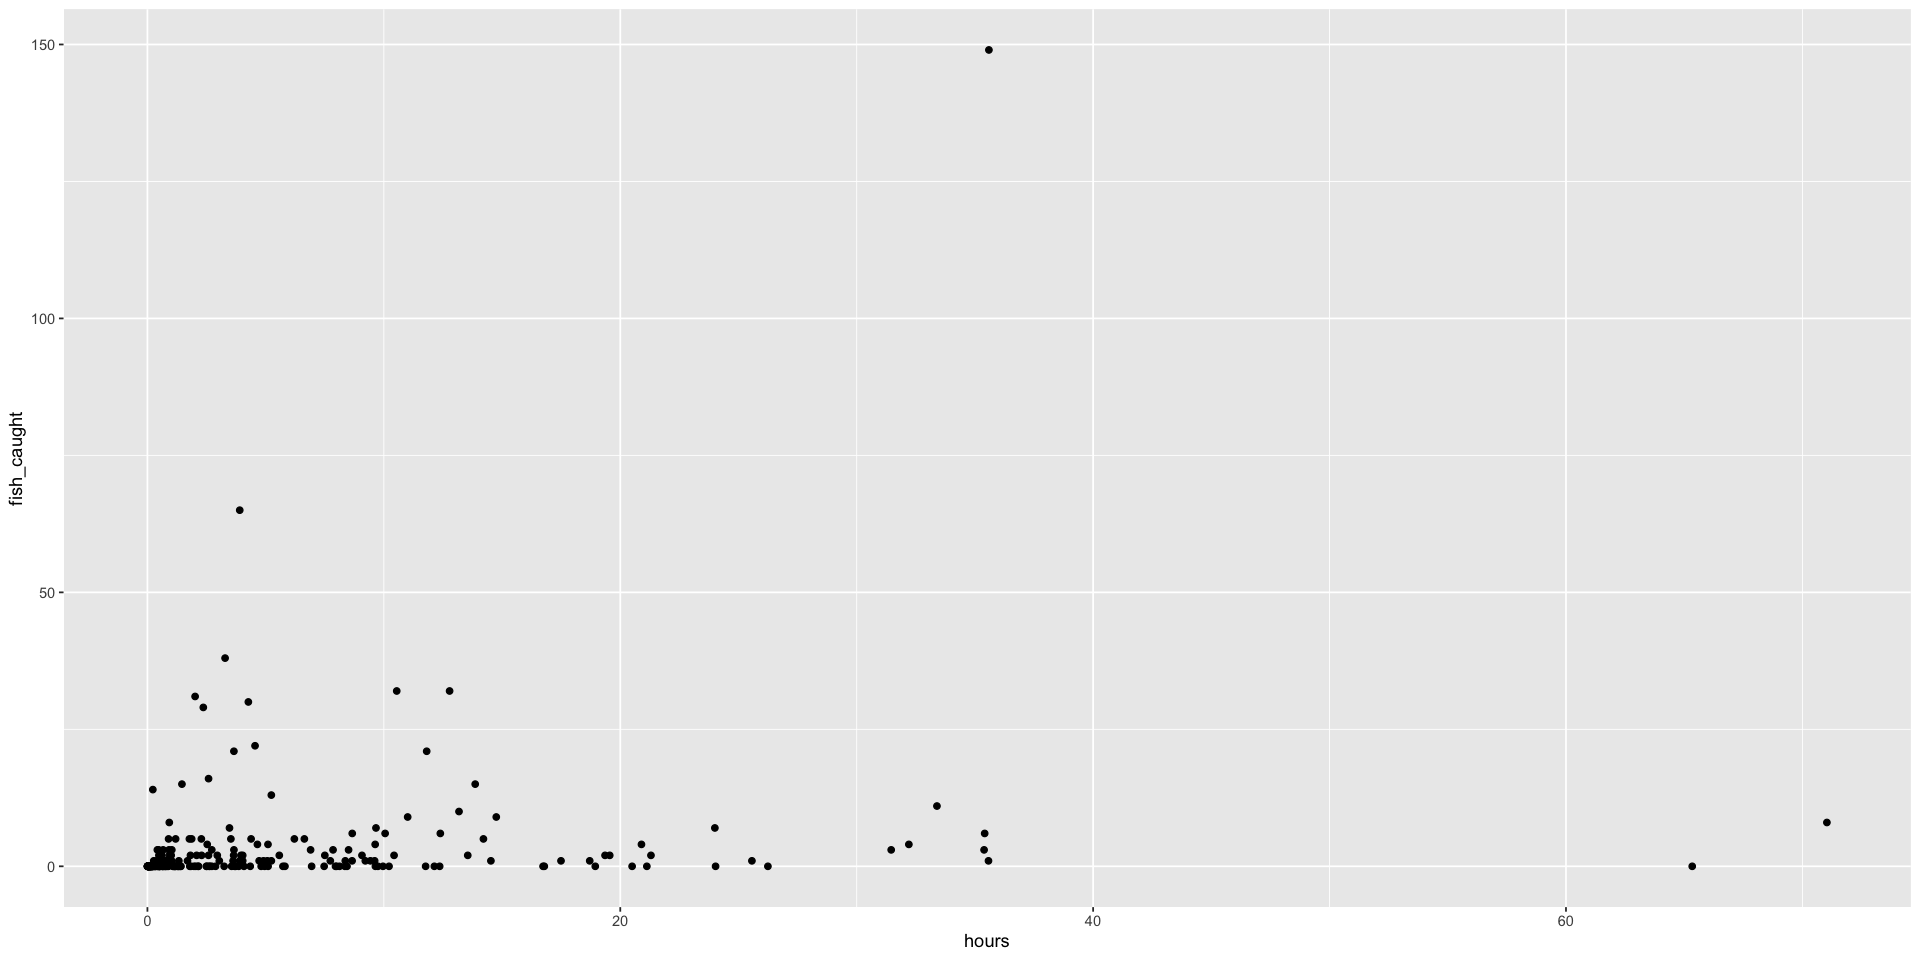

In [6]:
ggplot(d, aes(hours, fish_caught)) +
    geom_point()

Let's start with a super simple model: zero inflated, some probability of fishing and then some prior for the rate lambda.

In [39]:
data <- list(
    f = d$fish_caught,
    log_hours = log(d$hours)
)
m12h6.1 <- ulam(
    alist(
        f ~ dzipois(p, lambda),
        logit(p) ~ dnorm(0, 1),
        log(lambda) <- log_hours + a,
        a ~ dnorm(0, 1)
    ),
    data = data,
    log_lik = TRUE
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: log_mix: theta is -218.387, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGgBSi4/model-c456294e9e5.stan', line 19, column 12 to column 67)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: log_mix: theta is -217.987, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGgBSi4/model-c456294e9e5.stan', line 19, column 12 to column 67)

Chain 1 If this warning occurs sporadically, such as for highly constrained vari

Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: log_mix: theta is -0.267455, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGgBSi4/model-c456294e9e5.stan', line 19, column 12 to column 67)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.


        mean         sd       5.5%       94.5%      rhat ess_bulk
p  0.3233473 0.03992419  0.2612199  0.38644382 1.0037633 186.6498
a -0.1458901 0.03796932 -0.2104045 -0.08749367 0.9982549 232.9276


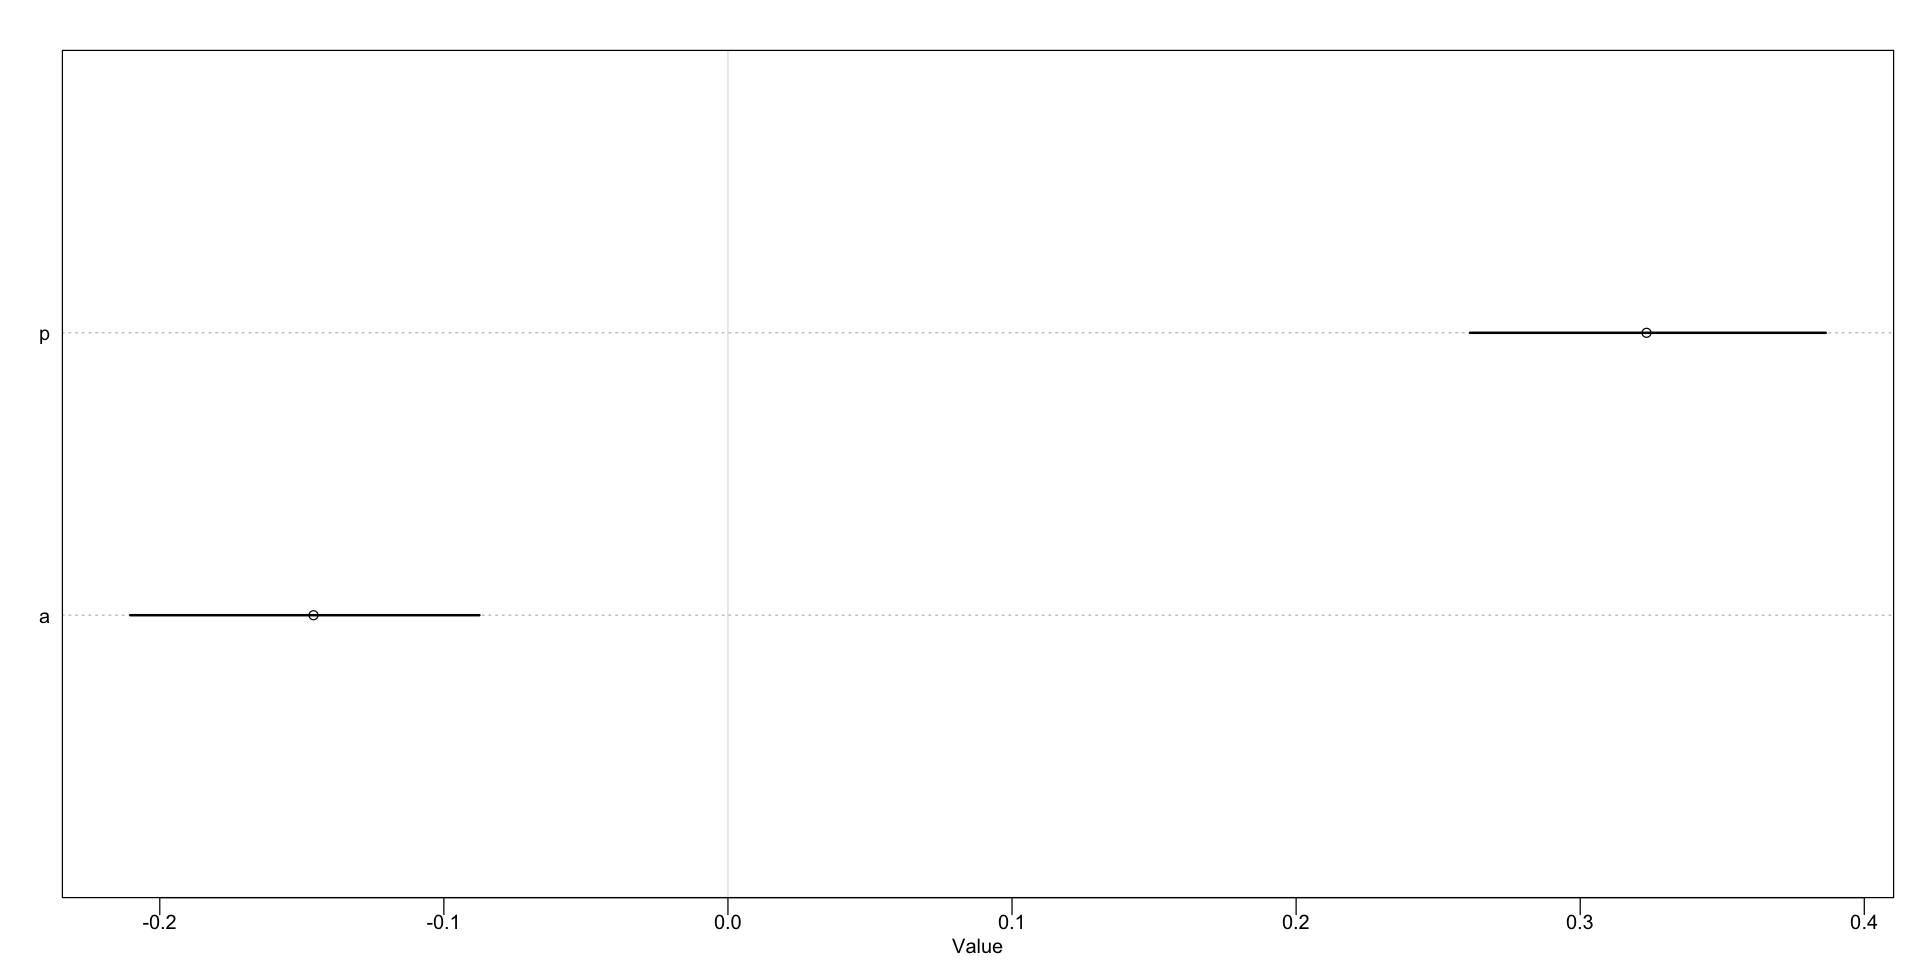

In [17]:
prec <- precis(m12h6.1)
print(prec)
par(bg = 'white')
plot(prec)

In [40]:
hours_sim <- seq(1, 50, length.out = 100)
preds <- link(m12h6.1, data = list(log_hours=(log(hours_sim))))
preds

[,1]      [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]    
 [1,] 0.8492370 1.269566 1.689896 2.110225 2.530555 2.950884 3.371213 3.791543
 [2,] 0.8593560 1.284694 1.710032 2.135369 2.560707 2.986045 3.411383 3.836721
 [3,] 0.8525342 1.274496 1.696457 2.118418 2.540380 2.962341 3.384302 3.806264
 [4,] 0.8688585 1.298900 1.728941 2.158982 2.589023 3.019064 3.449105 3.879146
 [5,] 0.8608887 1.286985 1.713082 2.139178 2.565275 2.991371 3.417467 3.843564
 [6,] 0.8617483 1.288270 1.714792 2.141314 2.567836 2.994358 3.420880 3.847402
 [7,] 0.8692530 1.299489 1.729726 2.159962 2.590198 3.020435 3.450671 3.880908
 [8,] 0.8634166 1.290764 1.718112 2.145459 2.572807 3.000155 3.427502 3.854850
 [9,] 0.8481761 1.267980 1.687785 2.107589 2.527393 2.947198 3.367002 3.786806
[10,] 0.8300403 1.240868 1.651696 2.062524 2.473352 2.884181 3.295009 3.705837
[11,] 0.8394260 1.254899 1.670373 2.085846 2.501320 2.916793 3.332267 3.747740
[12,] 0.8759318 1.309474 1.743016 2.176558 2.610100 3.043642 3.477184 3.910726
[13,] 0.8654740 1.293840 1.722206 2.150572 2.578938 3.007303 3.435669 3.864035
[14,] 0.8421779 1.259013 1.675849 2.092684 2.509520 2.926356 3.343191 3.760027
[15,] 0.8884686 1.328216 1.767963 2.207710 2.647457 3.087204 3.526951 3.966698
[16,] 0.8708121 1.301820 1.732828 2.163836 2.594844 3.025852 3.456860 3.887868
[17,] 0.8417889 1.258432 1.675075 2.091718 2.508361 2.925004 3.341647 3.758290
[18,] 0.8333938 1.245882 1.658369 2.070857 2.483345 2.895833 3.308321 3.720809
[19,] 0.8204462 1.226526 1.632605 2.038684 2.444764 2.850843 3.256923 3.663002
[20,] 0.8622285 1.288988 1.715748 2.142507 2.569267 2.996026 3.422786 3.849545
[21,] 0.8844025 1.322137 1.759872 2.197606 2.635341 3.073075 3.510810 3.948545
[22,] 0.8524566 1.274380 1.696302 2.118225 2.540148 2.962071 3.383994 3.805917
[23,] 0.8182168 1.223193 1.628169 2.033145 2.438121 2.843097 3.248073 3.653049
[24,] 0.8987791 1.343629 1.788480 2.233330 2.678180 3.123030 3.567881 4.012731
[25,] 0.9059906 1.354410 1.802830 2.251249 2.699669 3.148089 3.596508 4.044928
[26,] 0.9030061 1.349948 1.796891 2.243833 2.690776 3.137718 3.584660 4.031603
[27,] 0.8376014 1.252172 1.666742 2.081312 2.495883 2.910453 3.325024 3.739594
[28,] 0.8716930 1.303137 1.734581 2.166025 2.597469 3.028913 3.460357 3.891801
[29,] 0.8779734 1.312526 1.747078 2.181631 2.616183 3.050736 3.485288 3.919841
[30,] 0.9206341 1.376301 1.831969 2.287636 2.743304 3.198971 3.654638 4.110306
[31,] ⋮         ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
[32,] 0.8825278 1.319334 1.756141 2.192948 2.629755 3.066561 3.503368 3.940175
[33,] 0.8346306 1.247731 1.660831 2.073931 2.487031 2.900131 3.313231 3.726331
[34,] 0.8797135 1.315127 1.750541 2.185955 2.621368 3.056782 3.492196 3.927610
[35,] 0.8730871 1.305221 1.737355 2.169489 2.601623 3.033757 3.465891 3.898025
[36,] 0.8816113 1.317964 1.754317 2.190671 2.627024 3.063377 3.499730 3.936083
[37,] 0.8614399 1.287809 1.714178 2.140548 2.566917 2.993286 3.419655 3.846025
[38,] 0.8722650 1.303992 1.735719 2.167446 2.599173 3.030901 3.462628 3.894355
[39,] 0.8718272 1.303338 1.734848 2.166359 2.597869 3.029379 3.460890 3.892400
[40,] 0.8477004 1.267269 1.686838 2.106407 2.525976 2.945545 3.365114 3.784683
[41,] 0.8619336 1.288547 1.715161 2.141774 2.568388 2.995002 3.421615 3.848229
[42,] 0.9047668 1.352581 1.800395 2.248209 2.696022 3.143836 3.591650 4.039464
[43,] 0.8977748 1.342128 1.786481 2.230834 2.675188 3.119541 3.563894 4.008247
[44,] 0.9149917 1.367866 1.820741 2.273616 2.726490 3.179365 3.632240 4.085114
[45,] 0.9193801 1.374427 1.829474 2.284520 2.739567 3.194614 3.649661 4.104707
[46,] 0.8510044 1.272209 1.693413 2.114617 2.535821 2.957025 3.378230 3.799434
[47,] 0.8709837 1.302077 1.733170 2.164263 2.595356 3.026448 3.457541 3.888634
[48,] 0.8689958 1.299105 1.729214 2.159323 2.589432 3.019541 3.449650 3.879759
[49,] 0.9434077 1.410347 1.877286 2.344225 2.811164 3.278104 3.745043 4.211982
[50,] 0.8491020 1.269365 1.689627 2.109890 2.530152 2.95

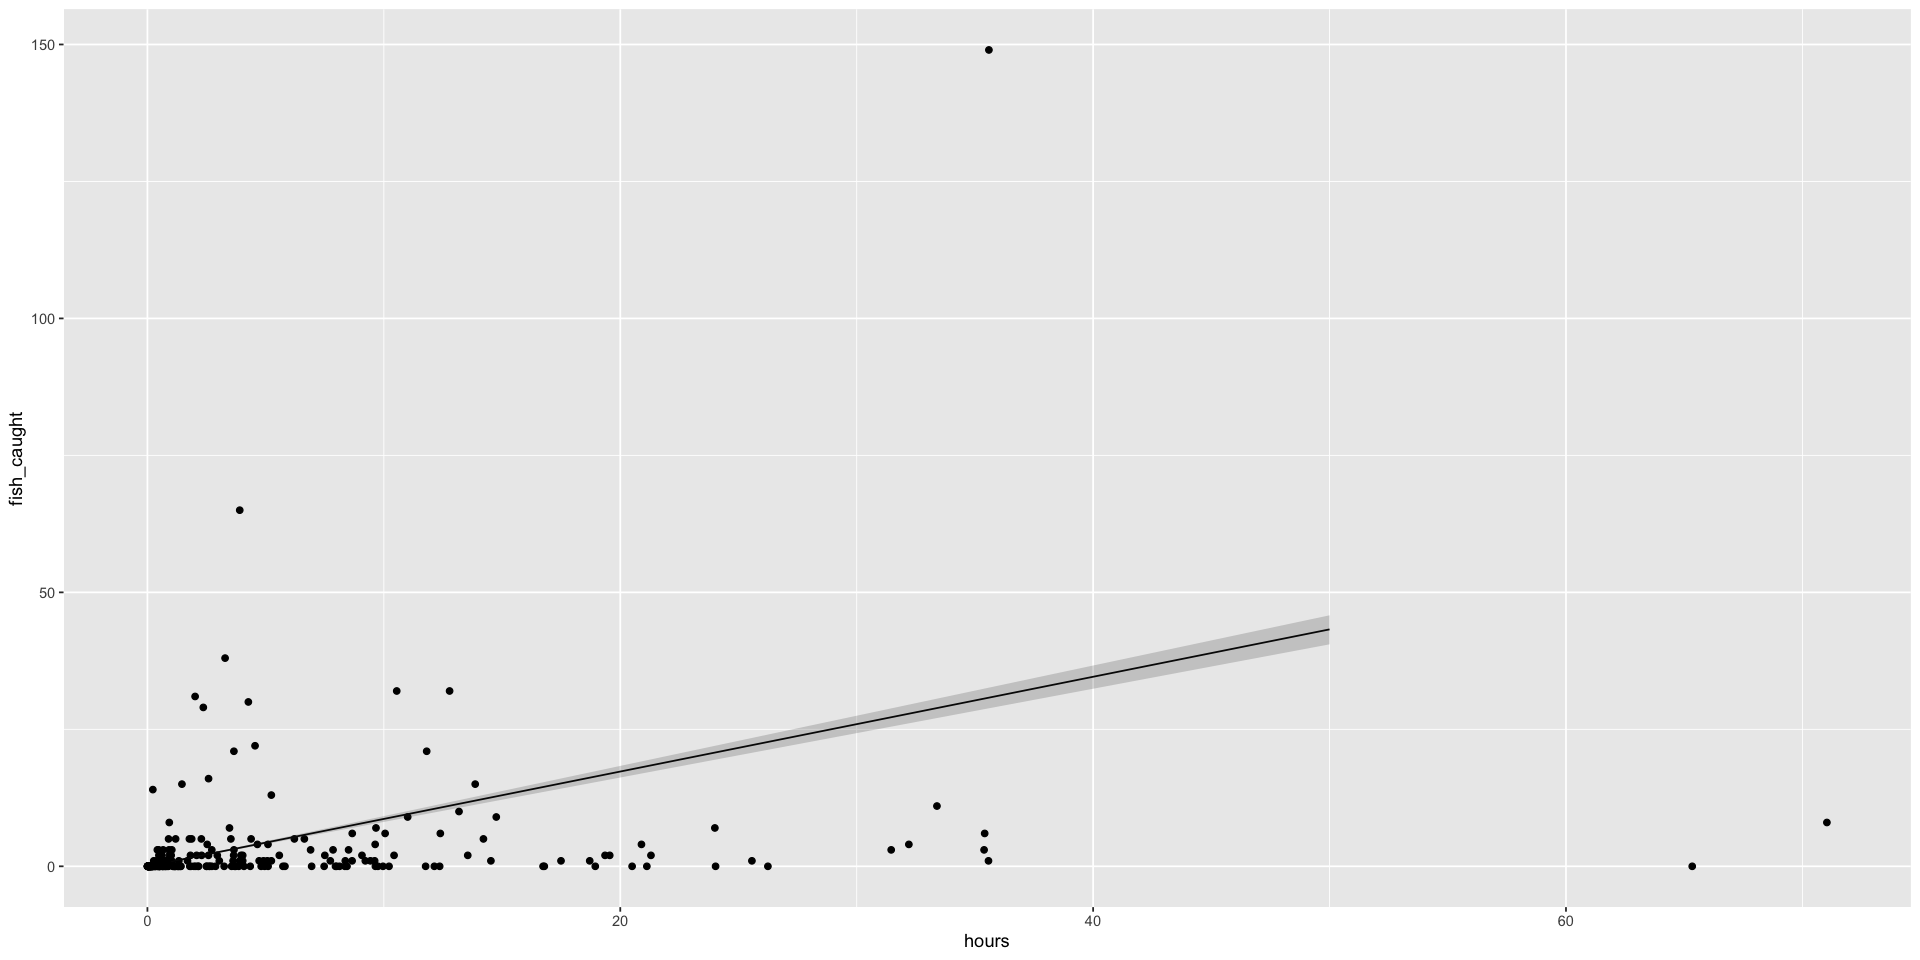

In [26]:
means <- apply(preds, 2, mean)
bounds <- apply(preds, 2, PI)

plot_df <- data.frame(hours = hours_sim, mean = means, lower = bounds[1, ], upper = bounds[2, ])
ggplot(plot_df, aes(hours)) +
    geom_point(data = d, aes(hours, fish_caught)) +
    geom_line(mapping = aes(y = mean)) +
    geom_ribbon(data = plot_df, aes(hours, ymin = lower, ymax = upper), alpha = 0.2)

This is pretty bad. Let's add in some predictors.

- `live_bait` should increase the number of fish caught
- `camper` should affect the probability of going fishing
- `persons` should affect the number caught
- `child` and adults should have a different 'rate' of catching fish

In [41]:
head(d)

fish_caught livebait camper persons child hours 
1 0           0        0      1       0     21.124
2 0           1        1      1       0      5.732
3 0           1        0      1       0      1.323
4 0           1        1      2       1      0.548
5 1           1        0      1       0      1.695
6 0           1        1      4       2      0.493

In [43]:
data <- list(
    f = d$fish_caught,
    log_hours = log(d$hours),
    livebait_index = d$livebait + 1,
    camper_index = d$camper + 1,
    adults = d$persons - d$child,
    children = d$child
)

m12h6.2 <- ulam(
    alist(
        f ~ dzipois(p, lambda),
        logit(p) <- bc[camper_index],
        log(lambda) <- log_hours + a[livebait_index] + b_adult * adults + b_child * children,
        bc[camper_index] ~ dnorm(0, 1),
        a[livebait_index] ~ dnorm(0, 1),
        c(b_adult, b_child) ~ dnorm(0, 1)
    ),
    data = data,
    log_lik = TRUE
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 1.3 seconds.


              mean         sd       5.5%      94.5%      rhat ess_bulk
bc[1]   -1.1755715 0.43875374 -1.9319694 -0.5453518 1.0069789 439.4500
bc[2]   -1.1881850 0.29246003 -1.6784902 -0.7316058 0.9980242 428.6331
a[1]    -3.4929129 0.26972767 -3.9200211 -3.0523188 1.0057097 295.1996
a[2]    -2.1734427 0.14612443 -2.4154674 -1.9339698 1.0005593 272.1121
b_child  1.1901226 0.09689764  1.0206932  1.3388843 0.9986143 379.3646
b_adult  0.6540439 0.04169641  0.5887261  0.7182928 0.9998876 269.3255


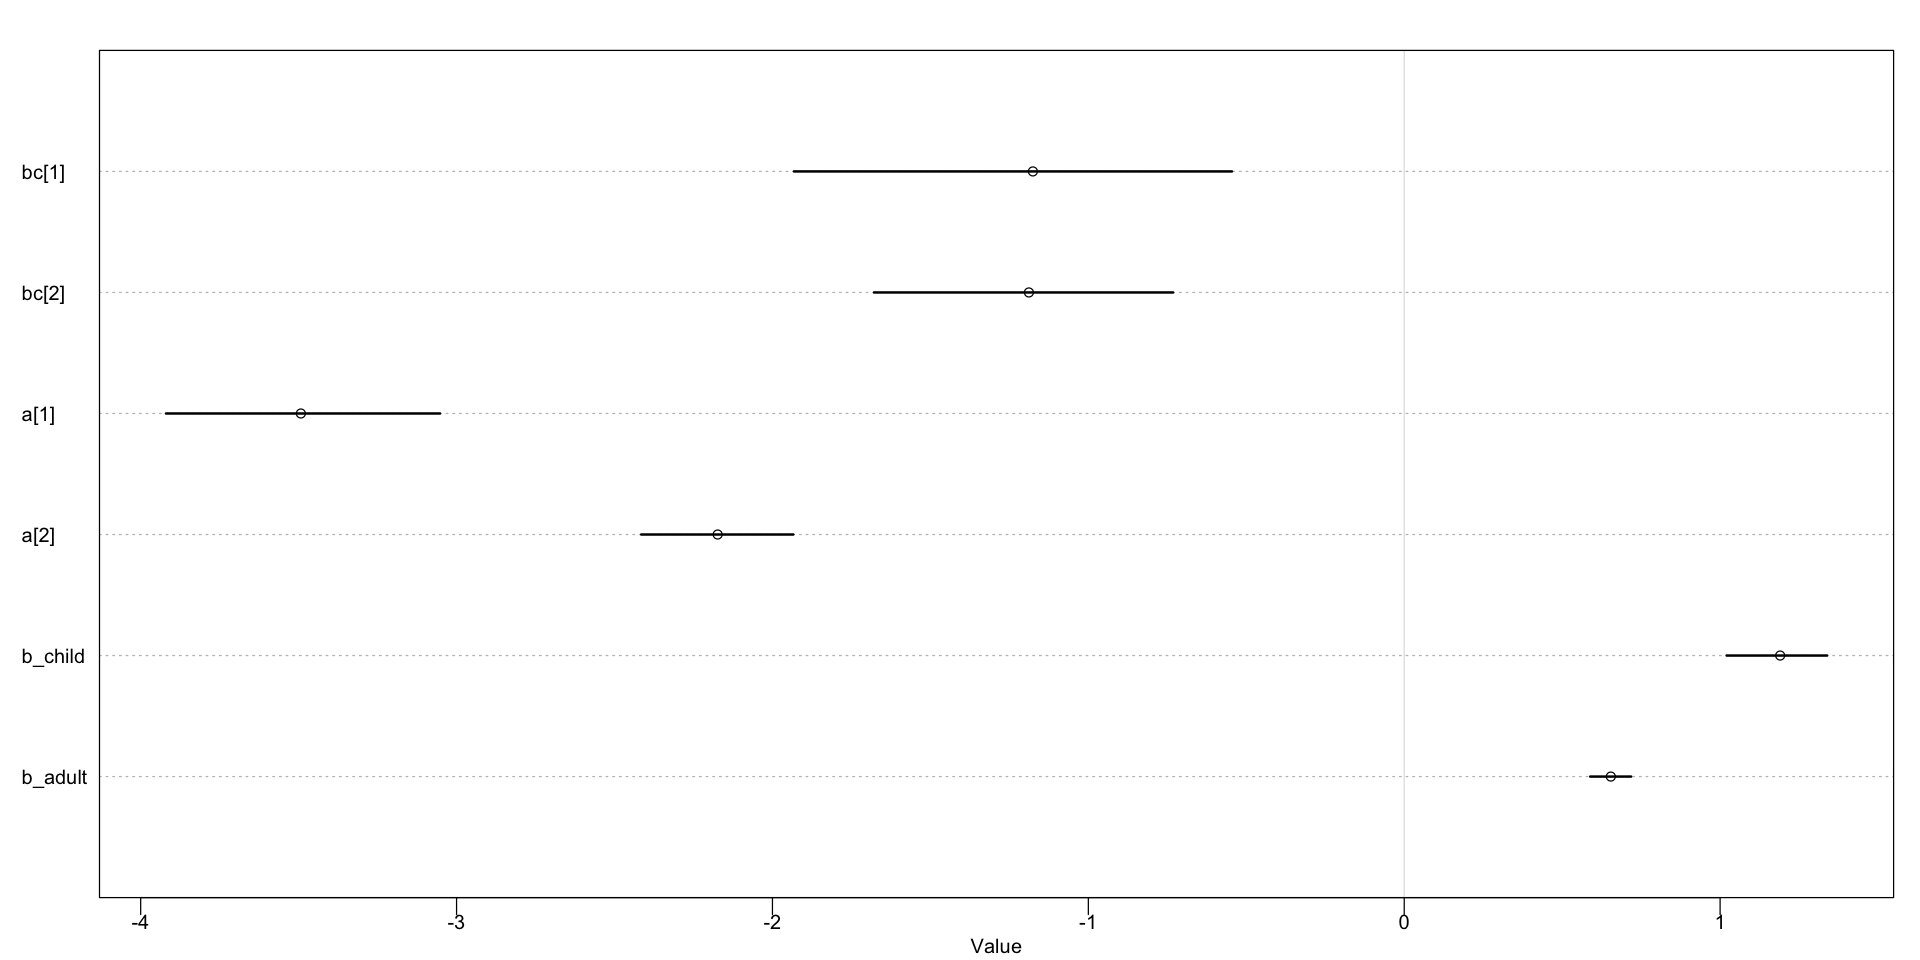

In [45]:
pre <- precis(m12h6.2, depth = 2)
print(pre)
par(bg = 'white')
plot(pre)

In [46]:
compare(m12h6.1, m12h6.2)

WAIC     SE       dWAIC    dSE      pWAIC    weight      
m12h6.2 2146.362 391.5616   0.0000       NA 91.57640 1.000000e+00
m12h6.1 2563.622 466.4085 417.2603 227.3142 45.19352 2.472103e-91

Some interesting results! It looks like being in a camper doesn't actually affect your chances of going fishing, which is a bit surprising. Also surprising is the fact that it looks like children are better at fishing than adults!

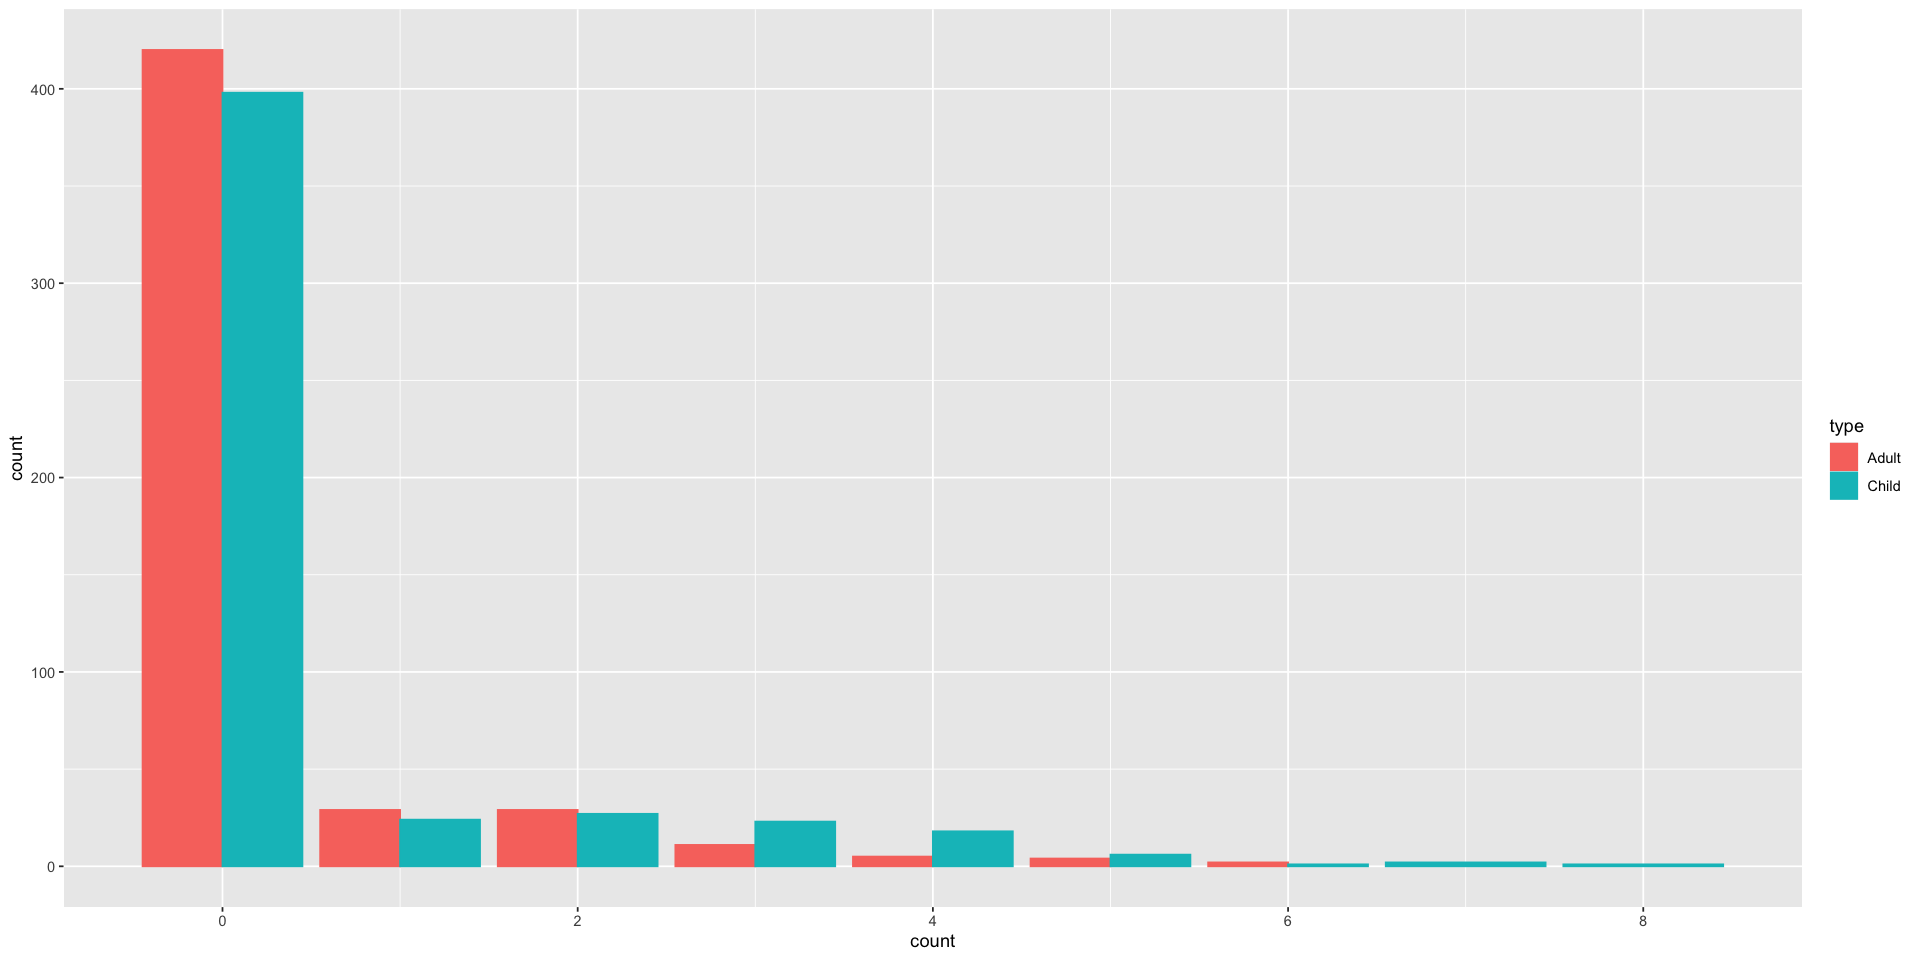

In [63]:
child_data <- list(
    log_hours = log(24),
    livebait_index = 1,
    camper_index = 1,
    adults = 0,
    children = 1
)
adult_data <- list(
    log_hours = log(24),
    livebait_index = 1,
    camper_index = 1,
    adults = 1,
    children = 0
)

l_child <- link(m12h6.2, data = child_data)
child_counts <- rbern(length(l_child$p), l_child$p) * rpois(length(l_child$lambda), l_child$lambda)
l_adult <- link(m12h6.2, data = adult_data)
adult_counts <- rbern(length(l_adult$p), l_adult$p) * rpois(length(l_adult$lambda), l_adult$lambda)

plot_df <- rbind(
    data.frame(count = child_counts, type = "Child"),
    data.frame(count = adult_counts, type = "Adult")
)

ggplot(plot_df, aes(count, colour = type, fill = type)) +
    geom_bar(position = 'dodge')

#### 12H7 In the trolley data we saw how education level (modeled as an ordered category) is associated with responses. But is this association causal? One plausible confound is that education is also associated with age, through a causal process: prople are older when they finish school than when they begin it. Reconsider the Trolley data in this light. Draw a DAG that representat hypotheical causal relathionships among response, education, and age. Which statistical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

#### 12H8 Consider one more variable in the trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes responses, education, age, and gender. Using only the DAG, is it possible that the inferences from 12H7 above are confounded by gender? If so, define any additional omdels you need to infer the causal influence of education on response. What do you conclude?